# import

In [1]:

import os
import glob
import shutil
import json
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.offsetbox import AnnotationBbox
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2 as cv
import h5py
import hdf5storage
from natsort import natsorted
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import (
    pearsonr, spearmanr, norm, f_oneway, mannwhitneyu, 
    ttest_ind, shapiro, levene, kstest, kruskal
)
from scipy.sparse.linalg import eigsh

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator

from functions import *


# Data path and drawing parameters

In [2]:
MonkeyA_path = './Monkey_A'
MonkeyB_path = './Monkey_B'
MonkeyC_path = './Monkey_C'
MonkeyD_path = './Monkey_D'

MonkeyA_old_path = '../MA/Analysis'
MonkeyB_old_path = '../MB_CC/Analysis'
MonkeyC_old_path = '../MC_CC/Analysis'
MonkeyD_old_path = '../MD/Analysis'

MonkeyA_origin_path = '../MA/Analysis_old'
MonkeyB_origin_path = '../MB_CC/Analysis_old'
MonkeyC_origin_path = '../MC_CC/Analysis_old'
MonkeyD_origin_path = '../MD/Analysis_old'

Monkey_path_list = [MonkeyA_path, MonkeyB_path, MonkeyC_path, MonkeyD_path]
Monkey_old_path_list = [MonkeyA_old_path, MonkeyB_old_path, MonkeyC_old_path, MonkeyD_old_path]
Monkey_origin_path_list = [MonkeyA_origin_path, MonkeyB_origin_path, MonkeyC_origin_path, MonkeyD_origin_path]

Monkey_name = ['Monkey A', 'Monkey B', 'Monkey C', 'Monkey D']

main_dir = './Results_20250320/main'
supple_dir = './Results_20250320/supple'


In [27]:
panel_label_size = 12
sub_title_size = 10
label_size = 9
tick_size = 7
legend_size = 7

the_specific_group = 11
monkey_palette = ["#ff825c", "#d43d3d", "#6596E5", "#7A7CBB"]#e18a3b

ori_color = '#E22B1C'
non_ori_color = '#3161B2'



signi_ori_color = '#7A7CBB'
all_color = '#ce93bf'
neuron_color=[ori_color, non_ori_color]
neuron_color_3compare = [ori_color, non_ori_color, signi_ori_color]
spatial_size = ['s', 'm', 'l']
spatial_frequency = np.array([0.25,0.5,1,2,4,8])
ori_array = [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]
oln = len(ori_array)
original_rcParams = dict(mpl.rcParams)

# Neuron count proportion

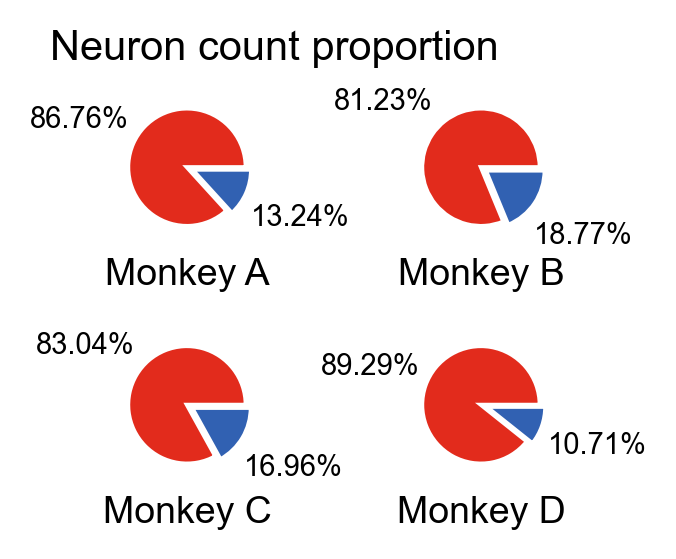

In [28]:
fig = plt.figure(figsize=(2.1,2.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

pie_width = 0.18
x_interval = 0.22
y_interval = 0.25
text_x = 0
radius=1
pie_linewidth=1
start_x = 0.35
x_label_2 = -1

for monkey_id in range(len(Monkey_name)):
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results4_explain/weights_quantitative_explain')
    proportion_ori_cell = np.squeeze(loadmat_data(os.path.join(data_path, 'proportion_ori_cell.mat')))
    ax=fig.add_subplot(2, 2, monkey_id+1)
    ax.pie(x=[proportion_ori_cell, 1 - proportion_ori_cell],
            colors=[ori_color, non_ori_color],
            autopct='%.2f%%',
            pctdistance=2,
            explode=(0, 0.1),
            radius=radius,
     
            wedgeprops={'edgecolor':'w',
                        'alpha':1,
                        'linewidth':pie_linewidth,                                      
                    },
            textprops={'fontsize': legend_size}
        )
    ax.set_xlabel(Monkey_name[monkey_id],  fontsize=label_size)
    
    
ax.text(0.05, 0.95, f'Neuron count proportion', transform=fig.transFigure, fontsize=sub_title_size, ha='left', va='center') 
plt.subplots_adjust(left=.15, bottom=.26, right=0.85, top=0.92, wspace=1, hspace=0.2) 
save_path = os.path.join(main_dir, 'neuron_number_per.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

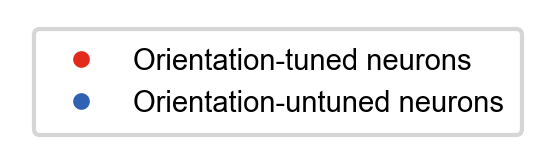

In [29]:
fig_legend = plt.figure(figsize=(2.1,0.4),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
ax = fig_legend.gca()
ax.axis('off')


alpha = 1
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ori_color, markersize=5, label='Orientation-tuned neurons' ,alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=non_ori_color, markersize=5, label='Orientation-untuned neurons', alpha=alpha),
]



fig_legend.legend(
    handles=legend_elements, loc='center', frameon=True, fontsize=tick_size, 
    ncol=1, 
    borderpad=0.6, 

)
save_path = os.path.join(main_dir, 'neuron_number_per_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Decoding example (Scatter plot)

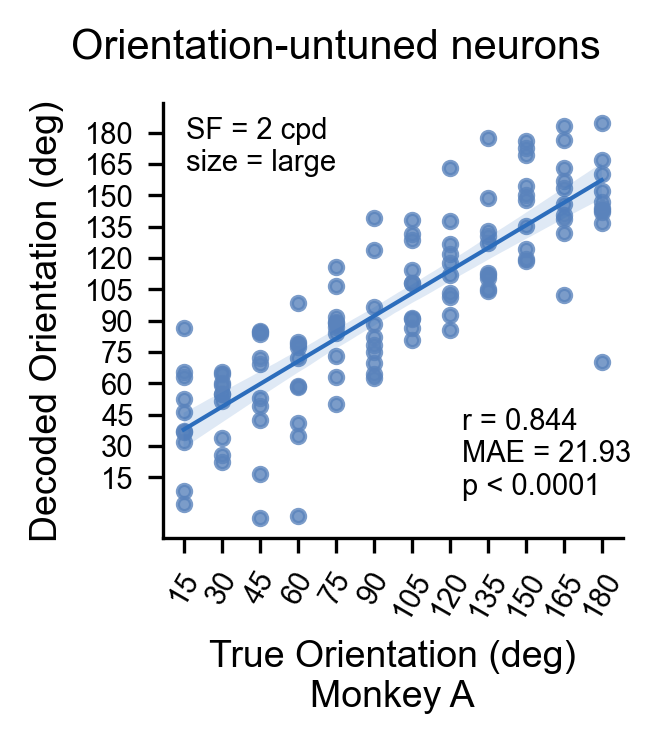

In [32]:
data_path = os.path.join(MonkeyA_old_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/all_groups_1000_rounds_median_non_ori_results.mat')
all_groups_1000_rounds_median_non_ori_results = np.squeeze(loadmat_data(data_path))
the_specific_group_non_ori_results = all_groups_1000_rounds_median_non_ori_results[the_specific_group]
r_mean_non_ori = np.squeeze(the_specific_group_non_ori_results[1])
p_mean_non_ori = np.squeeze(the_specific_group_non_ori_results[2])
MAE_non_ori = np.squeeze(the_specific_group_non_ori_results[5])
MAE_mean_non_ori = np.mean(MAE_non_ori)
predicted_all_non_ori = np.squeeze(the_specific_group_non_ori_results[6])
Y_test_all_non_ori = np.squeeze(the_specific_group_non_ori_results[7])
weights_non_ori_best = np.squeeze(the_specific_group_non_ori_results[8])

ori_cell= np.squeeze(loadmat_data(os.path.join(MonkeyA_old_path, 'ori_cell.mat')))


fig = plt.figure(figsize=(2.1,2.3),facecolor='w', frameon=True, dpi=300) 

plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

sns.regplot(x=Y_test_all_non_ori, y=predicted_all_non_ori, 
            scatter_kws={"s":10, "marker":"o", 'color':'#5A83BC'}, line_kws={'linewidth': 1, 'color':'#2C6DBC'})

ax = plt.gca()


ax.text(-0.2, 1.1, 'Orientation-untuned neurons', transform=ax.transAxes, size=sub_title_size)
ax.set_xlabel('True Orientation (deg)\nMonkey A', fontsize=label_size)
ax.set_ylabel('Decoded Orientation (deg)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

x = [i for i in range(15, 181, 15)]
ax.set_xticks(x) 
ax.set_xticklabels(x, rotation=60) 
ax.set_yticks(x)
ax.set_yticklabels(x,rotation=0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.text(0.65, 0.1, f'r = 0.844\nMAE = 21.93\np < 0.0001', transform=ax.transAxes, fontsize=legend_size) 
ax.text(0.05, 0.9, 'SF = 2 cpd\nsize = large', transform=ax.transAxes, fontsize=legend_size, ha='left', va='center') 
plt.subplots_adjust(left=.24, bottom=0.25, right=0.97, top=0.88) 
save_path = os.path.join(main_dir, 'decoding_example_scatter.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Decoding accuracy of four monkeys orientation-untuned neurons

In [33]:
mat_name = 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat'


r_mean_all = []
monkey_all = []
for monkey_id in range(len(Monkey_name)):
    data_path = os.path.join(Monkey_old_path_list[monkey_id], mat_name)
    r_mean_groups = loadmat_data(data_path)
    r_mean = r_mean_groups[:, the_specific_group]
    monkey = [Monkey_name[monkey_id]]  * len(r_mean)
    
    r_mean_all.extend(r_mean)
    monkey_all.extend(monkey)
    # break

r_mean_df = pd.DataFrame(columns=['Monkey', 'r'])   # Empty DataFrame
r_mean_df['Monkey'] = monkey_all
r_mean_df['r'] = r_mean_all

r_mean_df.groupby('Monkey')['r'].mean()


Monkey
Monkey A    0.842166
Monkey B    0.923188
Monkey C    0.912760
Monkey D    0.824836
Name: r, dtype: float64

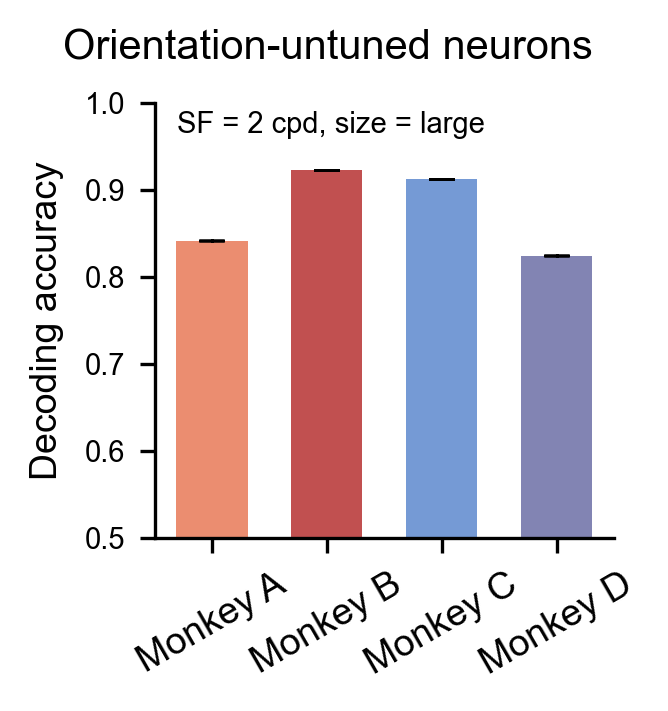

In [34]:
fig = plt.figure(figsize=(2.1,2.3),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax = sns.barplot(x='Monkey', y='r', data=r_mean_df, hue='Monkey',
                 estimator=np.mean, palette=monkey_palette,
                 errorbar=('ci', 95), capsize=.2, 
                 err_kws={'color': 'black', 'linewidth': 0.6}, linewidth=0.8)


bar_width = 0.618 
for bar in ax.patches:
    x = bar.get_x()  
    width = bar.get_width()  
    center = x + width / 2.0  
    bar.set_x(center - bar_width / 2.0)  
    bar.set_width(bar_width)  
    
ax.set_ylim(0.5,1)

ax.text(-0.2, 1.1, 'Orientation-untuned neurons', transform=ax.transAxes, size=sub_title_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding accuracy', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, 4, 1)]
x_label_name = Monkey_name
ax.set_xticks(x_label) 
ax.set_xticklabels(x_label_name, rotation=30) 

ax.text(0.05, 0.95, 'SF = 2 cpd, size = large', transform=ax.transAxes, fontsize=legend_size, ha='left', va='center') 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(left=.24, bottom=0.25, right=0.97, top=0.88) 
save_path = os.path.join(main_dir, 'decoding_accuracy_4monkeys.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# OSI distribution

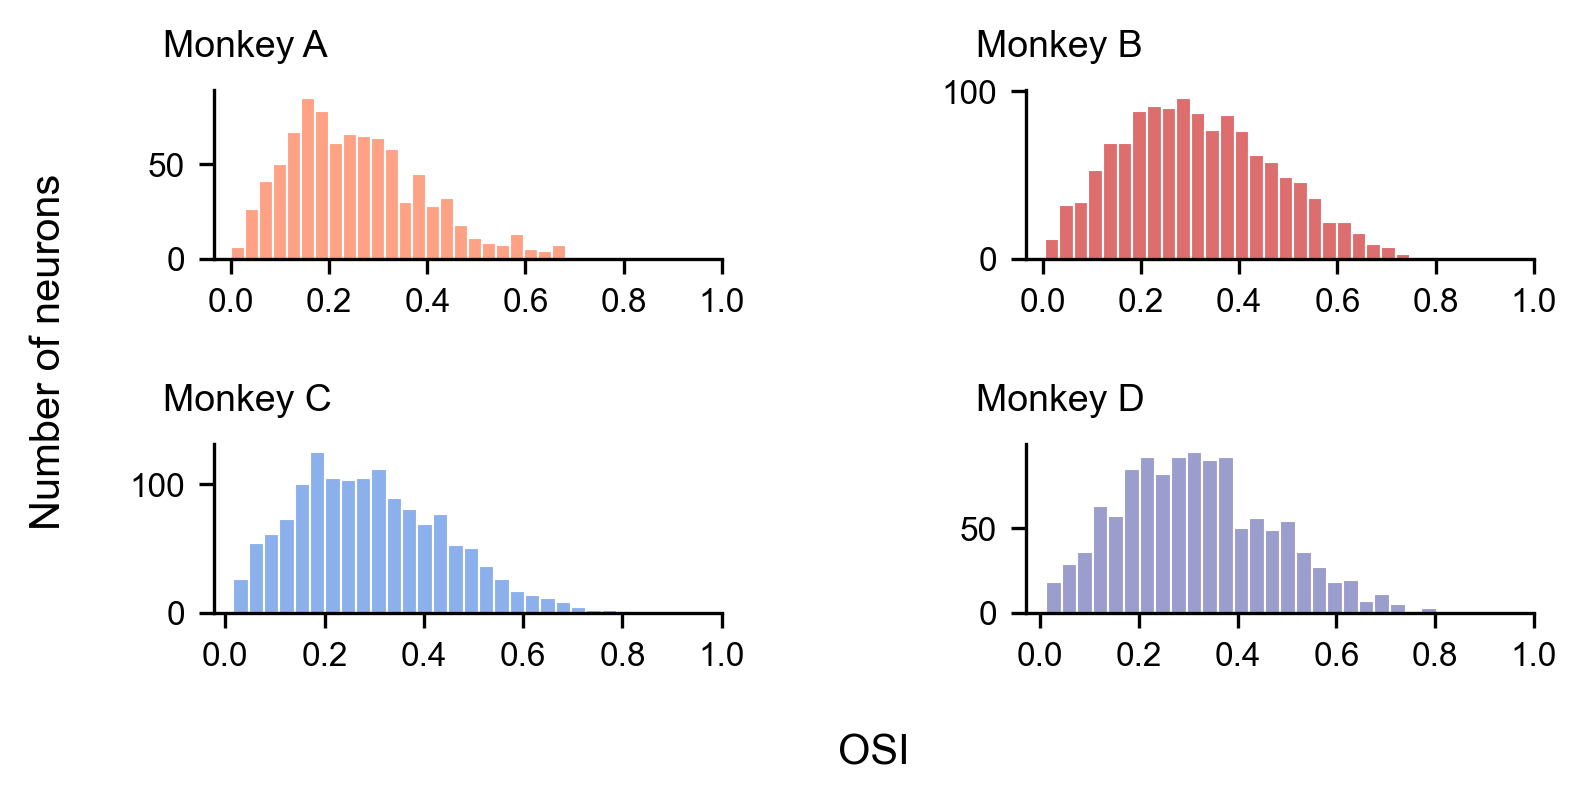

In [170]:
fig = plt.figure(figsize=(5.5,2.6),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    
    monkey_path = Monkey_path_list[monkey_id]
    data_path = os.path.join(monkey_path, 'results0_basic_info/cell_osi_groups.mat', )
    osi_groups = loadmat_data(data_path)
    osi = osi_groups[:, the_specific_group]
    ax=fig.add_subplot(2, 2, monkey_id+1)
    
    sns.histplot(data = osi,bins=25, color=monkey_palette[monkey_id], edgecolor='white', ax=ax)
    
    
    ax.set_xlabel('', fontsize=label_size+1)
    ax.set_ylabel('', fontsize=label_size+1)

    
    ax.tick_params(axis='x', labelsize=tick_size+1)
    ax.tick_params(axis='y', labelsize=tick_size+1)

    x_label = np.arange(0,  1.1, 0.2)
    ax.set_xticks(x_label)
    x_label_name = np.round(x_label, 1)
    ax.set_xticklabels(x_label_name, rotation=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.1, 1.2, f'{Monkey_name[monkey_id]}', transform=ax.transAxes, size=label_size)

left = 0.15
right = 0.95
bottom = 0.21
top = 0.88

ax.text((left+right)/2, 0.03, f'OSI', transform=fig.transFigure, fontsize=label_size+1, ha='center', va='center') 
ax.text(0.05, (bottom+top)/2, f'Number of neurons', transform=fig.transFigure, fontsize=label_size+1, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.6, hspace=1.1) 
save_path = os.path.join(supple_dir, 'OSI_distribution.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


# Decoding accuracy of different osi groups (draw together)

./Monkey_A/results1_pre_all_40
./Monkey_B/results1_pre_all_40
./Monkey_C/results1_pre_all_40
./Monkey_D/results1_pre_all_40


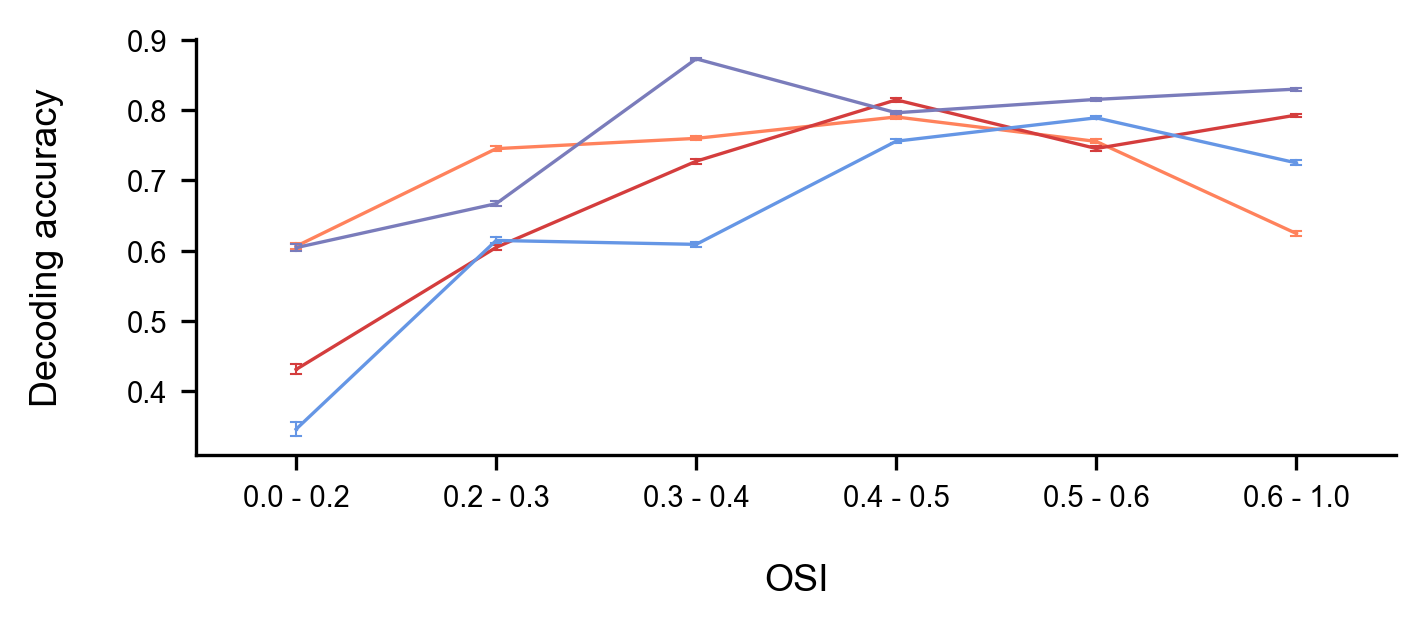

In [210]:

r_mean_all = []
name_all = []
monkey_all = []
for monkey_id in range(len(Monkey_path_list)):
    monkey_path = Monkey_path_list[monkey_id]
    main_path = os.path.join(monkey_path, 'results1_pre_all_40')
    print(main_path)
    file_lists =natsorted([d for d in os.listdir(main_path) if d.startswith("cell")])
    name_key_list = []
    pattern = r"(\d+\.\d+)"   

    for i, file_dir in enumerate(file_lists):
        
        file_path = os.path.join(main_path,file_dir, 'r_mean_rounds_all_groups_non_ori.mat')
        r_mean_all_group = loadmat_data(file_path)
        r_mean = r_mean_all_group[:, the_specific_group]
        
        numbers = re.findall(pattern, file_dir)
        name_key = numbers[0] + ' - ' + numbers[1]
        # print(name_key)
        name_key_list.append(name_key)
        name = [name_key] * len(r_mean)
        
        monkey = [Monkey_name[monkey_id]]  * len(r_mean)
        
        r_mean_all.extend(r_mean)
        name_all.extend(name)
        monkey_all.extend(monkey)
        
r_mean_rounds_df = pd.DataFrame(columns=['OSI ', 'r', 'Monkey'], index=None)
r_mean_rounds_df['OSI'] = name_all
r_mean_rounds_df['r'] = r_mean_all
r_mean_rounds_df['Monkey'] = monkey_all


fig = plt.figure(figsize=(5,2.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax = sns.pointplot(
    data=r_mean_rounds_df, x="OSI", y="r", hue='Monkey',
    palette=monkey_palette,
    
    estimator=np.mean,
    errorbar=('ci', 95),
    err_kws={'linewidth': 0.5},
    capsize=0.05,
    markersize=0.3,
    linewidth = 0.8,

    legend=False
)

ax.set_xlabel('', fontsize=label_size)
ax.set_ylabel('Decoding accuracy', fontsize=label_size, labelpad=15)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
x_label = [i for i in range(0, len(name_key_list), 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(name_key_list, rotation=0) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


left = 0.18
right = 0.98
bottom = 0.25
top = 0.88
ax.text((left+right)/2, 0.06, f'OSI', transform=fig.transFigure, fontsize=label_size, ha='center', va='center')
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top) 
save_path = os.path.join(supple_dir, 'OSI_decoding_acc.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

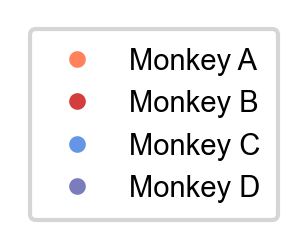

In [203]:
fig_legend = plt.figure(figsize=(1,0.8),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
ax = fig_legend.gca()
ax.axis('off')


alpha = 1
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=monkey_palette[0], markersize=5, label='Monkey A' ,alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=monkey_palette[1], markersize=5, label='Monkey B', alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=monkey_palette[2], markersize=5, label='Monkey C', alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=monkey_palette[3], markersize=5, label='Monkey D', alpha=alpha),
]



fig_legend.legend(
    handles=legend_elements, loc='center', frameon=True, fontsize=tick_size, 
    ncol=1, 
    borderpad=0.6, 
)
save_path = os.path.join(supple_dir, 'OSI_decoding_acc_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Stability of Different SFs (heatmap)

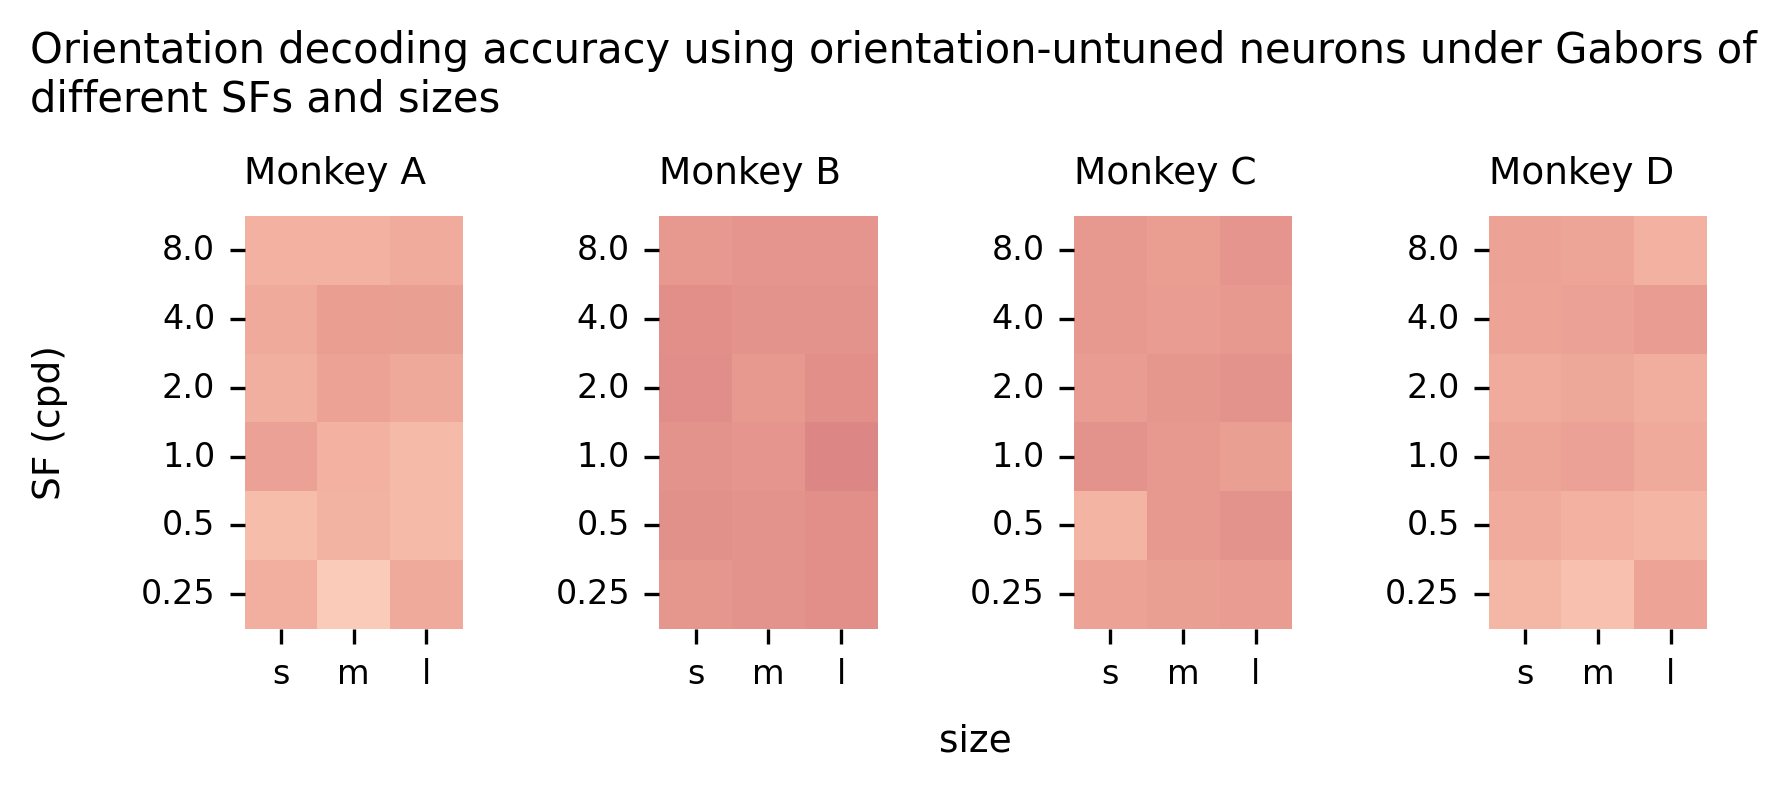

In [87]:
fig = plt.figure(figsize=(6.5,2.5),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
plt.style.use('default')
for monkey_id, monkey_name in enumerate(Monkey_name):
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/ICC_r_p_non_ori.mat')
    ICC_r_all_cell = np.squeeze(loadmat_data(data_path))[0]
    
    monkey_path = Monkey_old_path_list[monkey_id]
    data_path = os.path.join(monkey_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
    r_mean_all_group = np.mean(loadmat_data(data_path),axis=0)
    r_mean_all_group = r_mean_all_group.reshape((-1,3), order='C')
    r_mean_all_group_flip = np.flip(r_mean_all_group, axis=0)
    
    ax=fig.add_subplot(1, 4, monkey_id+1)
    h=sns.heatmap(r_mean_all_group_flip, cmap='coolwarm',vmin=0, vmax=1, alpha=0.6, ax=ax, cbar=False)
    ax.set_xlabel('',fontsize=label_size)
    ax.set_ylabel('',fontsize=label_size)

    x_label = np.arange(0.5,2.6,1)
    ax.set_xticks(x_label)
    x_label_name = spatial_size
    ax.set_xticklabels(x_label_name, rotation=0)

    y_label_name = np.flip(np.array([0.25, 0.5, 1, 2, 4, 8]))
    y_label = np.arange(0.5,len(y_label_name),1)
    ax.set_yticks(y_label)
    ax.set_yticklabels(y_label_name, rotation =0)
    ax.tick_params(axis='x', labelsize=tick_size+1)
    ax.tick_params(axis='y', labelsize=tick_size+1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if monkey_id == 0:
        ax.text(0.04, 0.88, 'Orientation decoding accuracy using orientation-untuned neurons under Gabors of\ndifferent SFs and sizes', transform= fig.transFigure, size=sub_title_size)
    ax.text(0, 1.08, monkey_name, transform=ax.transAxes, size=label_size)

left = 0.15
right = 0.9
bottom = 0.19
top = 0.74


ax.text((left+right)/2, 0.04, f'size', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.05, (bottom+top)/2, f'SF (cpd)', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.9, hspace=0.6) 
save_path = os.path.join(main_dir, 'decoding_accuracy_all_groups_heatmap.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

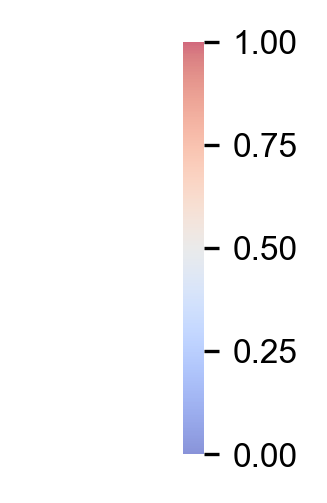

In [88]:
fig= plt.figure(figsize=(0.5, 2.5),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax_cb = plt.gca()
ax_cb.axis('off')
ax_cb.tick_params(axis='both', which='both', length=0)
ax_cb.set_xticklabels('')
ax_cb.set_yticklabels('')

cb = h.figure.colorbar(h.collections[0], ax=ax_cb,shrink=1, pad=0.5, location='right')

y_ticks = np.arange(0, 1.01, 0.25)  
cb.ax.yaxis.set_ticks(y_ticks)  
cb.ax.yaxis.set_ticklabels([f'{tick:.2f}' for tick in y_ticks])  
cb.ax.yaxis.set_tick_params(labelsize=tick_size+1)
cb.outline.set_visible(False) 


left = -0.9
right = 0.3
bottom = 0.19
top = 0.74
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.9, hspace=0.6) 
save_path = os.path.join(main_dir, 'decoding_accuracy_all_groups_heatmap_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


# chi-sq and weight scatter plot

In [54]:
p_list = []
for monkey_id, Monkey_old_path in enumerate(Monkey_old_path_list):
    data_path = os.path.join(Monkey_old_path, 'results4_explain/ChiSq_weights_relationship/p_weights_chisq_non_ori_fdr.mat')
    p_all = np.squeeze(loadmat_data(data_path))
    p_list.append(p_all[the_specific_group])

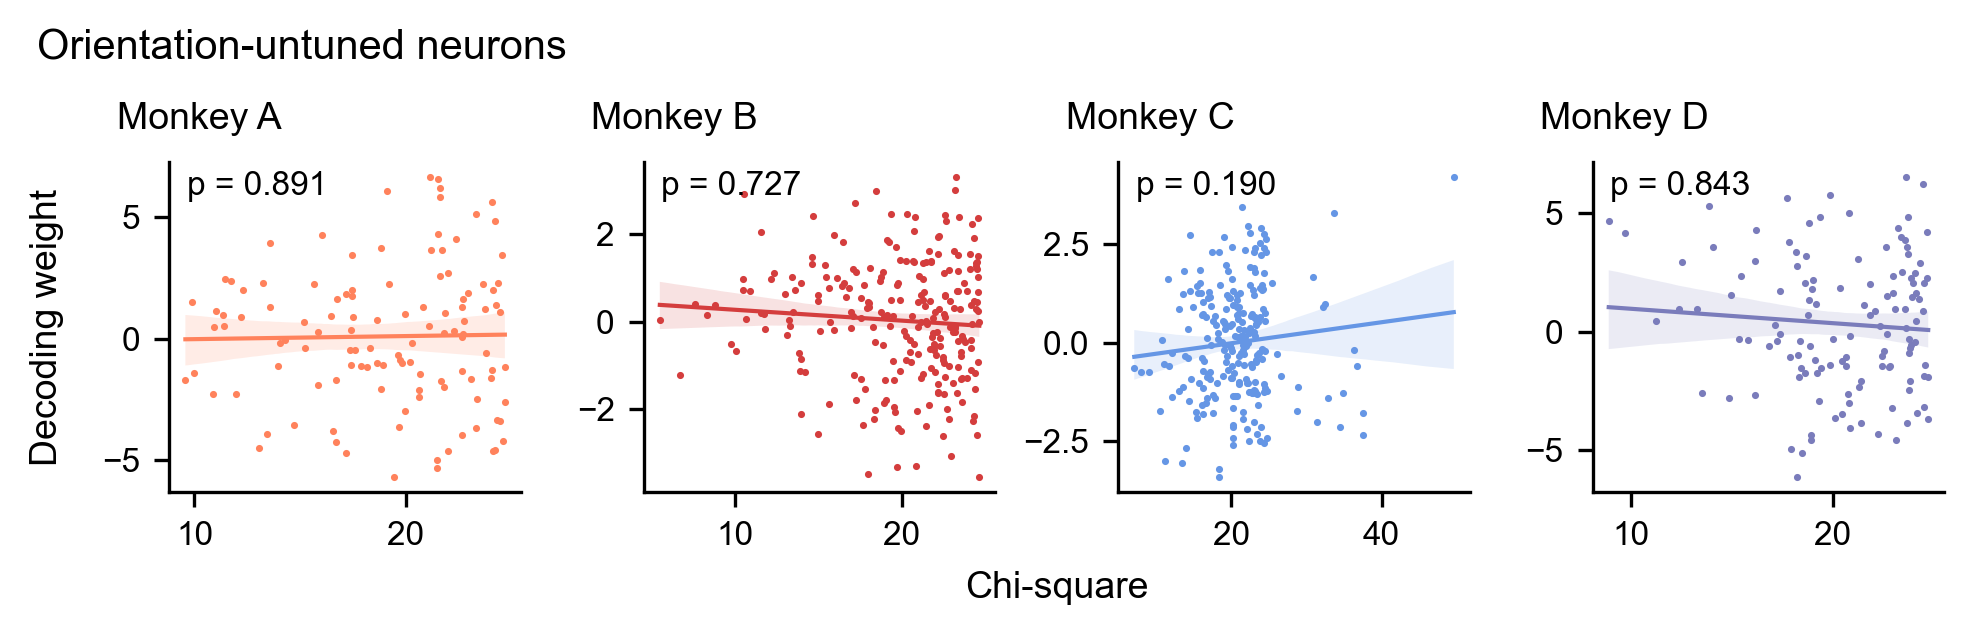

In [89]:
fig = plt.figure(figsize=(6.8,2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = Monkey_old_path_list[monkey_id]
    data_path = os.path.join(Monkey_origin_path_list[monkey_id], 'Y1_AnovaChiSquareStatistic.mat')
    Chi_sq = np.squeeze(loadmat_data(data_path))
    
    ori_cell= np.squeeze(loadmat_data(os.path.join(monkey_path, 'ori_cell.mat')))
    non_ori_idx = np.where(ori_cell==0)[0]
    Chi_sq_non = Chi_sq[non_ori_idx]
    
    
    data_path = os.path.join(monkey_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/all_groups_1000_rounds_median_non_ori_results.mat')
    all_groups_1000_rounds_median_results = np.squeeze(loadmat_data(data_path))
    the_specific_group_results = all_groups_1000_rounds_median_results[the_specific_group]
    r_mean = np.squeeze(the_specific_group_results[1])
    p_mean = np.squeeze(the_specific_group_results[2])
    MAE_array = np.squeeze(the_specific_group_results[5])
    MAE_mean = np.mean(MAE_array)
    predicted_all = np.squeeze(the_specific_group_results[6])
    Y_test_all = np.squeeze(the_specific_group_results[7])
    weights_best = np.squeeze(the_specific_group_results[8])
    r_chi_weights, p_chi_weights = pearsonr(Chi_sq_non, weights_best)
    p_log = np.log10(p_chi_weights)
    


    ax=fig.add_subplot(1, 4, monkey_id+1)
    sns.regplot(x=Chi_sq_non, y=weights_best, 
            scatter_kws={"s":0.5, "marker":"o", 'color':monkey_palette[monkey_id], 'alpha':1},
            line_kws={'linewidth': 1, 'color':monkey_palette[monkey_id]},
            ax=ax)

    
    ax.text(-0.15, 1.1, monkey_name, transform=ax.transAxes, size=label_size)
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size, labelpad=5)
    ax.tick_params(axis='x', labelsize=tick_size+1)
    ax.tick_params(axis='y', labelsize=tick_size+1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.05, 0.9, f'p = {p_list[monkey_id]:.3f}', transform=ax.transAxes, fontsize=legend_size+1) 
    
left = 0.1
right = 0.97
bottom = 0.2
top = 0.75
ax.text(0.035, 0.92, 'Orientation-untuned neurons', transform=fig.transFigure, size=sub_title_size)
ax.text((left+right)/2, 0.04, f'Chi-square', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.04, (bottom+top)/2, f'Decoding weight', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.35, hspace=1) 
save_path = os.path.join(main_dir, 'chi_weights_scatter.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

# weight distribution

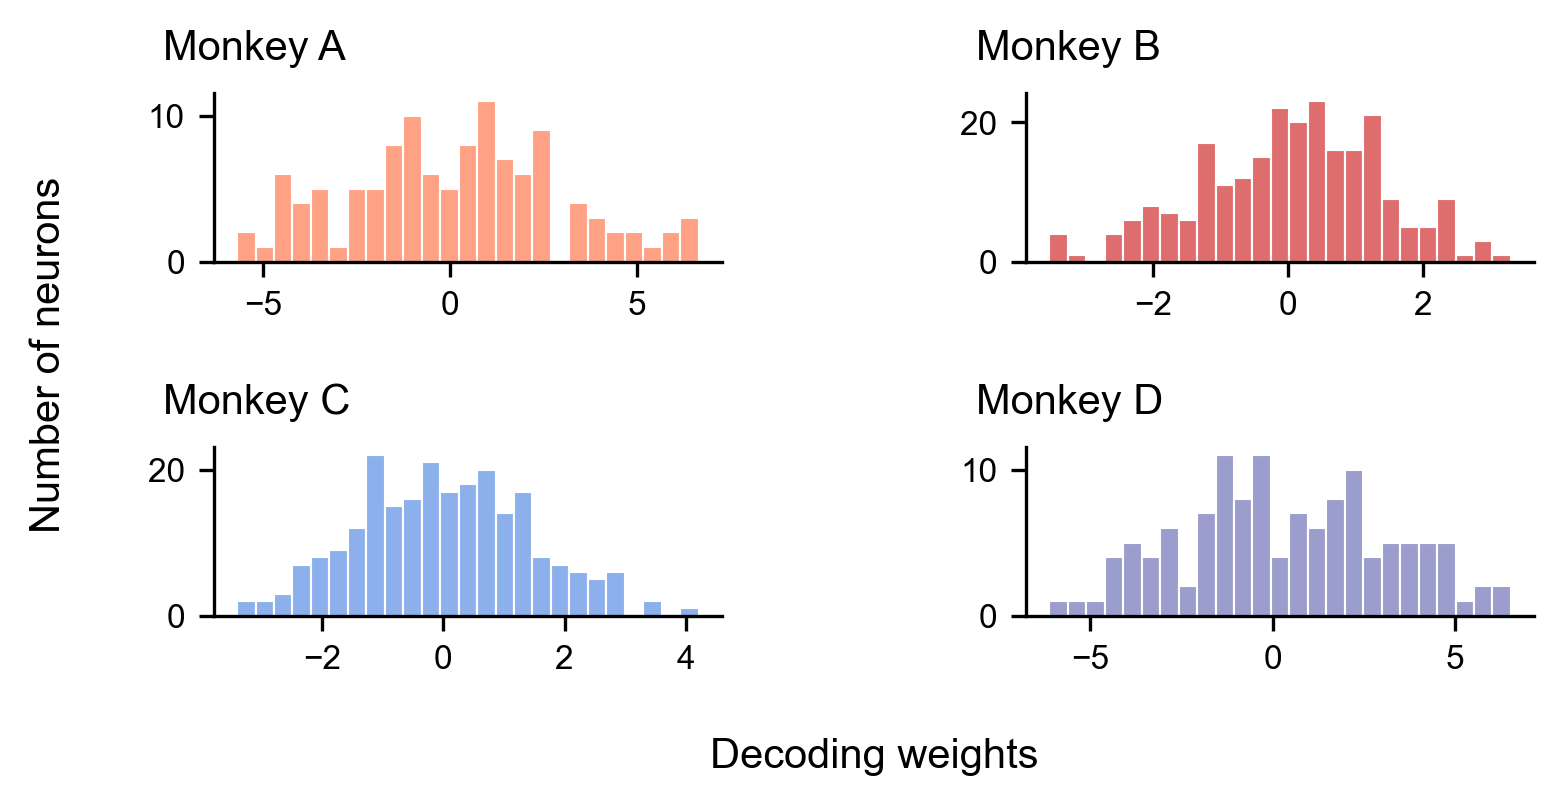

In [13]:
fig = plt.figure(figsize=(5.5, 2.6),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = Monkey_old_path_list[monkey_id]
    data_path = os.path.join(monkey_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/all_groups_1000_rounds_median_non_ori_results.mat')
    all_groups_1000_rounds_median_results = np.squeeze(loadmat_data(data_path))
    the_specific_group_results = all_groups_1000_rounds_median_results[the_specific_group]
    r_mean = np.squeeze(the_specific_group_results[1])
    p_mean = np.squeeze(the_specific_group_results[2])
    MAE_array = np.squeeze(the_specific_group_results[5])
    MAE_mean = np.mean(MAE_array)
    predicted_all = np.squeeze(the_specific_group_results[6])
    Y_test_all = np.squeeze(the_specific_group_results[7])
    weights_best = np.squeeze(the_specific_group_results[8])
    
    ax=fig.add_subplot(2, 2, monkey_id+1)
    
    sns.histplot(data = weights_best,bins=25, color=monkey_palette[monkey_id], edgecolor='white', ax=ax)
    
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size)

    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.1, 1.2, f'{Monkey_name[monkey_id]}', transform=ax.transAxes, size=label_size)


left = 0.15
right = 0.95
bottom = 0.21
top = 0.88

ax.text((left+right)/2, 0.03, f'Decoding weights', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.05, (bottom+top)/2, f'Number of neurons', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.6, hspace=1.1) 
save_path = os.path.join(supple_dir, 'Decoding_weights_distribution.tif')
plt.savefig(save_path, format='tif', dpi=300)

# The Correlation between OSI and Weights

In [223]:
MonkeyA_path = './Monkey_A'
MonkeyB_path = './Monkey_B'
MonkeyC_path = './Monkey_C'
MonkeyD_path = './Monkey_D'
Monkey_path_list = [MonkeyA_path, MonkeyB_path, MonkeyC_path, MonkeyD_path]

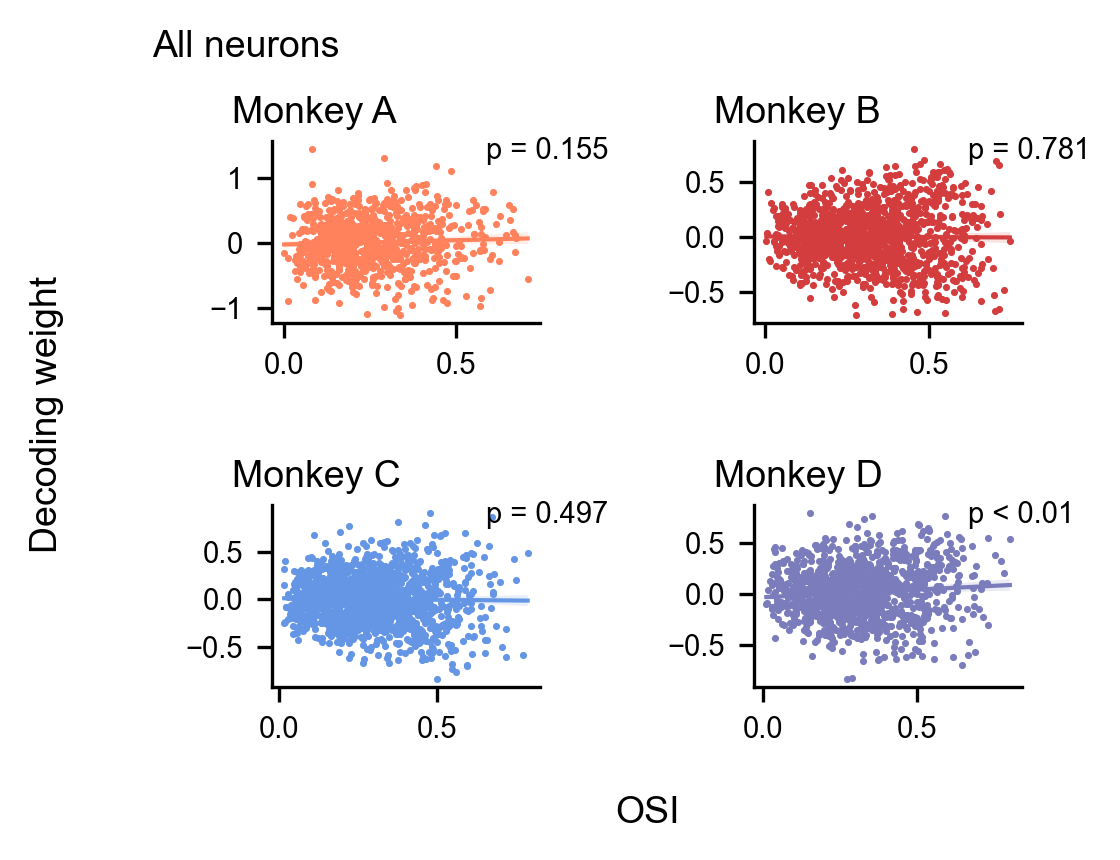

In [225]:
p_list = []
osi_list =[]
weights_list = []
fig = plt.figure(figsize=(5,2.8),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

for monkey_id in range(len(Monkey_path_list)):
    monkey = Monkey_name[monkey_id]
    monkey_path = Monkey_path_list[monkey_id]
    data_path = os.path.join(monkey_path, 'all_neurons/all_groups_rounds_median_results.mat')
    all_groups_1000_rounds_median_results = np.squeeze(loadmat_data(data_path))
    the_specific_group_results = all_groups_1000_rounds_median_results[the_specific_group]
    r_mean = np.squeeze(the_specific_group_results[1])
    p_mean = np.squeeze(the_specific_group_results[2])
    MAE_array = np.squeeze(the_specific_group_results[5])
    MAE_mean = np.mean(MAE_array)
    predicted_all = np.squeeze(the_specific_group_results[6])
    Y_test_all = np.squeeze(the_specific_group_results[7])
    weights_best = np.squeeze(the_specific_group_results[8])
    osi = np.squeeze(the_specific_group_results[9])
    r_osi_weights, p_osi_weights = pearsonr(osi, weights_best)
    p_log = np.log10(p_osi_weights)
    p_list.append(p_log)
    osi_list.extend(osi)
    weights_list.extend(weights_best)
    
    ax = fig.add_subplot(2, 2, monkey_id+1)
    sns.regplot(x=osi, y=weights_best, 
                scatter_kws={"s":0.5, "marker":"o", 'color':monkey_palette[monkey_id], 'alpha':1},
                line_kws={'linewidth': 1, 'color':monkey_palette[monkey_id]}, ax=ax)


    ax.text(-0.15, 1.1, monkey, transform=ax.transAxes, size=label_size)
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size, labelpad=5)

    
    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if monkey_id==3:
        ax.text(0.8, 0.9, f'p < 0.01', transform=ax.transAxes, fontsize=legend_size)
    else:
        ax.text(0.8, 0.9, f'p = {p_osi_weights:.3f}', transform=ax.transAxes, fontsize=legend_size) 
        
left = 0.3
right = 0.8
bottom = 0.2
top = 0.85

ax.text(0.22, 0.95, 'All neurons', transform=fig.transFigure, size=label_size)
ax.text((left+right)/2, 0.05, f'OSI', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.15, (bottom+top)/2, f'Decoding weight', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.8, hspace=1) 
save_path = os.path.join(supple_dir, 'correlation_osi_weigths.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


# The Relationship between chi-sq and other indicators

In [19]:
the_group = the_specific_group
left = 0.29 
right = 0.9
bottom = 0.1
top = 0.92
wspace=0.5
hspace=0.9
text_y= 1.07
monkey_name_y = 1.3

## The scatter plot of chi-sq and osi

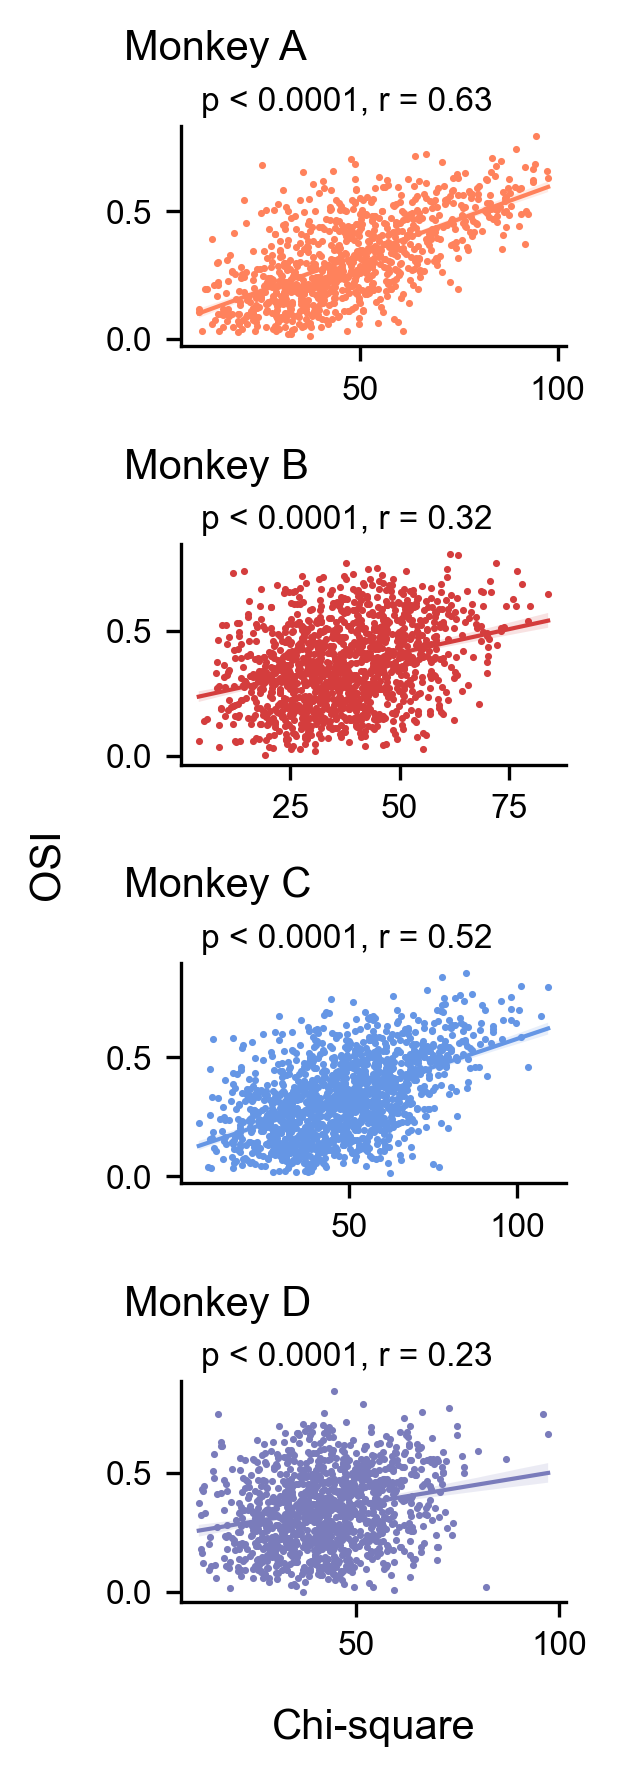

In [20]:
fig = plt.figure(figsize=(2.1,6),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = Monkey_old_path_list[monkey_id]
    
    data_path = os.path.join(Monkey_path_list[monkey_id], 'results0_basic_info/cell_chisq_groups.mat' )
    Chi_sq_groups = loadmat_data(data_path)
    Chi_sq = Chi_sq_groups[:,the_group]
    
    data_path = os.path.join(Monkey_path_list[monkey_id], 'results0_basic_info/cell_osi_groups.mat' )
    osi_groups = loadmat_data(data_path)
    osi = osi_groups[:, the_group]
    r_chi_osi, p_chi_osi = pearsonr(Chi_sq, osi)

    ax=fig.add_subplot(4, 1, monkey_id+1)

    sns.regplot(x=Chi_sq, y=osi, 
            scatter_kws={"s":0.5, "marker":"o", 'color':monkey_palette[monkey_id], 'alpha':1},
            line_kws={'linewidth': 1, 'color':monkey_palette[monkey_id]},
            ax=ax)
 
    ax.text(-0.15, monkey_name_y, monkey_name, transform=ax.transAxes, size=label_size)
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size, labelpad=5)

    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if p_chi_osi < 0.0001:
        ax.text(0.05, text_y, f'p < 0.0001, r = {r_chi_osi:.2f}', transform=ax.transAxes, fontsize=legend_size) 
    else:
        ax.text(0.05, text_y, f'p = {p_chi_osi:.4f}, r = {r_chi_osi:.2f}', transform=ax.transAxes, fontsize=legend_size) 
    

ax.text((left+right)/2, 0.03, f'Chi-square', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.08, (bottom+top)/2, f'OSI', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace) 
save_path = os.path.join(supple_dir, 'correlation_osi_chisq.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

## The scatter plot of chi-sq and cv

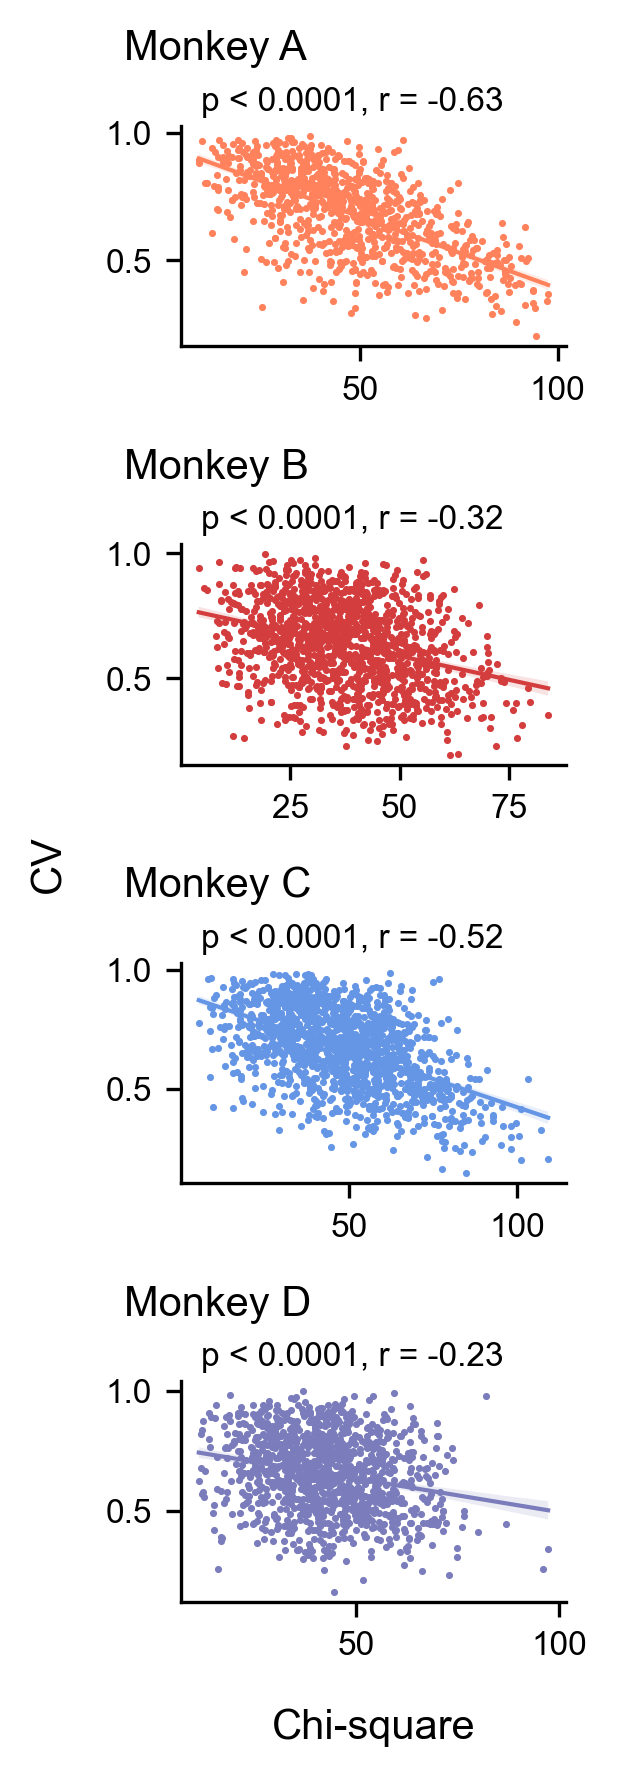

In [23]:
fig = plt.figure(figsize=(2.1,6),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = Monkey_old_path_list[monkey_id]
    
    
    data_path = os.path.join(Monkey_path_list[monkey_id], 'results0_basic_info/cell_chisq_groups.mat' )
    Chi_sq_groups = loadmat_data(data_path)
    Chi_sq = Chi_sq_groups[:,the_group]

    data_path = os.path.join(Monkey_path_list[monkey_id], 'results0_basic_info/cell_osi_groups.mat' )
    osi_groups = loadmat_data(data_path)
    osi = osi_groups[:, the_group]
    cv = 1 - osi

    r_chi_cv, p_chi_cv = pearsonr(Chi_sq, cv)

    ax=fig.add_subplot(4, 1, monkey_id+1)

    sns.regplot(x=Chi_sq, y=cv, 
            scatter_kws={"s":0.5, "marker":"o", 'color':monkey_palette[monkey_id], 'alpha':1},
            line_kws={'linewidth': 1, 'color':monkey_palette[monkey_id]},
            ax=ax)

    ax.text(-0.15, monkey_name_y, monkey_name, transform=ax.transAxes, size=label_size)
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size, labelpad=5)

    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if p_chi_cv < 0.0001:
        ax.text(0.05, text_y, f'p < 0.0001, r = {r_chi_cv:.2f}', transform=ax.transAxes, fontsize=legend_size) 
    else:
        ax.text(0.05, text_y, f'p = {p_chi_cv:.4f}, r = {r_chi_cv:.2f}', transform=ax.transAxes, fontsize=legend_size) 

ax.text((left+right)/2, 0.03, f'Chi-square', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.08, (bottom+top)/2, f'CV', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace) 
save_path = os.path.join(supple_dir, 'correlation_cv_chisq.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

## The scatter plot of chi-sq and OPratio

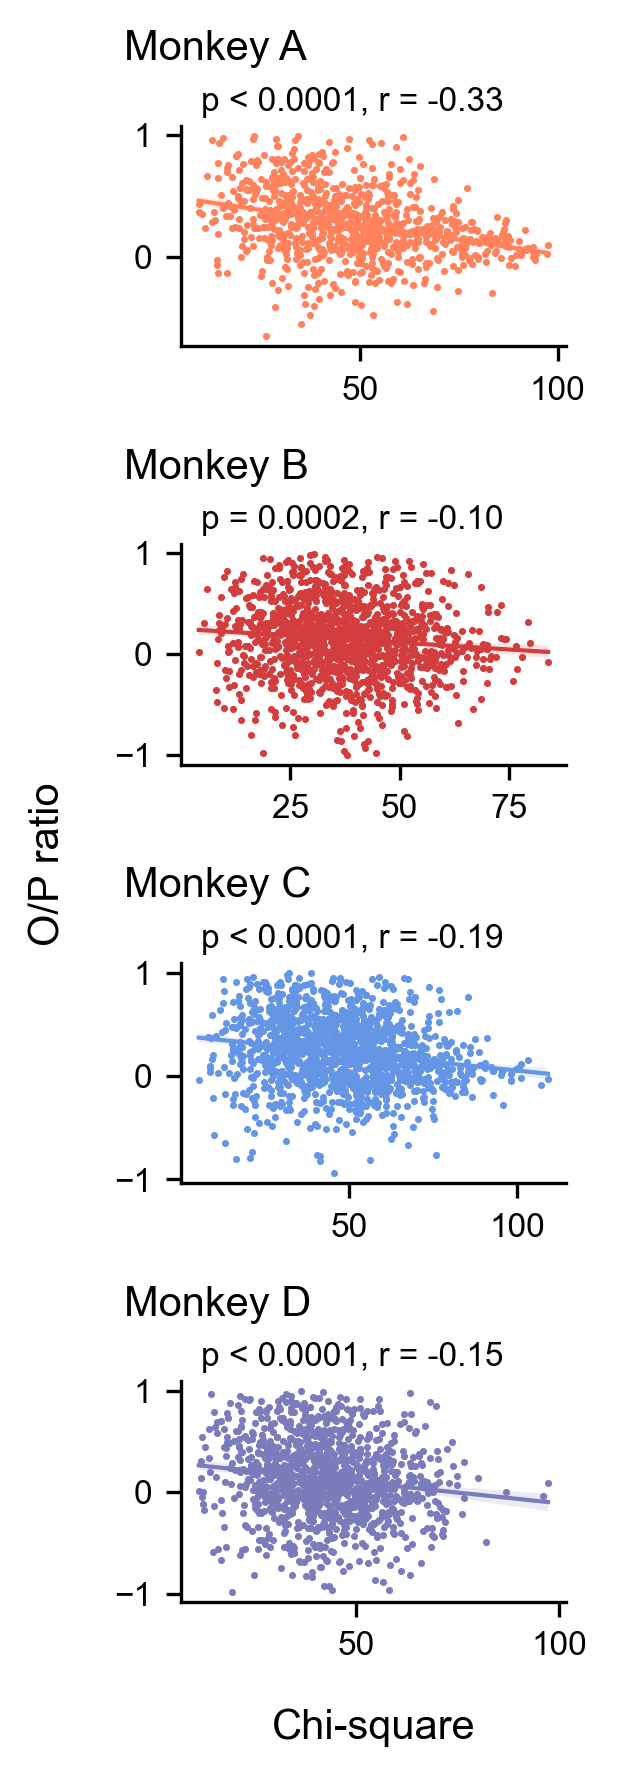

In [24]:
fig = plt.figure(figsize=(2.1,6),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = Monkey_old_path_list[monkey_id]
    
    
    data_path = os.path.join(Monkey_path_list[monkey_id], 'results0_basic_info/cell_chisq_groups.mat' )
    Chi_sq_groups = loadmat_data(data_path)
    Chi_sq = Chi_sq_groups[:,the_group]
    
    data_path = os.path.join(Monkey_path_list[monkey_id], 'results0_basic_info/cell_OPratio_groups.mat' )
    OPratio_groups = loadmat_data(data_path)
    OPratio = OPratio_groups[:, the_group]
    
    r_chi_OPratio, p_chi_OPratio = pearsonr(Chi_sq, OPratio)

    ax=fig.add_subplot(4, 1, monkey_id+1)

    sns.regplot(x=Chi_sq, y=OPratio, 
            scatter_kws={"s":0.5, "marker":"o", 'color':monkey_palette[monkey_id], 'alpha':1},
            line_kws={'linewidth': 1, 'color':monkey_palette[monkey_id]},
            ax=ax)

    ax.text(-0.15, monkey_name_y, monkey_name, transform=ax.transAxes, size=label_size)
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size, labelpad=5)

    
    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)


    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if p_chi_OPratio < 0.0001:
        ax.text(0.05, text_y, f'p < 0.0001, r = {r_chi_OPratio:.2f}', transform=ax.transAxes, fontsize=legend_size) 
    else:
        ax.text(0.05, text_y, f'p = {p_chi_OPratio:.4f}, r = {r_chi_OPratio:.2f}', transform=ax.transAxes, fontsize=legend_size) 
    
ax.text((left+right)/2, 0.03, f'Chi-square', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.08, (bottom+top)/2, f'O/P ratio', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace) 
save_path = os.path.join(supple_dir, 'correlation_op_chisq.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# The Influence of Neuron Count on Decoding

In [75]:
def get_cell_num_df(data_path, neuron_key = 'Orientation-tuned neurons'):
    cell_num_res = np.squeeze(loadmat_data(data_path))

    cell_number = np.squeeze(np.array(get_specified_1D_item(cell_num_res, 0)))
    r_mean_diff_cell_num = np.squeeze(np.array(get_specified_1D_item(cell_num_res, 1)))
    p_mean_diff_cell_num = np.squeeze(np.array(get_specified_1D_item(cell_num_res, 2)))
    mae_mean_diff_cell_num = np.squeeze(np.array(get_specified_1D_item(cell_num_res, 3)))


    cell_num_influence_df = pd.DataFrame(columns=['Number of neurons', 'r', 'p', 'mae', 'Neuron Type'])   # Empty DataFrame
    number_df = np.zeros(r_mean_diff_cell_num.size)
    r_mean_df = np.zeros(r_mean_diff_cell_num.size)
    p_mean_df = np.zeros(r_mean_diff_cell_num.size)
    mae_mean_df = np.zeros(r_mean_diff_cell_num.size)
    rounds = r_mean_diff_cell_num.shape[1]


    for i,num in enumerate(cell_number):
        r_mean_num = r_mean_diff_cell_num[i]
        p_mean_num = p_mean_diff_cell_num[i]
        mae_mean_num = mae_mean_diff_cell_num[i]
        number_array = np.ones_like(r_mean_num) * num
        number_df[i*rounds:(i+1)*rounds] = number_array
        r_mean_df[i*rounds:(i+1)*rounds] = r_mean_num
        p_mean_df[i*rounds:(i+1)*rounds] = p_mean_num
        mae_mean_df[i*rounds:(i+1)*rounds] = mae_mean_num
    number_df = number_df.astype(int)
    cell_num_influence_df['Number of neurons'] = number_df
    cell_num_influence_df['r'] = r_mean_df
    cell_num_influence_df['p'] = p_mean_df
    cell_num_influence_df['mae'] = mae_mean_df
    neuron_sring_df = np.squeeze(np.array([neuron_key] * r_mean_diff_cell_num.size))
    cell_num_influence_df['Neuron Type'] = neuron_sring_df
    return cell_num_influence_df, cell_number

In [76]:
MonkeyA_path = './Monkey_A'
MonkeyB_path = './Monkey_B'
MonkeyC_path = './Monkey_C'
MonkeyD_path = './Monkey_D'

MonkeyA_old_path = '../MA/Analysis'
MonkeyB_old_path = '../MB_CC/Analysis'
MonkeyC_old_path = '../MC_CC/Analysis'
MonkeyD_old_path = '../MD/Analysis'

Monkey_path_list = [MonkeyA_path, MonkeyB_path, MonkeyC_path, MonkeyD_path]
Monkey_old_path_list = [MonkeyA_old_path, MonkeyB_old_path, MonkeyC_old_path, MonkeyD_old_path]
ori_mat_name = 'results3_cell_number/ori_cell/ori_cell_number_influence_group_12_repeat_100.mat'
non_ori_mat_name = 'results3_cell_number/non_ori_cell/non_ori_cell_number_influence_group_12_repeat_100.mat'


In [77]:
r_ori = []
r_non_ori = []
mae_ori = []
mae_non_ori = []
for monkey_id in range(len(Monkey_name)):
    ori_cell= np.squeeze(loadmat_data(os.path.join(Monkey_old_path_list[monkey_id], 'ori_cell.mat')))
    data_path = os.path.join(Monkey_path_list[monkey_id], ori_mat_name)
    ori_df, ori_cell_number = get_cell_num_df(data_path, neuron_key='Orientation-tuned neurons')
    data_path = os.path.join(Monkey_path_list[monkey_id], non_ori_mat_name)
    non_ori_df, non_ori_cell_number = get_cell_num_df(data_path, neuron_key='Orientation-untuned neurons')

    NorOriNum = len(ori_cell)-np.sum(ori_cell)
    NorOriNum_index= np.where(non_ori_cell_number==NorOriNum)[0].item()
    NorOriNum_r_ori = ori_df.groupby('Number of neurons')['r'].median().get(NorOriNum, 'Not Found')
    NorOriNum_r_non_ori = non_ori_df.groupby('Number of neurons')['r'].median().get(NorOriNum, 'Not Found')
    NorOriNum_mae_ori = ori_df.groupby('Number of neurons')['mae'].median().get(NorOriNum, 'Not Found')
    NorOriNum_mae_non_ori = non_ori_df.groupby('Number of neurons')['mae'].median().get(NorOriNum, 'Not Found')
    print(f'{Monkey_name[monkey_id]}, per: {NorOriNum_r_non_ori/NorOriNum_r_ori}')
    r_ori.append(NorOriNum_r_ori)
    r_non_ori.append(NorOriNum_r_non_ori)
    mae_ori.append(NorOriNum_mae_ori)
    mae_non_ori.append(NorOriNum_mae_non_ori)

Monkey A, per: 0.9104908447101254
Monkey B, per: 0.9703249532049764
Monkey C, per: 0.9620395794863995
Monkey D, per: 0.9388289598450027


In [78]:
print(f'r_ori: {np.mean(r_ori)} ± {np.std(r_ori)}')
print(f'r_non_ori: {np.mean(r_non_ori)} ± {np.std(r_non_ori)}')
print(f'per: {np.mean(r_non_ori)/np.mean(r_ori)}')

r_ori: 0.9265134320044492 ± 0.02909307744410347
r_non_ori: 0.8762634071162134 ± 0.04231667862710748
per: 0.9457643859738512


In [79]:
print(f'mae_ori: {np.mean(mae_ori)} ± {np.std(mae_ori)}')
print(f'mae_non_ori: {np.mean(mae_non_ori)} ± {np.std(mae_non_ori)}')
print(f'per: {np.mean(mae_ori)/np.mean(mae_non_ori)}')

mae_ori: 15.14631249684937 ± 2.7501153148282786
mae_non_ori: 19.764137242430145 ± 3.160612075302465
per: 0.76635333539037


## r

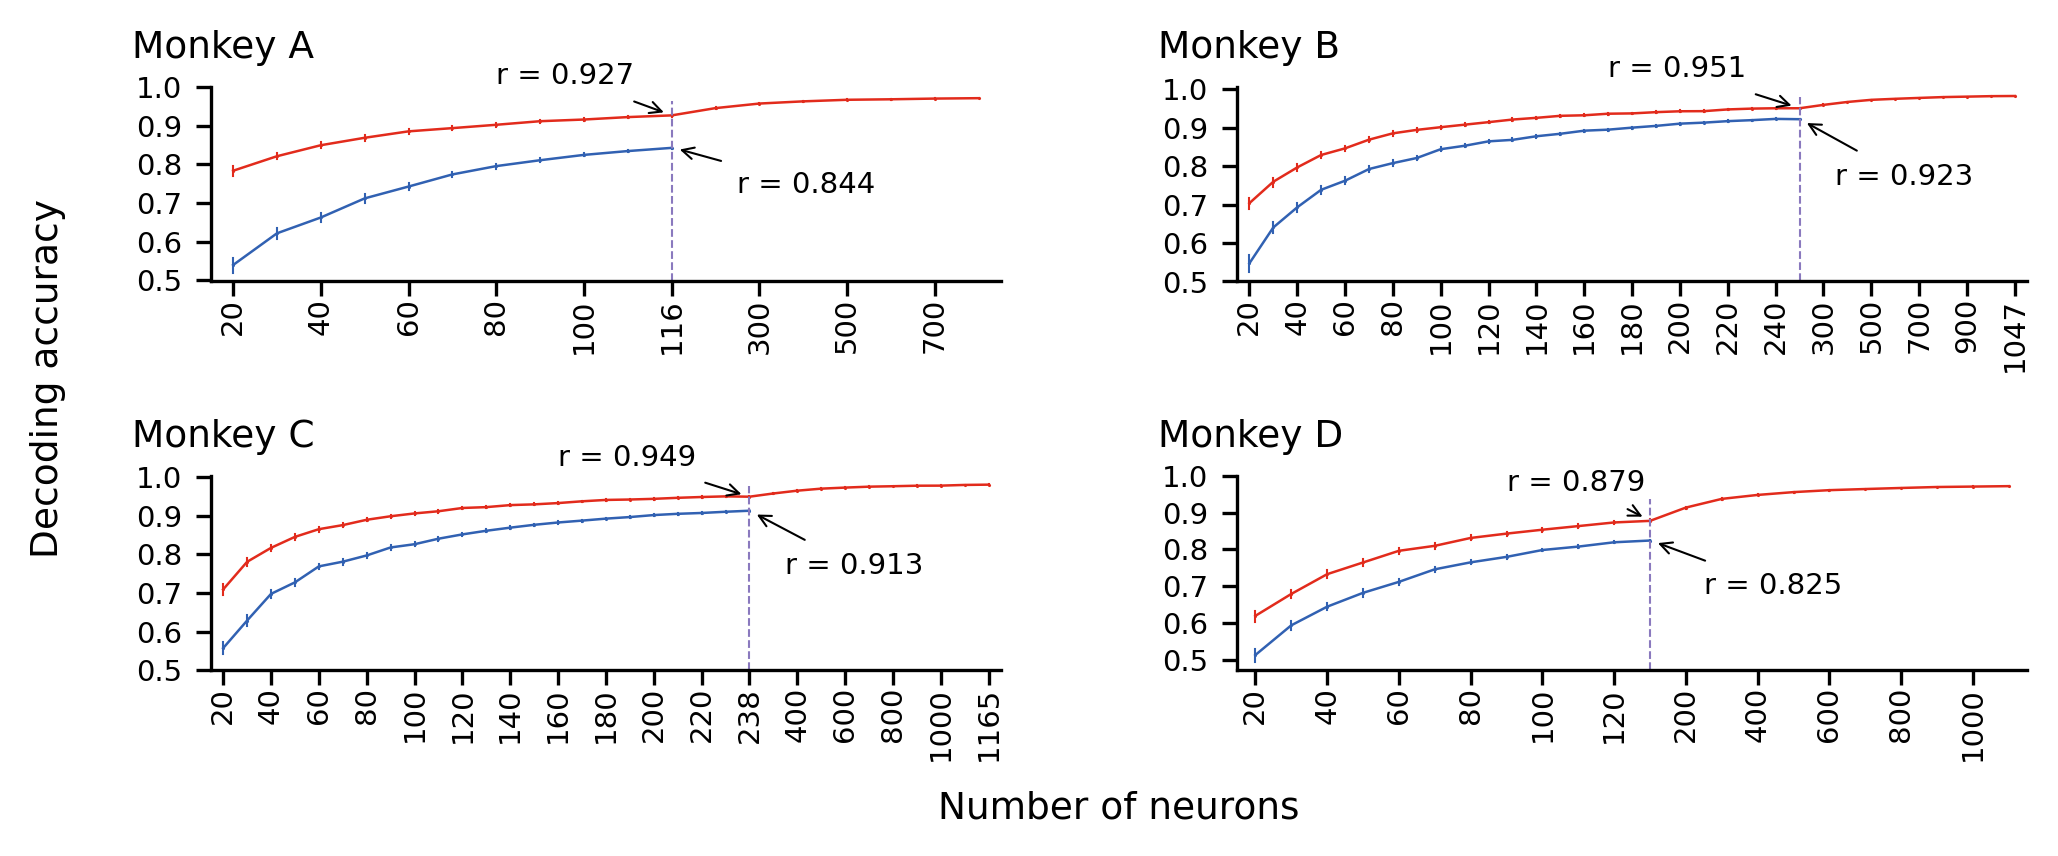

In [96]:
x_tick_rotation = 90
title_y = 0.9
fig = plt.figure(figsize=(6.8,2.7),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
plt.style.use('default')
for monkey_id in range(len(Monkey_name)):
    ori_cell= np.squeeze(loadmat_data(os.path.join(Monkey_old_path_list[monkey_id], 'ori_cell.mat')))
    data_path = os.path.join(Monkey_path_list[monkey_id], ori_mat_name)
    ori_df, ori_cell_number = get_cell_num_df(data_path, neuron_key='Orientation-tuned neurons')
    data_path = os.path.join(Monkey_path_list[monkey_id], non_ori_mat_name)
    non_ori_df, non_ori_cell_number = get_cell_num_df(data_path, neuron_key='Orientation-untuned neurons')

    NorOriNum = len(ori_cell)-np.sum(ori_cell)
    NorOriNum_index= np.where(non_ori_cell_number==NorOriNum)[0].item()
    NorOriNum_r_ori = ori_df.groupby('Number of neurons')['r'].median().get(NorOriNum, 'Not Found')
    NorOriNum_r_non_ori = non_ori_df.groupby('Number of neurons')['r'].median().get(NorOriNum, 'Not Found')
    NorOriNum_mae_ori = ori_df.groupby('Number of neurons')['mae'].median().get(NorOriNum, 'Not Found')
    NorOriNum_mae_non_ori = non_ori_df.groupby('Number of neurons')['mae'].median().get(NorOriNum, 'Not Found')

    cell_num_influence_df = pd.concat([ori_df, non_ori_df],axis=0)


    ## r
    ax=fig.add_subplot(2, 2, monkey_id+1)
    sns.pointplot(
        data=cell_num_influence_df, x="Number of neurons", y="r", hue='Neuron Type',
        palette=neuron_color,
        
        estimator=np.mean,
        errorbar=('ci', 95),
        err_kws={'linewidth': 0.5},
        capsize=0,
        markersize=0.3,
        linewidth = 0.6,
        
        ax=ax
    )

    ax.legend().set_visible(False)
    ax.set_xlabel('',fontsize=label_size)
    ax.set_ylabel('',fontsize=label_size)

    x_label = np.arange(ori_cell_number.size)
    x_label = x_label[::2]
    x_label_name = ori_cell_number
    x_label_name = x_label_name[::2]
    ax.set_xticks(x_label)
    ax.set_xticklabels(x_label_name, rotation=x_tick_rotation)

    y_label = np.arange(0.5,1.05,0.1)
    y_label = np.round(y_label, 2)
    ax.set_yticks(y_label)
    ax.set_yticklabels(y_label, rotation =0)
    ax.tick_params(axis='x', labelsize=tick_size, pad=0.5)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_title(Monkey_name[monkey_id], loc='left', fontsize=label_size, y=0.9)
    ax.text(-0.1, 1.15, f'{Monkey_name[monkey_id]}', transform=ax.transAxes, size=label_size)

    ax.axvline(NorOriNum_index,ymin=0, ymax=NorOriNum_r_ori, color='#8A79BE', linewidth=0.5, linestyle='--')

    if monkey_id == 0 or monkey_id ==3:
        ax.annotate(f'r = {NorOriNum_r_ori:.3f}', xy=(NorOriNum_index, NorOriNum_r_ori), xytext=(NorOriNum_index-4, NorOriNum_r_ori+.08),
        arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
        fontsize=legend_size,
        color = 'black')
    else:
        ax.annotate(f'r = {NorOriNum_r_ori:.3f}', xy=(NorOriNum_index, NorOriNum_r_ori), xytext=(NorOriNum_index-8, NorOriNum_r_ori+.08),
        arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
        fontsize=legend_size,
        color = 'black')


    ax.annotate(f'r = {NorOriNum_r_non_ori:.3f}', xy=(NorOriNum_index, NorOriNum_r_non_ori), xytext=(NorOriNum_index+1.5, NorOriNum_r_ori-.2),
    arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
    fontsize=legend_size,
    color = 'black')
    
left = 0.1
right = 0.99
bottom = 0.2
top = 0.92

ax.text((left+right)/2, 0.03, f'Number of neurons', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.02, (bottom+top)/2, f'Decoding accuracy', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.3, hspace=1) 
save_path = os.path.join(main_dir, 'decoding_accuracy_different_number_neurons.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


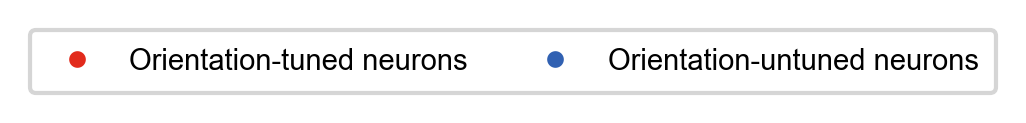

In [95]:
fig_legend = plt.figure(figsize=(4,0.25),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
ax = fig_legend.gca()
ax.axis('off')


alpha = 1
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ori_color, markersize=5, label='Orientation-tuned neurons' ,alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=non_ori_color, markersize=5, label='Orientation-untuned neurons', alpha=alpha),
]



fig_legend.legend(
    handles=legend_elements, loc='center', frameon=True, fontsize=tick_size, 
    ncol=2,  
    borderpad=0.6, 
    
    
    
)
save_path = os.path.join(main_dir, 'decoding_accuracy_different_number_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

## mae

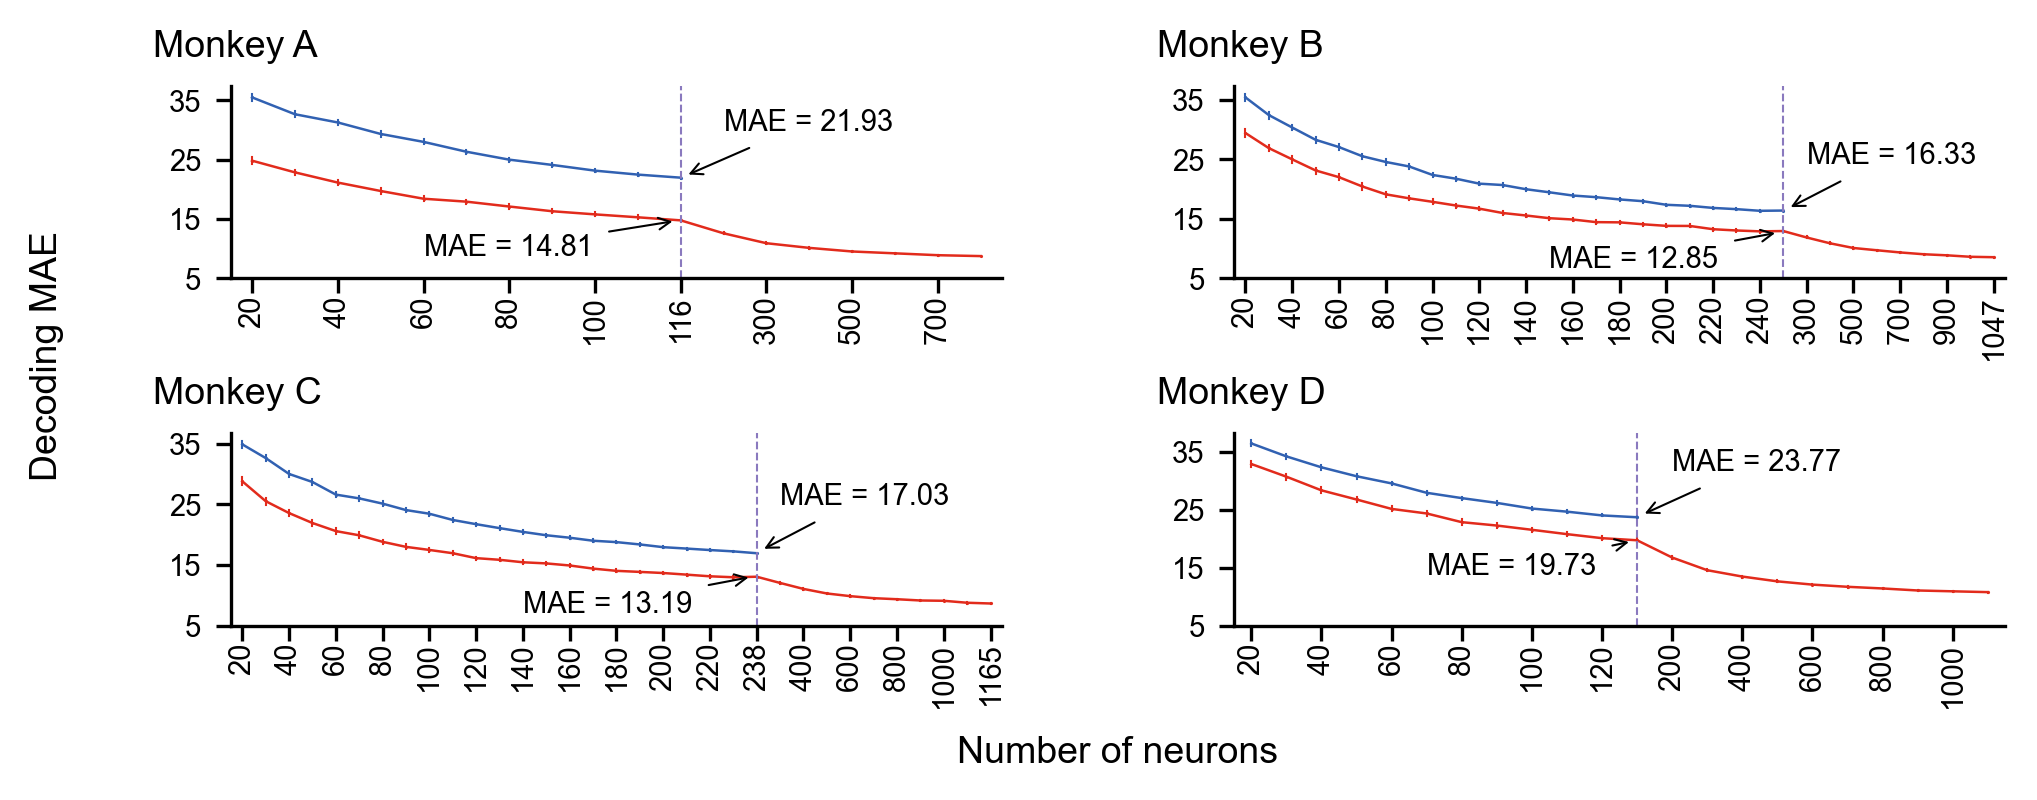

In [228]:
x_tick_rotation = 90
title_y = 0.9
fig = plt.figure(figsize=(6.8,2.5),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

for monkey_id in range(len(Monkey_name)):
    ori_cell= np.squeeze(loadmat_data(os.path.join(Monkey_old_path_list[monkey_id], 'ori_cell.mat')))
    data_path = os.path.join(Monkey_path_list[monkey_id], ori_mat_name)
    ori_df, ori_cell_number = get_cell_num_df(data_path, neuron_key='Orientation-tuned neurons')
    data_path = os.path.join(Monkey_path_list[monkey_id], non_ori_mat_name)
    non_ori_df, non_ori_cell_number = get_cell_num_df(data_path, neuron_key='Orientation-untuned neurons')

    NorOriNum = len(ori_cell)-np.sum(ori_cell)
    NorOriNum_index= np.where(non_ori_cell_number==NorOriNum)[0].item()
    NorOriNum_r_ori = ori_df.groupby('Number of neurons')['r'].median().get(NorOriNum, 'Not Found')
    NorOriNum_r_non_ori = non_ori_df.groupby('Number of neurons')['r'].median().get(NorOriNum, 'Not Found')
    NorOriNum_mae_ori = ori_df.groupby('Number of neurons')['mae'].median().get(NorOriNum, 'Not Found')
    NorOriNum_mae_non_ori = non_ori_df.groupby('Number of neurons')['mae'].median().get(NorOriNum, 'Not Found')

    cell_num_influence_df = pd.concat([ori_df, non_ori_df],axis=0)


    ## mae
    ax=fig.add_subplot(2, 2, monkey_id+1)
    sns.pointplot(
        data=cell_num_influence_df, x="Number of neurons", y="mae", hue='Neuron Type',
        palette=neuron_color,
        
        estimator=np.mean,
        errorbar=('ci', 95),
        err_kws={'linewidth': 0.5},
        capsize=0,
        markersize=0.3,
        linewidth = 0.6,
        
        ax=ax
    )

    ax.legend().set_visible(False)
    ax.set_xlabel('',fontsize=label_size)
    ax.set_ylabel('',fontsize=label_size)

    x_label = np.arange(ori_cell_number.size)
    x_label = x_label[::2]
    x_label_name = ori_cell_number
    x_label_name = x_label_name[::2]
    ax.set_xticks(x_label)
    ax.set_xticklabels(x_label_name, rotation=x_tick_rotation)

    y_label = np.arange(5,41,10)
    y_label = np.round(y_label, 2)
    ax.set_yticks(y_label)
    ax.set_yticklabels(y_label, rotation =0)
    ax.tick_params(axis='x', labelsize=tick_size, pad=0.5)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_title(Monkey_name[monkey_id], loc='left', fontsize=label_size, y=0.9)
    ax.text(-0.1, 1.15, f'{Monkey_name[monkey_id]}', transform=ax.transAxes, size=label_size)

    ax.axvline(NorOriNum_index,ymin=0, ymax=NorOriNum_mae_ori, color='#8A79BE', linewidth=0.5, linestyle='--')

    if monkey_id == 0 or monkey_id ==3:
        ax.annotate(f'MAE = {NorOriNum_mae_ori:.2f}', xy=(NorOriNum_index, NorOriNum_mae_ori), xytext=(NorOriNum_index-6, NorOriNum_mae_ori-6),
        arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
        fontsize=legend_size,
        color = 'black')
    else:
        ax.annotate(f'MAE = {NorOriNum_mae_ori:.2f}', xy=(NorOriNum_index, NorOriNum_mae_ori), xytext=(NorOriNum_index-10, NorOriNum_mae_ori-6),
        arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
        fontsize=legend_size,
        color = 'black')

    ax.annotate(f'MAE = {NorOriNum_mae_non_ori:.2f}', xy=(NorOriNum_index, NorOriNum_mae_non_ori), xytext=(NorOriNum_index+1, NorOriNum_mae_non_ori+8),
    arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
    fontsize=legend_size,
    color = 'black')


left = 0.12
right = 0.99
bottom = 0.2
top = 0.92

ax.text((left+right)/2, 0.03, f'Number of neurons', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.03, (bottom+top)/2, f'Decoding MAE', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.3, hspace=0.8) 
save_path = os.path.join(supple_dir, 'decoding_mae_different_number_neurons.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


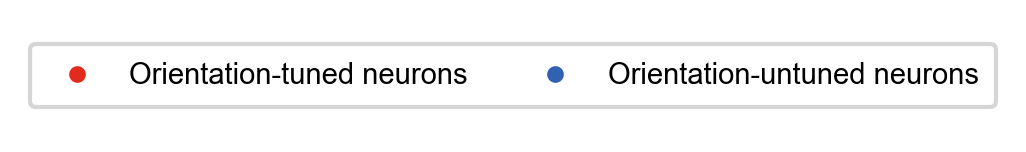

In [227]:
fig_legend = plt.figure(figsize=(4,0.4),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
ax = fig_legend.gca()
ax.axis('off')


alpha = 1
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ori_color, markersize=5, label='Orientation-tuned neurons' ,alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=non_ori_color, markersize=5, label='Orientation-untuned neurons', alpha=alpha),
]



fig_legend.legend(
    handles=legend_elements, loc='center', frameon=True, fontsize=tick_size, 
    ncol=2,  
    borderpad=0.6, 

)
save_path = os.path.join(supple_dir, 'decoding_mae_different_number_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Comparison of Neuron Precision

非参数, Kruskal-Wallis test(H) and Mann-Whitney U test(z)
mutil-group statistic: 16.885
mutil-group p-value: 2.155e-04,  p-value: 0.0002 
pairs reject: [ True  True False]
pairs z-value: [3.38533018485058, -3.5435231841426633, -1.3604597939119154]
pairs p-value: [0.00112953 0.00112953 0.17874136]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Orientation-tuned neurons vs. Orientation-untuned neurons with stable weights: Custom statistical test, P_val:1.130e-03
Orientation-untuned neurons with stable weights vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:1.130e-03
Orientation-tuned neurons vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:1.787e-01
非参数, Kruskal-Wallis test(H) and Mann-Whitney U test(z)
mutil-group statistic: 20.292
mutil-group p-value: 3.923e-05,  p

/tmp/ipykernel_2624445/3306954768.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=r_df, x=r_df['neuron class'], y=r_df['r'], ax=ax, palette=neuron_color_3compare,
/tmp/ipykernel_2624445/3306954768.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.stripplot(x='neuron class', y='r', data=r_df,
/tmp/ipykernel_2624445/3306954768.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfi

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Orientation-tuned neurons vs. Orientation-untuned neurons with stable weights: Custom statistical test, P_val:6.289e-03
Orientation-untuned neurons with stable weights vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:6.737e-06
Orientation-tuned neurons vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:7.397e-01
非参数, Kruskal-Wallis test(H) and Mann-Whitney U test(z)
mutil-group statistic: 16.070
mutil-group p-value: 3.239e-04,  p-value: 0.0003 
pairs reject: [False  True False]
pairs z-value: [1.7717615920713317, -4.049740781877329, 2.088147590655498]
pairs p-value: [0.07909826 0.00016456 0.05735225]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p 

/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/tmp/ipykernel_2624445/3306954768.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=r_df, x=r_df['neuron class'], y=r_df['r'], ax=ax, palette=neuron_color_3compare,
/tmp/ipykernel_2624445/3306954768.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.stripplot(x='neuron class', y='r', data=r_df,
/tmp/ipykernel_2624445/3306954768.py:45: UserWarning: No artists with labels found to put 

Orientation-untuned neurons with stable weights vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:1.646e-04
Orientation-tuned neurons vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:5.735e-02
非参数, Kruskal-Wallis test(H) and Mann-Whitney U test(z)
mutil-group statistic: 11.597
mutil-group p-value: 3.032e-03,  p-value: 0.0030 
pairs reject: [ True  True False]
pairs z-value: [2.277979189805998, -3.29041438527533, 1.1073509950445821]
pairs p-value: [0.03553129 0.00317441 0.27503899]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Orientation-tuned neurons vs. Orientation-untuned neurons with stable weights: Custom statistical test, P_val:3.553e-02


/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Orientation-untuned neurons with stable weights vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:3.174e-03
Orientation-tuned neurons vs. Orientation-untuned neurons with high, stable weights: Custom statistical test, P_val:2.750e-01


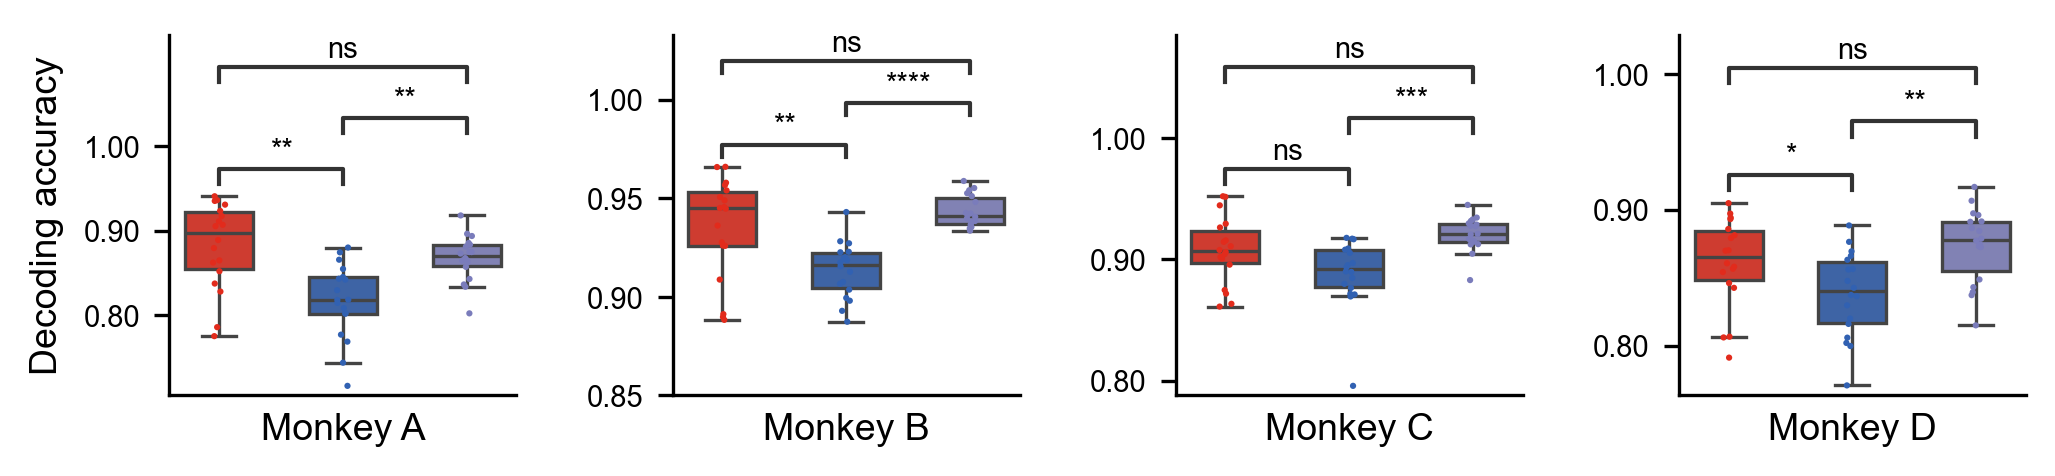

In [97]:
fig= plt.figure(figsize=(6.8, 1.6),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
box_linewidth = 0.8
dot_size = 1.5
ann_linewidth=1
Neuron_name = ['Orientation-tuned neurons', 'Orientation-untuned neurons with stable weights', 'Orientation-untuned neurons with high, stable weights']

for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = Monkey_old_path_list[monkey_id]
    data_path = os.path.join(monkey_path, 'results4_explain/r_compare_signi_non_ori/r_compare.mat')
    r_compare_origin = np.squeeze(loadmat_data(data_path))
    r_ori = r_compare_origin[0]
    r_non_ori = r_compare_origin[1]
    r_signifi_non_ori = r_compare_origin[2]

    r_compare = np.hstack([r_ori, r_non_ori, r_signifi_non_ori])
    monkey_name_list = [monkey_name] * len(r_compare)
    
    
    ori_string = [Neuron_name[0]] * r_compare_origin.shape[-1]
    non_ori_string = [Neuron_name[1]] * r_compare_origin.shape[-1]
    signifi_non_ori_string = [Neuron_name[2]] * r_compare_origin.shape[-1]
    class_neuron = np.squeeze(np.array(ori_string + non_ori_string + signifi_non_ori_string))
    
    r_df = pd.DataFrame(columns=['neuron class', 'r', 'monkey name'])
    r_df['neuron class'] = class_neuron
    r_df['r'] = r_compare
    r_df['monkey name'] = monkey_name_list
    

    x_order = Neuron_name
    p_values_fdr = compare_r(r_ori, r_non_ori, r_signifi_non_ori)
    
    
    ax=fig.add_subplot(1, 4, monkey_id+1)
    sns.boxplot(data=r_df, x=r_df['neuron class'], y=r_df['r'], ax=ax, palette=neuron_color_3compare,
                showfliers=False, width=0.55, linewidth=box_linewidth, whis = 1.5, saturation=0.8, order=x_order)
    plot = sns.stripplot(x='neuron class', y='r', data=r_df, 
                         palette=neuron_color_3compare,
                         dodge=False, jitter=0.05, size=dot_size,order=x_order, ax=ax)
    ax.legend().set_visible(False)

    
    box_pairs =[(x_order[0], x_order[1]),     
            (x_order[1], x_order[2]),     
            (x_order[2], x_order[0])]    
    
    annotator = Annotator(ax, pairs=box_pairs, data=r_df, x='neuron class', y='r', order=x_order)

    annotator.set_pvalues([p_values_fdr[0],   
                    p_values_fdr[1],        
                    p_values_fdr[2]])    
    annotator.configure(line_height=0.07, line_width=ann_linewidth, fontsize=legend_size, loc='inside')
    annotator.annotate()

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', labelsize=tick_size)
    # ax.set_ylim(0.7,1.2)
    
    if monkey_id == 1:
        y_label = np.arange(0.85,1.01,0.05)
    else:
        y_label = np.arange(0.8,1.01,0.1)
    # y_label_name = [f'{i}%' for i in range(0,120,25)]
    ax.set_yticks(y_label)
    ax.set_yticklabels([f'{tick:.2f}' for tick in y_label])  

    
    ax.set_xlabel(monkey_name, fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size)
    

left = 0.08
right = 0.99
bottom = 0.2
top = 0.95

# bottom = 0.12
# top = 0.92
hspace=0.5
ax.text(0.02, (bottom+top)/2, f'Decoding accuracy', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.45, hspace=0.8) 
save_path = os.path.join(main_dir, 'accuracy_compare_non_ori.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


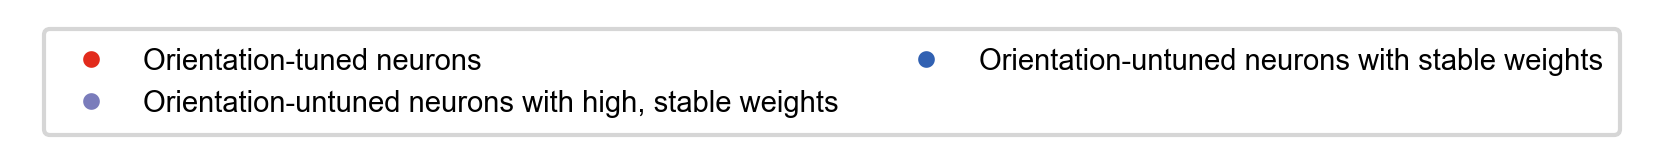

In [103]:
fig_legend = plt.figure(figsize=(6.8,0.4),facecolor='w', frameon=True, dpi=300) 
plt.rcParams["font.family"] = "Arial"
ax = fig_legend.gca()
ax.axis('off')


alpha = 1
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=neuron_color_3compare[0], markersize=5, label=f'{x_order[0]}' ,alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=neuron_color_3compare[2], markersize=5, label=f'{x_order[2]}', alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=neuron_color_3compare[1], markersize=5, label=f'{x_order[1]}', alpha=alpha),
    
]



fig_legend.legend(
    handles=legend_elements, loc='center', frameon=True, fontsize=tick_size, 
    ncol=2, 
    borderpad=0.6, 
    
)
save_path = os.path.join(main_dir, 'accuracy_compare_non_ori_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Oriented and Non-oriented neural manifolds

In [106]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
sub_dir = 'results4_geometry'
subsub_dir_list = ['ori_cell', 'non_ori_cell']
file_name = 'MDS_12.mat'
# 颜色映射
colors = cm.hsv(np.linspace(0, 1, oln+1))[0:oln]  

ax_linewidth = 0.5
cb_linewidth = 0.5

monkey_display = {Monkey_name[0]: {'angle':{0:90, 1:90}, 'elev':60, 'azim':20},
                  Monkey_name[1]: {'angle':{0:-20, 1:-30}, 'elev':60, 'azim':20},
                  Monkey_name[2]: {'angle':{0:0, 1:10}, 'elev':60, 'azim':20},
                  Monkey_name[3]: {'angle':{0:90, 1:90}, 'elev':45, 'azim':20},}

In [107]:
monkey_display[monkey_name]['angle'][0]

90

./Monkey_A/results4_geometry/ori_cell/MDS_12.mat
./Monkey_A/results4_geometry/non_ori_cell/MDS_12.mat
./Monkey_B/results4_geometry/ori_cell/MDS_12.mat
./Monkey_B/results4_geometry/non_ori_cell/MDS_12.mat
./Monkey_C/results4_geometry/ori_cell/MDS_12.mat
./Monkey_C/results4_geometry/non_ori_cell/MDS_12.mat
./Monkey_D/results4_geometry/ori_cell/MDS_12.mat
./Monkey_D/results4_geometry/non_ori_cell/MDS_12.mat


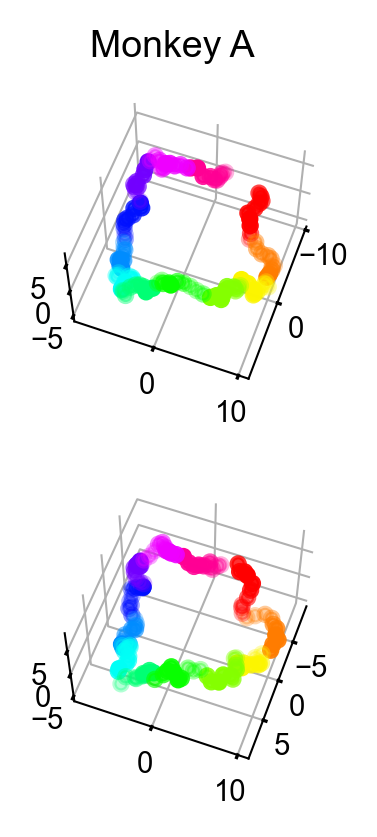

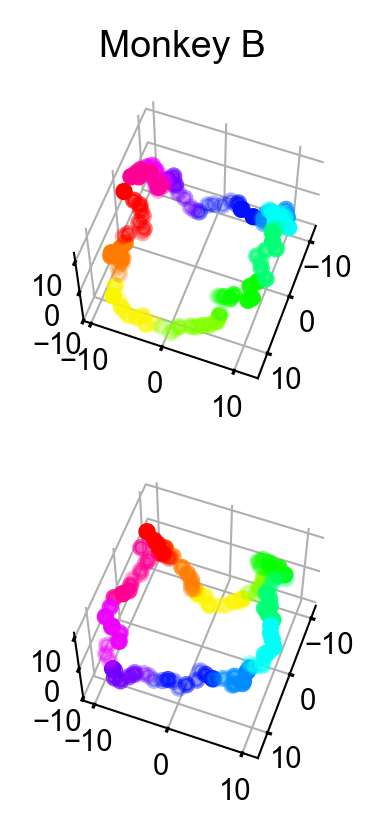

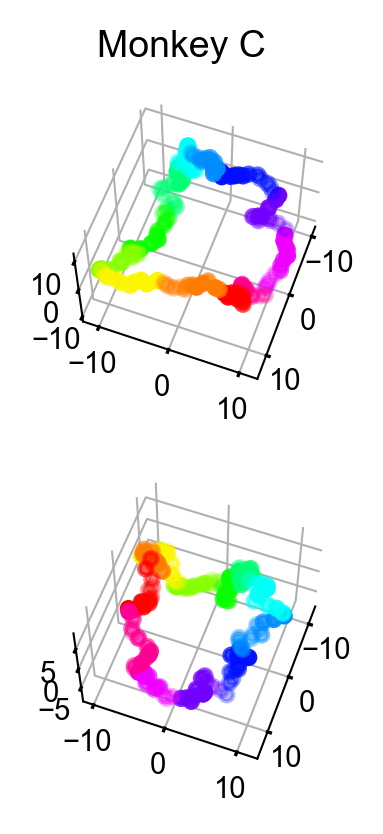

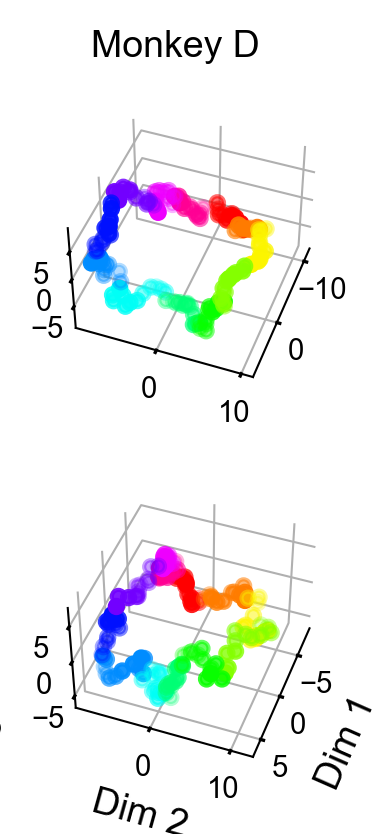

In [111]:

for monkey_id, monkey_name in enumerate(Monkey_name):
    # monkey_id = 0
    # monkey_name = Monkey_name[monkey_id]
    monkey_path = Monkey_path_list[monkey_id]
    
    fig= plt.figure(figsize=(1.5, 2.8),facecolor='none', frameon=True, dpi=300) 
    plt.rcParams['font.sans-serif']=['Arial']
    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['svg.hashsalt'] = 'hello'

    for ax_id, subsub_dir in enumerate(subsub_dir_list):
        data_path = os.path.join(monkey_path, sub_dir, subsub_dir, file_name)
        print(data_path)
        Y = loadmat_data(data_path)
        repeatNum = int(Y.shape[0]/oln)

        ax = fig.add_subplot(2, 1 , ax_id+1, projection='3d')
        ax.set_facecolor('white')  
        angle = monkey_display[monkey_name]['angle'][ax_id] 
        theta = np.radians(angle)  

        for i in range(oln):
            start_idx = i * repeatNum
            end_idx = (i + 1) * repeatNum
            x, y, z = Y[start_idx:end_idx, 0], Y[start_idx:end_idx, 1], Y[start_idx:end_idx, 2]

            x_rotated = x * np.cos(theta) - y * np.sin(theta)
            y_rotated = x * np.sin(theta) + y * np.cos(theta)
            
            img = ax.scatter(x_rotated, y_rotated, z, s=10, 
                    color=colors[i], 
                    label=f'Class {i+1}')  
            
        ax.view_init(elev=monkey_display[monkey_name]['elev'],
                     azim=monkey_display[monkey_name]['azim'])
        
        ax.tick_params(axis='both', which='both', pad=-4, 
            labelsize=tick_size, width=ax_linewidth)
        
        
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            
            axis._axinfo['tick']['outward_factor'] = 0.0  
            axis.pane.fill = False  
            axis.pane.set_edgecolor('w') 
            axis._axinfo["grid"]['linewidth'] = ax_linewidth 
            axis.line.set_lw(ax_linewidth)  
        
        ax.set_xlabel('', fontsize=label_size)
        ax.set_ylabel('', fontsize=label_size)
        ax.set_zlabel('', fontsize=label_size)
       
        ax.grid(True)
        
    if monkey_id == 3:
        ax.set_xlabel('Dim 1', fontsize=label_size, labelpad=-7)
        ax.set_ylabel('Dim 2', fontsize=label_size, labelpad=-8)
        ax.set_zlabel('Dim 3', fontsize=label_size, labelpad=-8)
    left = 0.1
    right = 0.97
    bottom = 0.1
    top = 0.9
    fig.suptitle(monkey_name, fontsize = label_size)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=1, hspace=0.3) 
    filename = f'ori_non_ori_geometry_2rows_{monkey_name}.pdf'
    save_path = os.path.join(main_dir, filename)
    plt.savefig(save_path, format='pdf', dpi=300)
    

# Different numbers of non-oriented neural manifolds

In [129]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
sub_dir = 'results4_geometry/non_ori_cell'
filename_list = ['MDS_12_neuron_num_10.mat', 'MDS_12_neuron_num_20.mat', 'MDS_12_neuron_num_50.mat', 'MDS_12_neuron_num_100.mat']

# 颜色映射
colors = cm.hsv(np.linspace(0, 1, oln+1))[0:oln]  

ax_linewidth = 0.5
cb_linewidth = 0.5

monkey_display = {Monkey_name[0]: {'angle':{0:90, 1:90, 2:90, 3:-120}, 'elev':60, 'azim':20},
                  Monkey_name[1]: {'angle':{0:-20, 1:30, 2:-60, 3:30}, 'elev':60, 'azim':20},
                  Monkey_name[2]: {'angle':{0:180, 1:10, 2:150, 3:90}, 'elev':60, 'azim':20},
                  Monkey_name[3]: {'angle':{0:-30, 1:-270, 2:30, 3:90}, 'elev':60, 'azim':20},}

In [130]:
filename_list

['MDS_12_neuron_num_10.mat',
 'MDS_12_neuron_num_20.mat',
 'MDS_12_neuron_num_50.mat',
 'MDS_12_neuron_num_100.mat']

./Monkey_A/results4_geometry/non_ori_cell/MDS_12_neuron_num_10.mat
./Monkey_A/results4_geometry/non_ori_cell/MDS_12_neuron_num_20.mat
./Monkey_A/results4_geometry/non_ori_cell/MDS_12_neuron_num_50.mat
./Monkey_A/results4_geometry/non_ori_cell/MDS_12_neuron_num_100.mat
./Monkey_B/results4_geometry/non_ori_cell/MDS_12_neuron_num_10.mat
./Monkey_B/results4_geometry/non_ori_cell/MDS_12_neuron_num_20.mat
./Monkey_B/results4_geometry/non_ori_cell/MDS_12_neuron_num_50.mat
./Monkey_B/results4_geometry/non_ori_cell/MDS_12_neuron_num_100.mat
./Monkey_C/results4_geometry/non_ori_cell/MDS_12_neuron_num_10.mat
./Monkey_C/results4_geometry/non_ori_cell/MDS_12_neuron_num_20.mat
./Monkey_C/results4_geometry/non_ori_cell/MDS_12_neuron_num_50.mat
./Monkey_C/results4_geometry/non_ori_cell/MDS_12_neuron_num_100.mat
./Monkey_D/results4_geometry/non_ori_cell/MDS_12_neuron_num_10.mat
./Monkey_D/results4_geometry/non_ori_cell/MDS_12_neuron_num_20.mat
./Monkey_D/results4_geometry/non_ori_cell/MDS_12_neuron_num

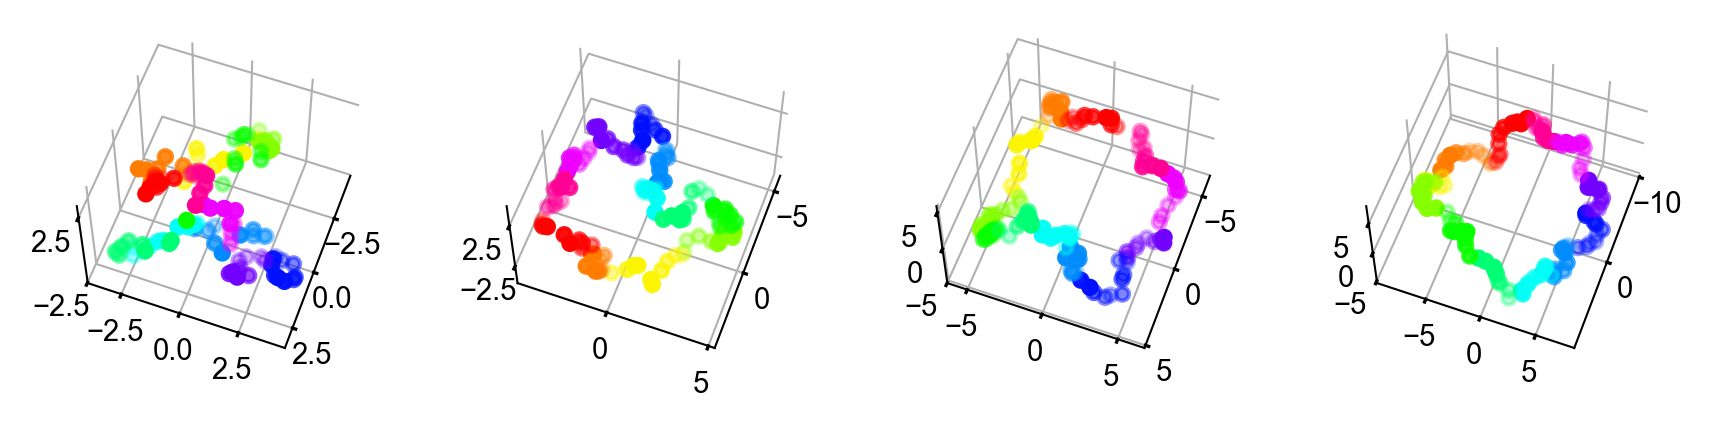

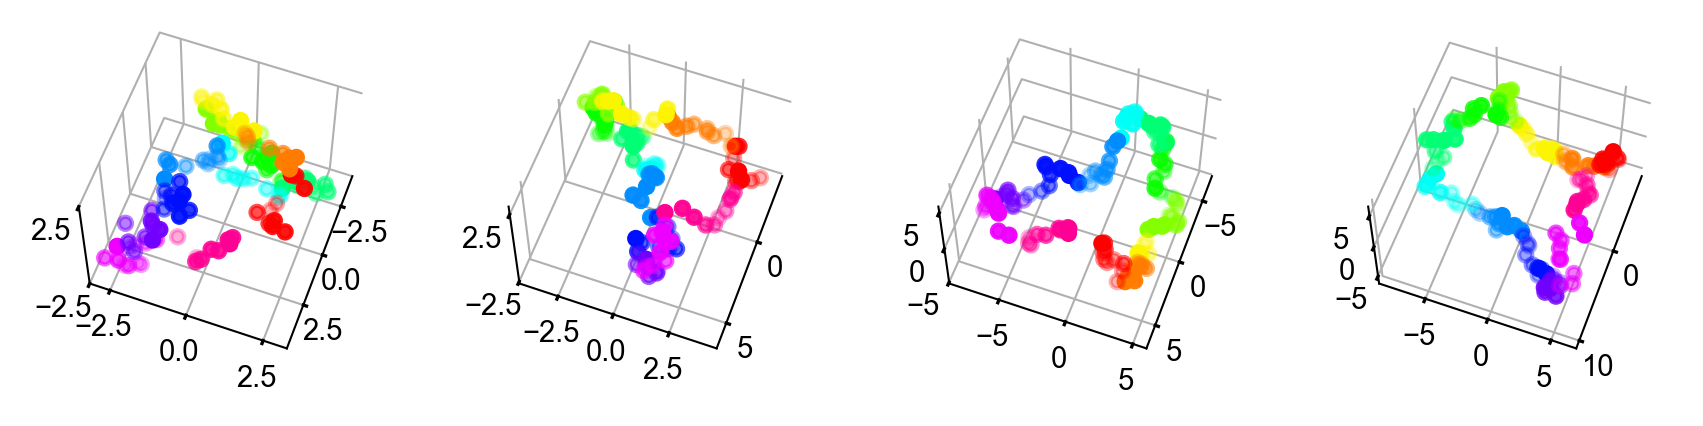

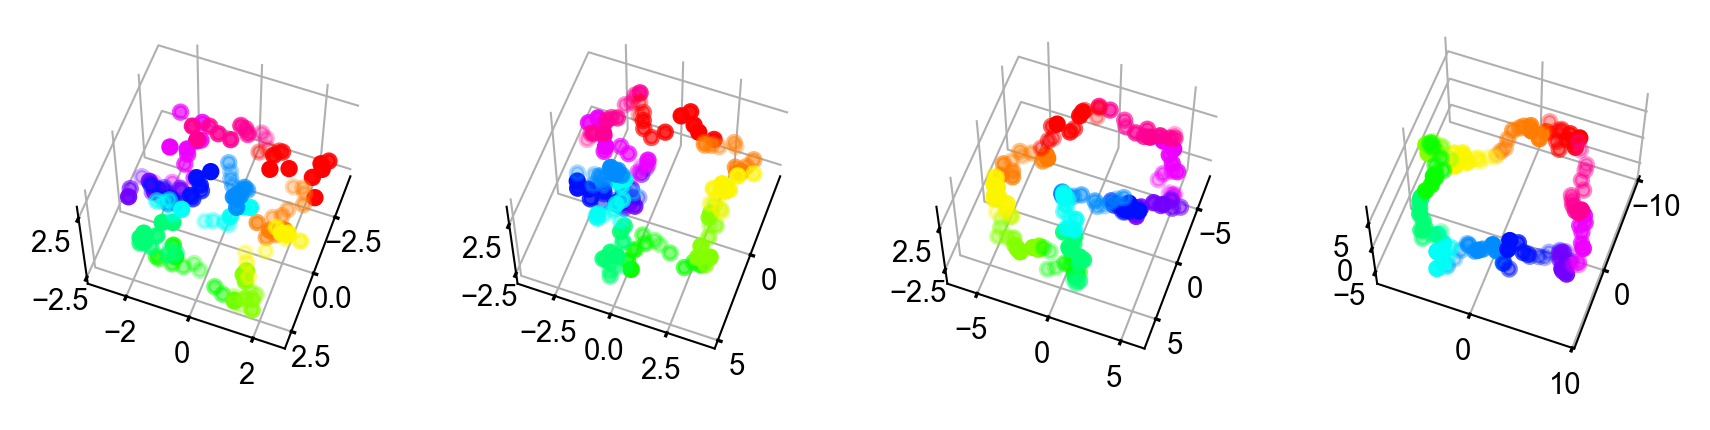

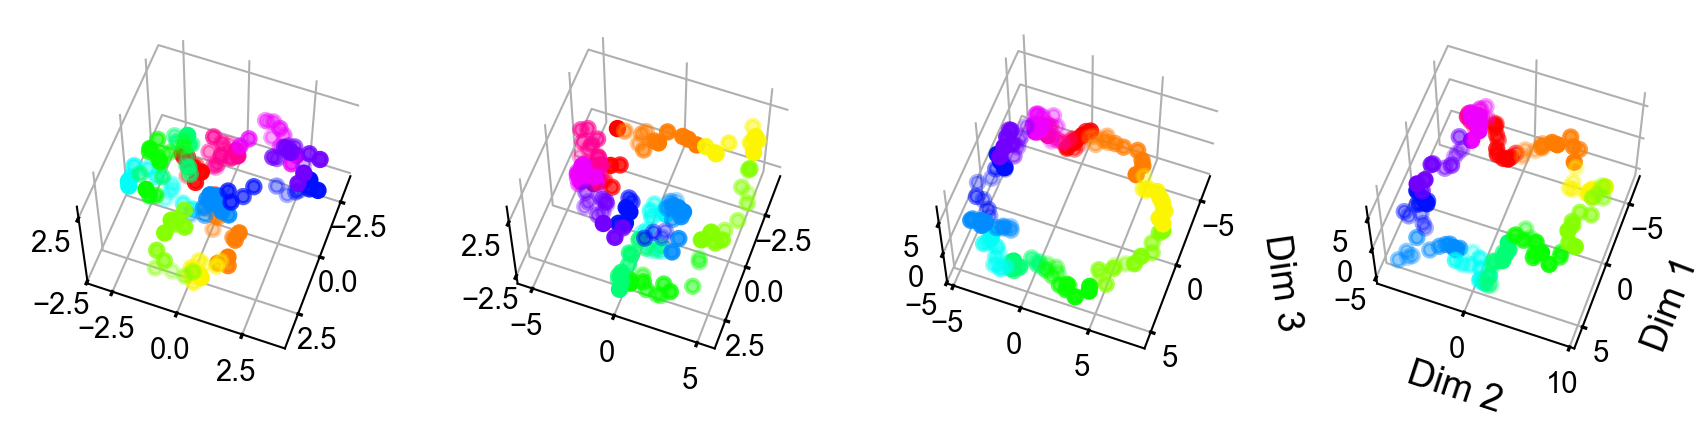

In [132]:

for monkey_id, monkey_name in enumerate(Monkey_name):
    # monkey_id = 3
    # monkey_name = Monkey_name[monkey_id]
    monkey_path = Monkey_path_list[monkey_id]
    
    fig= plt.figure(figsize=(6, 1.4),facecolor='none', frameon=True, dpi=300) 
    plt.rcParams['font.sans-serif']=['Arial']
    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['svg.hashsalt'] = 'hello'

    for ax_id, filename in enumerate(filename_list):
        data_path = os.path.join(monkey_path, sub_dir, filename)
        print(data_path)
        
        Y = loadmat_data(data_path)
        repeatNum = int(Y.shape[0]/oln)

        
        ax = fig.add_subplot(1, 4, ax_id+1, projection='3d')
        ax.set_facecolor('white')  #
        
        angle = monkey_display[monkey_name]['angle'][ax_id] 
        theta = np.radians(angle)  

        
        for i in range(oln):
            start_idx = i * repeatNum
            end_idx = (i + 1) * repeatNum
            x, y, z = Y[start_idx:end_idx, 0], Y[start_idx:end_idx, 1], Y[start_idx:end_idx, 2]

            x_rotated = x * np.cos(theta) - y * np.sin(theta)
            y_rotated = x * np.sin(theta) + y * np.cos(theta)
            
            img = ax.scatter(x_rotated, y_rotated, z, s=10, 
                    color=colors[i], 
                    label=f'Class {i+1}')  
            
        
        
        ax.view_init(elev=monkey_display[monkey_name]['elev'],
                     azim=monkey_display[monkey_name]['azim'])
        
        ax.tick_params(axis='both', which='both', pad=-4, 
            labelsize=tick_size, width=ax_linewidth)
        if ax_id==0 or ax_id==1:
            ax.set_zticks([-2.5,2.5])
        if ax_id==2:
            if monkey_id == 2:
                ax.set_zticks([-2.5,2.5])
            else:
                ax.set_zticks([-5,0,5])
        if ax_id==3:
            ax.set_zticks([-5,0,5])
        
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            
            axis._axinfo['tick']['outward_factor'] = 0.0  
            axis.pane.fill = False  
            axis.pane.set_edgecolor('w') 
            axis._axinfo["grid"]['linewidth'] = ax_linewidth 
            axis.line.set_lw(ax_linewidth)  
        
        ax.set_xlabel('', fontsize=label_size)
        ax.set_ylabel('', fontsize=label_size)
        ax.set_zlabel('', fontsize=label_size)
       
        ax.grid(True)
        
    if monkey_id == 3:
        ax.set_xlabel('Dim 1', fontsize=label_size, labelpad=-7)
        ax.set_ylabel('Dim 2', fontsize=label_size, labelpad=-9)
        ax.set_zlabel('Dim 3', fontsize=label_size, labelpad=-8)
    left = 0.05
    right = 0.95
    bottom = 0.19
    top = 1
    # fig.suptitle(monkey_name, fontsize = label_size)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.3, hspace=1) 
    filename = f'different_num_non_ori_geometry_{monkey_name}.pdf'
    save_path = os.path.join(main_dir, filename)
    plt.savefig(save_path, format='pdf', dpi=300)
    
    

# Chi-square distribution

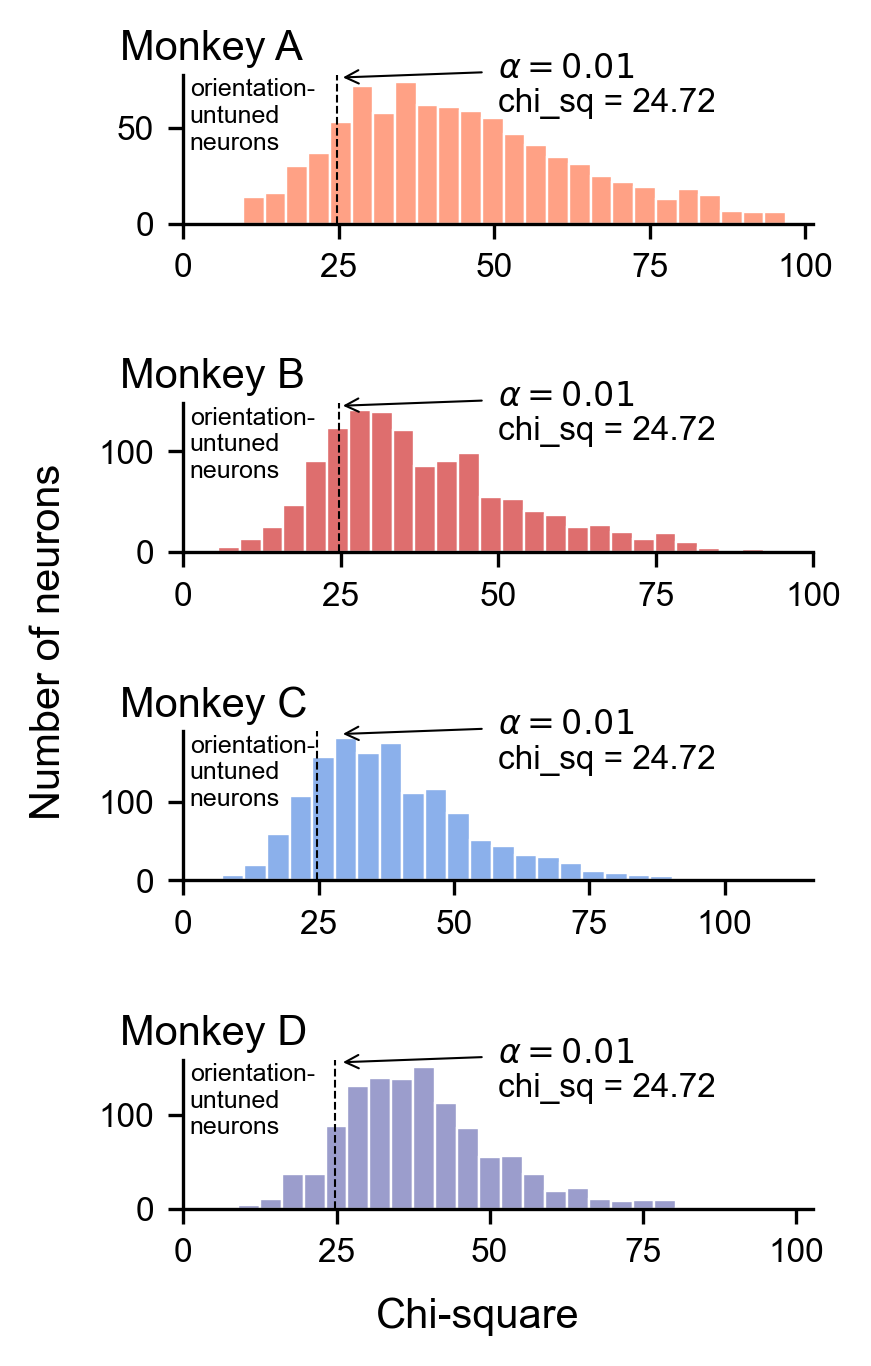

In [10]:
fig = plt.figure(figsize=(2.8,4.5),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    data_path = os.path.join(Monkey_origin_path_list[monkey_id], 'Y1_AnovaChiSquareStatistic.mat')
    Chi_sq = np.squeeze(loadmat_data(data_path))
    ax=fig.add_subplot(4, 1, monkey_id+1)
    
    sns.histplot(data = Chi_sq,
                 bins=25, 
                 color=monkey_palette[monkey_id], edgecolor='white', ax=ax)

    
    ax.set_xlabel('', fontsize=label_size)
    ax.set_ylabel('', fontsize=label_size)
    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)

    x_label = np.arange(0,  101, 25)
    ax.set_xticks(x_label)
    x_label_name = np.round(x_label, 2)
    ax.set_xticklabels(x_label_name, rotation=0)

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(-0.1, 1.1, f'{Monkey_name[monkey_id]}', transform=ax.transAxes, size=label_size)
    ax.text(0.01, 0.5, f'orientation-\nuntuned\nneurons', transform=ax.transAxes, fontsize=6) 
    ax.axvline(24.72497031131828, ymin=0, ymax=100, color='black', linewidth=0.5, linestyle='--')
    ax.text(0.5, 0.75, f'chi_sq = 24.72', transform=ax.transAxes, fontsize=legend_size) 
    ax.annotate(r'$\alpha = 0.01$', xy=(0.24, 0.98), xytext=(0.5, 0.98),
    arrowprops=dict(arrowstyle="->", facecolor='black', lw=0.5),
    fontsize=legend_size,
    xycoords='axes fraction',   
    color = 'black')

ax.text(0.55, 0.02, f'Chi-square', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.04, 0.52, f'Number of neurons', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=0.2, bottom=.1, right=0.95, top=0.94, wspace=0.9, hspace=1.2) 
save_path = os.path.join(supple_dir, 'Chi_square_distribution.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# FOV

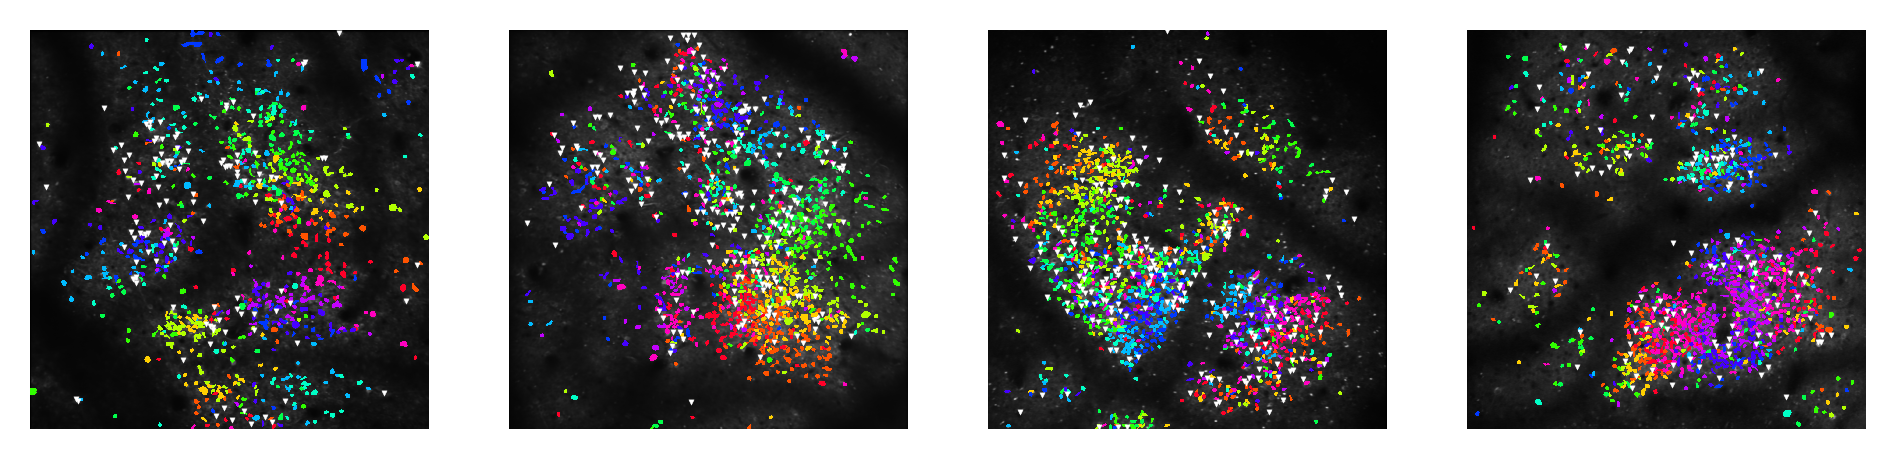

In [73]:
fig= plt.figure(figsize=(6.8, 2),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
for monkey_id, monkey_name in enumerate(Monkey_name):
    monkey_path = os.path.dirname(Monkey_old_path_list[monkey_id])
    

    data_path = os.path.join(monkey_path, 'sumIm.mat')
    mean_image = h5py.File(data_path)['sumIm'][:]
    mean_image = mean_image.transpose(2, 1, 0)
    mean_image = np.clip(mean_image, 0, 1) 
    
    data_path = os.path.join(monkey_path, 'coorxy.mat')
    coorxy = loadmat_data(data_path) - 1  
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results2_space_map/MaxOri_all_group.mat')
    MaxOri_all_group = np.squeeze(loadmat_data(data_path))
    data_path = os.path.join(Monkey_origin_path_list[monkey_id], 'targetCell.mat')
    target_cell_index = np.squeeze(loadmat_data(data_path)) -1  
    ori_cell= np.squeeze(loadmat_data(os.path.join(Monkey_old_path_list[monkey_id], 'ori_cell.mat')))
    bool_ori_cell = ori_cell.astype(bool)
    target_cell_index = bool_ori_cell
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results4_explain/non_difference_non_ori_cell_index.mat')
    non_difference_non_ori_cell_index = np.squeeze(loadmat_data(data_path)) -1 

    target_cell_coorxy = coorxy[0,target_cell_index]
    target_cell_ori = MaxOri_all_group[target_cell_index]
    target_cell_map = np.zeros((mean_image.shape[0], mean_image.shape[1]))
    for i, neuron in enumerate(target_cell_coorxy):
        for coor in neuron:
            target_cell_map[coor[0], coor[1]] = target_cell_ori[i]
    target_cell_map = np.where(target_cell_map==0, np.nan, target_cell_map)

    cell_coorxy_centre = np.zeros((coorxy.shape[1], 2))
    for i, cell_coor in enumerate(coorxy[0]):
        cell_coorxy_centre[i, 0] = np.median(cell_coor[:, 0])
        cell_coorxy_centre[i, 1] = np.median(cell_coor[:, 1])
        non_ori_cell_index = np.where(ori_cell==0)[0]
        
    non_difference_non_ori_cell_index_in_all_cell = non_ori_cell_index[non_difference_non_ori_cell_index]
    non_ori_cell_coorxy_centre =  cell_coorxy_centre[non_difference_non_ori_cell_index_in_all_cell, :]
    non_ori_cell_tuning = np.full([non_ori_cell_coorxy_centre.shape[0],1], None)
    non_ori_cell_info = np.hstack((non_ori_cell_coorxy_centre, non_ori_cell_tuning))
    df_non_ori_cell = pd.DataFrame(non_ori_cell_info, columns = ['x_coor', 'y_coor', 'orientation'])
    df_non_ori_cell.head()
    
    ax = fig.add_subplot(1, 4, monkey_id+1)
    ax.imshow(mean_image, cmap='gray')
    h = sns.heatmap(target_cell_map, cmap = 'gist_rainbow', cbar=False, ax=ax)
    sns.scatterplot(x="y_coor", y="x_coor", data=df_non_ori_cell, s=1.6, color="#FFFFFF", marker="v", legend=False, ax=ax)
    ax.axis('off')

plt.subplots_adjust(left=.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2) 
save_path = os.path.join(supple_dir, 'FOV.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

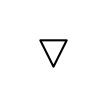

In [72]:
fig= plt.figure(figsize=(0.2, 0.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax_cb = plt.gca()
ax_cb.axis('off')
ax_cb.tick_params(axis='both', which='both', length=0)
ax_cb.set_xticklabels('')
ax_cb.set_yticklabels('')
ax_cb.scatter(0, 0, s=40, color="#FFFFFF", edgecolor = 'black',linewidth=0.5,marker="v")

save_path = os.path.join(supple_dir, 'FOV_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Displacement Inspection Results (orientation-untuned)

## A

/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make

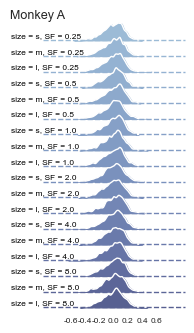

In [181]:
data_path = os.path.join(MonkeyA_old_path, 'results3_pre_all_unchange_cell/PT/')
PT_list = natsorted(glob.glob(data_path + 'PT_r_1000_non_ori_condi_*.mat'))
PT_df = pd.DataFrame(columns=['Conditions', 'r'])
r_all = []
group_name_all = []
for the_group in range(len(PT_list)):
    r = np.squeeze(loadmat_data(PT_list[the_group]))
    col, row = divmod(the_group, len(spatial_size))
    sf = spatial_frequency[col]
    sz = spatial_size[row]
    the_group_name = f'size = {sz}, SF = {sf}'
    the_group_name_list = [the_group_name] * len(r)
    r_all.extend(r)
    group_name_all.extend(the_group_name_list)
r_all = np.array(r_all)
PT_df['Conditions'] = group_name_all
PT_df['r'] = r_all

sns.set_style("white")
plt.rcParams['axes.facecolor'] = (0, 0, 0, 0)
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'


pal = sns.cubehelix_palette(len(PT_list),rot=-0.2, gamma=0.5, light=0.5)
g = sns.FacetGrid(PT_df, row='Conditions', hue='Conditions', aspect=9, height=.2, palette=pal)
g.map(sns.kdeplot, 'r', bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, 'r', clip_on = False, color='w', lw=1, bw_adjust=0.5)
g.refline(y=0, linewidth=1, linestyle='--', color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.225, 0.2, label, color='black', ha="left", va="center", transform=ax.transAxes, fontsize=tick_size-1)
    
g.map(label, 'r')
g.figure.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

g.set_xticklabels(fontsize=tick_size-1)
x_label = np.arange(-0.6, 0.7, 0.2)
x_label = np.round(x_label, 1) 

rows, cols = g.axes.shape
last_row_axes = g.axes[rows-1, cols-1]
last_row_axes.set_xticks(x_label)
last_row_axes.set_xticklabels(x_label)

ax_last = g.axes.flat[-1]
ax_last.set_xlabel('')
ax_first = g.axes.flat[0]
ax_first.text(-0.229, 1.05, 'Monkey A', transform=ax_first.transAxes, fontsize=label_size)


plt.subplots_adjust(left=.18, bottom=0.15, right=0.97, top=0.95) 
save_path = os.path.join(supple_dir, 'permutation_non_ori_monkeyA.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

## B

/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make

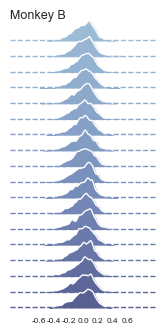

In [182]:
data_path = os.path.join(MonkeyB_old_path, 'results3_pre_all_unchange_cell/PT/')
PT_list = natsorted(glob.glob(data_path + 'PT_r_1000_non_ori_condi_*.mat'))
PT_df = pd.DataFrame(columns=['Conditions', 'r'])
r_all = []
group_name_all = []
for the_group in range(len(PT_list)):
    r = np.squeeze(loadmat_data(PT_list[the_group]))
    col, row = divmod(the_group, len(spatial_size))
    sf = spatial_frequency[col]
    sz = spatial_size[row]
    the_group_name = f'size={sz}, SF={sf}'
    the_group_name_list = [the_group_name] * len(r)
    r_all.extend(r)
    group_name_all.extend(the_group_name_list)
r_all = np.array(r_all)
PT_df['Conditions'] = group_name_all
PT_df['r'] = r_all


sns.set_style("white")
plt.rcParams['axes.facecolor'] = (0, 0, 0, 0)
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

pal = sns.cubehelix_palette(len(PT_list),rot=-0.2, gamma=0.5, light=0.5)
g = sns.FacetGrid(PT_df, row='Conditions', hue='Conditions', aspect=7.8, height=.2, palette=pal)
g.map(sns.kdeplot, 'r', bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, 'r', clip_on = False, color='w', lw=1, bw_adjust=0.5)
g.refline(y=0, linewidth=1, linestyle='--', color=None, clip_on=False)

g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

g.set_xticklabels(fontsize=tick_size-1)
x_label = np.arange(-0.6, 0.7, 0.2)
x_label = np.round(x_label, 1) 

rows, cols = g.axes.shape
last_row_axes = g.axes[rows-1, cols-1]
last_row_axes.set_xticks(x_label)
last_row_axes.set_xticklabels(x_label)

ax_last = g.axes.flat[-1]
ax_last.set_xlabel('')
ax_first = g.axes.flat[0]
ax_first.text(-0.0, 1.05, 'Monkey B', transform=ax_first.transAxes, fontsize=label_size)


plt.subplots_adjust(left=.03, bottom=0.15, right=0.97, top=0.95) 
save_path = os.path.join(supple_dir, 'permutation_non_ori_monkeyB.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    
    

## C

/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make

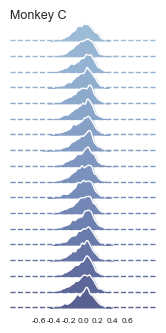

In [183]:
data_path = os.path.join(MonkeyC_old_path, 'results3_pre_all_unchange_cell/PT/')
PT_list = natsorted(glob.glob(data_path + 'PT_r_1000_non_ori_condi_*.mat'))
PT_df = pd.DataFrame(columns=['Conditions', 'r'])
r_all = []
group_name_all = []
for the_group in range(len(PT_list)):
    r = np.squeeze(loadmat_data(PT_list[the_group]))
    col, row = divmod(the_group, len(spatial_size))
    sf = spatial_frequency[col]
    sz = spatial_size[row]
    the_group_name = f'size={sz}, SF={sf}'
    the_group_name_list = [the_group_name] * len(r)
    r_all.extend(r)
    group_name_all.extend(the_group_name_list)
r_all = np.array(r_all)
PT_df['Conditions'] = group_name_all
PT_df['r'] = r_all

sns.set_style("white")
plt.rcParams['axes.facecolor'] = (0, 0, 0, 0)
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

pal = sns.cubehelix_palette(len(PT_list),rot=-0.2, gamma=0.5, light=0.5)
g = sns.FacetGrid(PT_df, row='Conditions', hue='Conditions', aspect=7.8, height=.2, palette=pal)
g.map(sns.kdeplot, 'r', bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, 'r', clip_on = False, color='w', lw=1, bw_adjust=0.5)
g.refline(y=0, linewidth=1, linestyle='--', color=None, clip_on=False)

g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

g.set_xticklabels(fontsize=tick_size-1)
x_label = np.arange(-0.6, 0.7, 0.2)
x_label = np.round(x_label, 1) 

rows, cols = g.axes.shape
last_row_axes = g.axes[rows-1, cols-1]
last_row_axes.set_xticks(x_label)
last_row_axes.set_xticklabels(x_label)


ax_last = g.axes.flat[-1]
ax_last.set_xlabel('')
ax_first = g.axes.flat[0]
ax_first.text(-0.0, 1.05, 'Monkey C', transform=ax_first.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.03, bottom=0.15, right=0.97, top=0.95) 
save_path = os.path.join(supple_dir, 'permutation_non_ori_monkeyC.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

## D

/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/yjzhong/application/miniconda3/envs/torch_gym/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make

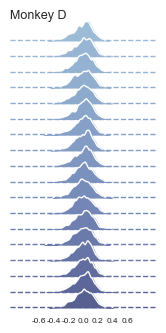

In [184]:
data_path = os.path.join(MonkeyD_old_path, 'results3_pre_all_unchange_cell/PT/')
PT_list = natsorted(glob.glob(data_path + 'PT_r_1000_non_ori_condi_*.mat'))
PT_df = pd.DataFrame(columns=['Conditions', 'r'])
r_all = []
group_name_all = []
for the_group in range(len(PT_list)):
    r = np.squeeze(loadmat_data(PT_list[the_group]))
    col, row = divmod(the_group, len(spatial_size))
    sf = spatial_frequency[col]
    sz = spatial_size[row]
    the_group_name = f'size={sz}, SF={sf}'
    the_group_name_list = [the_group_name] * len(r)
    r_all.extend(r)
    group_name_all.extend(the_group_name_list)
r_all = np.array(r_all)
PT_df['Conditions'] = group_name_all
PT_df['r'] = r_all

sns.set_style("white")
plt.rcParams['axes.facecolor'] = (0, 0, 0, 0)
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

pal = sns.cubehelix_palette(len(PT_list),rot=-0.2, gamma=0.5, light=0.5)
g = sns.FacetGrid(PT_df, row='Conditions', hue='Conditions', aspect=7.8, height=.2, palette=pal)
g.map(sns.kdeplot, 'r', bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, 'r', clip_on = False, color='w', lw=1, bw_adjust=0.5)
g.refline(y=0, linewidth=1, linestyle='--', color=None, clip_on=False)

g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

g.set_xticklabels(fontsize=tick_size-1)
x_label = np.arange(-0.6, 0.7, 0.2)
x_label = np.round(x_label, 1) 

rows, cols = g.axes.shape
last_row_axes = g.axes[rows-1, cols-1]
last_row_axes.set_xticks(x_label)
last_row_axes.set_xticklabels(x_label)

ax_last = g.axes.flat[-1]
ax_last.set_xlabel('')
ax_first = g.axes.flat[0]
ax_first.text(-0.0, 1.05, 'Monkey D', transform=ax_first.transAxes, fontsize=label_size)


plt.subplots_adjust(left=.03, bottom=0.15, right=0.97, top=0.95) 
save_path = os.path.join(supple_dir, 'permutation_non_ori_monkeyD.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

# Verification of all group decodes

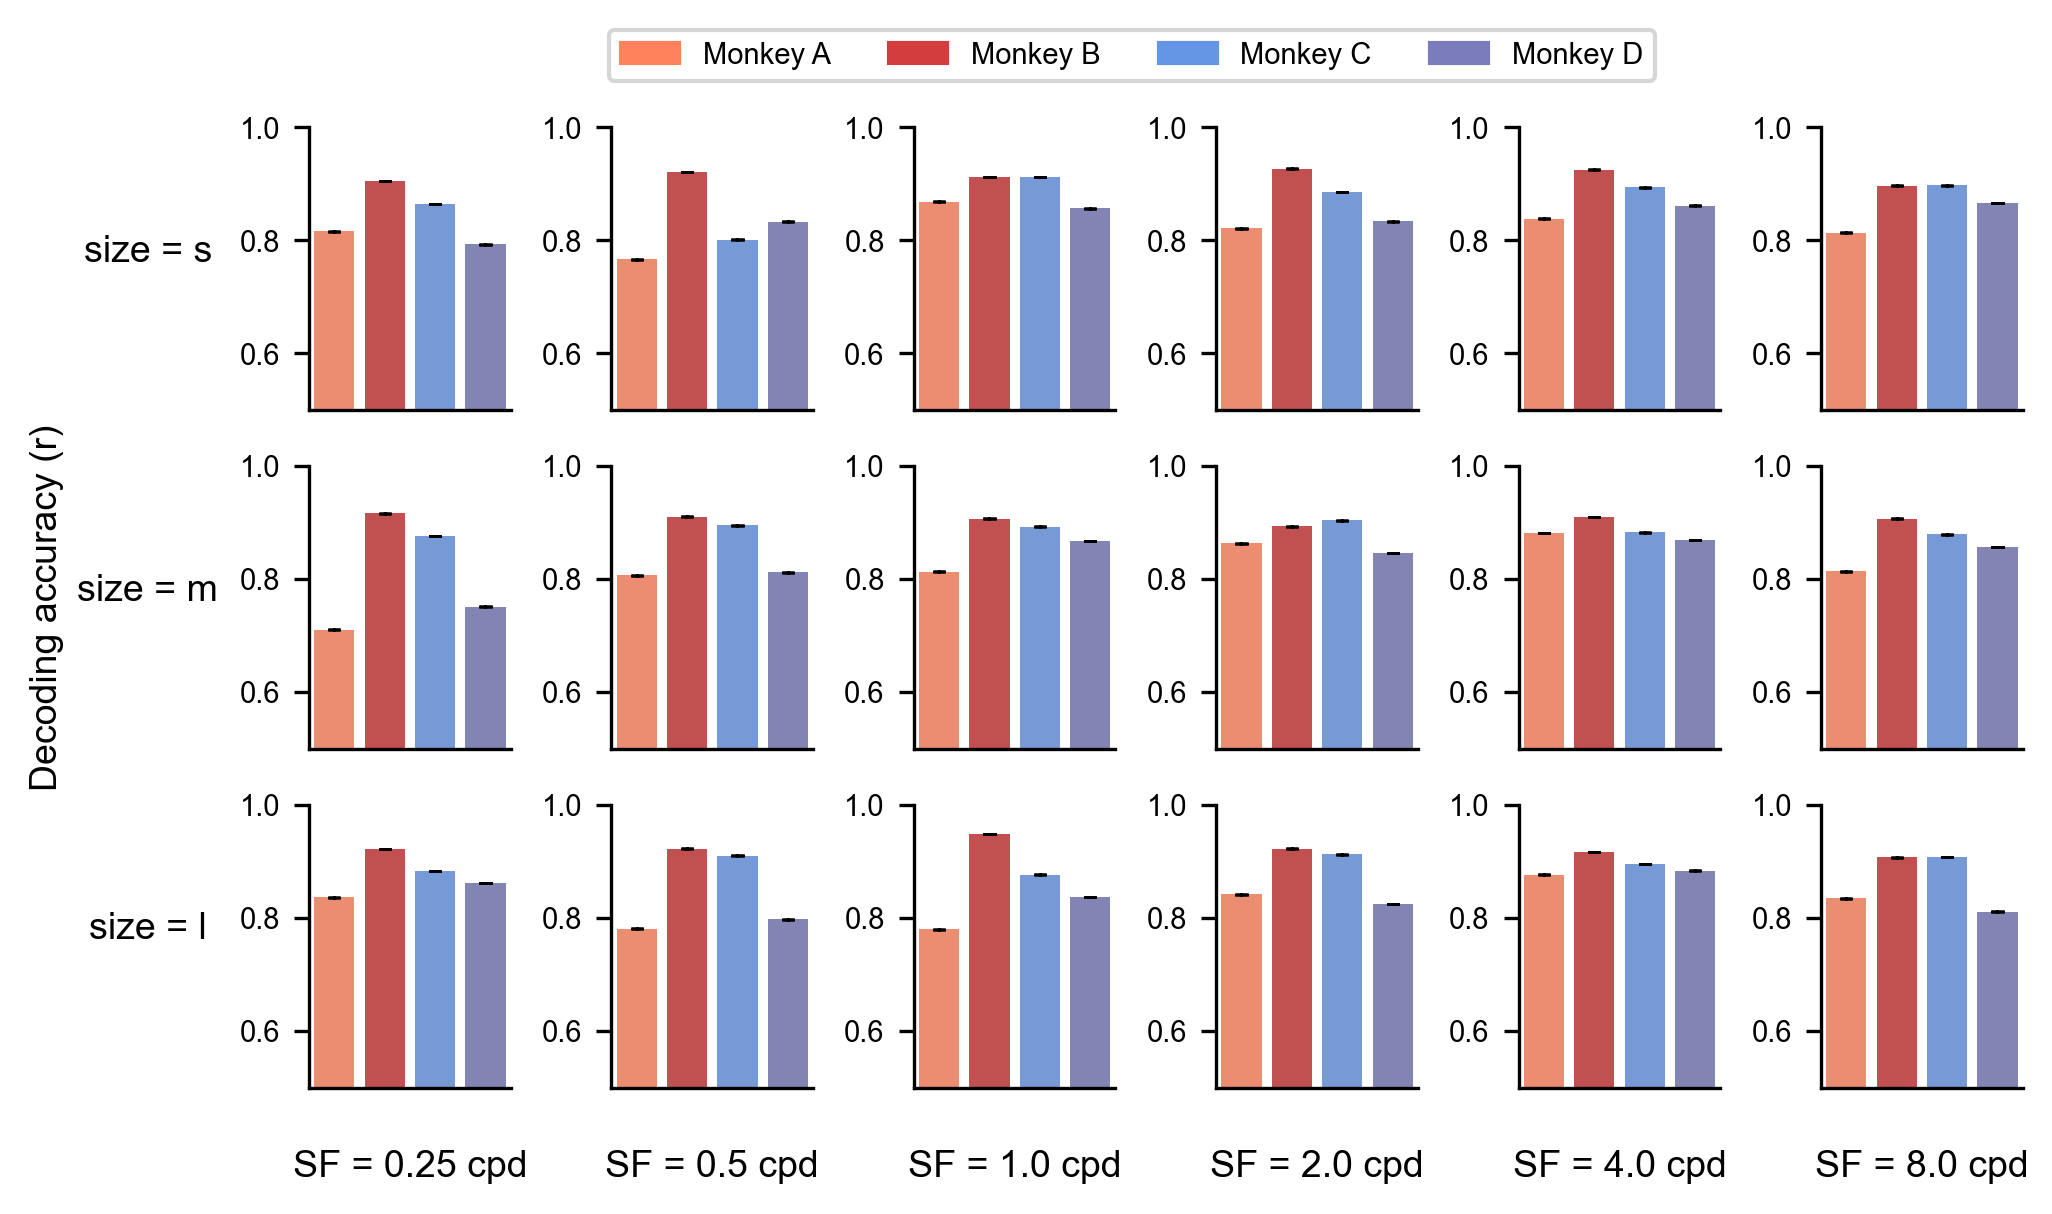

In [176]:
# r
data_path = os.path.join(MonkeyA_old_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_mean_rounds_all_groups_MonkeyA = loadmat_data(data_path)

data_path = os.path.join(MonkeyB_old_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_mean_rounds_all_groups_MonkeyB = loadmat_data(data_path)

data_path = os.path.join(MonkeyC_old_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_mean_rounds_all_groups_MonkeyC = loadmat_data(data_path)

data_path = os.path.join(MonkeyD_old_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_mean_rounds_all_groups_MonkeyD = loadmat_data(data_path)

fig = plt.figure(figsize=(6.8,4),facecolor='w', frameon=True, dpi=300) 
# sns.set_style('muted')
# sns.set_palette("muted") 
plt.style.use('default')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
axs = fig.subplots(len(spatial_size),len(spatial_frequency))
for the_group in range(r_mean_rounds_all_groups_MonkeyA.shape[1]):
    r_mean_rounds_specific_group_MonkeyA = r_mean_rounds_all_groups_MonkeyA[:, the_group]
    r_mean_rounds_specific_group_MonkeyB = r_mean_rounds_all_groups_MonkeyB[:, the_group]
    r_mean_rounds_specific_group_MonkeyC = r_mean_rounds_all_groups_MonkeyC[:, the_group]
    r_mean_rounds_specific_group_MonkeyD = r_mean_rounds_all_groups_MonkeyD[:, the_group]
    r_mean_rounds_specific_group_all_monkey = np.hstack([r_mean_rounds_specific_group_MonkeyA,
                                                        r_mean_rounds_specific_group_MonkeyB,
                                                        r_mean_rounds_specific_group_MonkeyC,
                                                        r_mean_rounds_specific_group_MonkeyD])

    
    MonkeyA_string = ['MonkeyA'] * len(r_mean_rounds_specific_group_MonkeyA)
    MonkeyB_string = ['MonkeyB'] * len(r_mean_rounds_specific_group_MonkeyB)
    MonkeyC_string = ['MonkeyC'] * len(r_mean_rounds_specific_group_MonkeyC)
    MonkeyD_string = ['MonkeyD'] * len(r_mean_rounds_specific_group_MonkeyD)
    monkey = np.squeeze(np.array(MonkeyA_string + MonkeyB_string + MonkeyC_string+MonkeyD_string))
    r_mean_rounds_df = pd.DataFrame(columns=['Monkey', 'r'])   # Empty DataFrame
    r_mean_rounds_df['Monkey'] = monkey
    r_mean_rounds_df['r'] = r_mean_rounds_specific_group_all_monkey

    col, row = divmod(the_group, len(spatial_size))
    ax=axs[row, col]
    plot = sns.barplot(x='Monkey', y='r', data=r_mean_rounds_df, hue='Monkey',
                    estimator=np.mean, palette=monkey_palette,
                    errorbar=('ci', 95), capsize=.2, err_kws={'linewidth': 0.6, 'color': 'black'}, ax=ax)
    ax.set_ylim(0.5,1)

    
    if 0 <= the_group <= 2:
        ax.set_ylabel(f'size = {spatial_size[row]}', fontsize=label_size, rotation=0, labelpad=22)
    else:
        ax.set_ylabel('')
    
    if (the_group+1) % len(spatial_size) == 0:
        ax.set_xlabel(f'SF = {spatial_frequency[col]} cpd', fontsize=label_size, rotation=0, labelpad=15)
    else:
        ax.set_xlabel('')

    if the_group == 1:
        patches = [matplotlib.patches.Patch(color=monkey_palette[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
        labels = 'Monkey A', 'Monkey B', 'Monkey C', 'Monkey D'
        ax.legend(handles=patches, labels=labels,
            loc="center left",
            ncol=4,
            bbox_to_anchor=(0.28, 0.96),
            bbox_transform=fig.transFigure,
            fontsize=legend_size
        )
        ax.text(-1.3, 0.5, 'Decoding accuracy (r)', transform=ax.transAxes, fontsize=label_size, va='center', ha='center', rotation=90)
    
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', labelsize=tick_size)

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
plt.subplots_adjust(left=.14, bottom=0.1, right=0.98, top=0.9, wspace=0.5, hspace=0.2) 
save_path = os.path.join(supple_dir, 'decoding_accuracy_all_groups.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# Other decoding methods

In [177]:
custom_order = [ 'Ridge', 'SVR', 'RFR', 'XGBR', 'LASSO', 'PLSR']
methods_num = len(custom_order)
results_dir = os.path.join(os.path.dirname(os.getcwd()), 'NonOriSelect/val_results')
Monkey_results_name = ['MA/', 'MB_CC/', 'MC_CC/', 'MD/']

## r

0.8421664099749828
method=['LASSO'], r=0.7564250263928824
method=['LR'], r=0.5528994249389364
method=['RFR'], r=0.7367485278150011
method=['Ridge'], r=0.7739673636555834
method=['SVR'], r=0.8103304005959836
method=['XGBR'], r=0.7686324331112158
0.9231880394538111
method=['LASSO'], r=0.808284542434018
method=['LR'], r=0.9111585865178077
method=['RFR'], r=0.8024948202105379
method=['Ridge'], r=0.9116498705904584
method=['SVR'], r=0.8511598510752533
method=['XGBR'], r=0.7849324219316208
0.9127595478127601
method=['LASSO'], r=0.889960205433478
method=['LR'], r=0.8791188851137236
method=['RFR'], r=0.7398690902174623
method=['Ridge'], r=0.8823862475033861
method=['SVR'], r=0.8604191215634173
method=['XGBR'], r=0.7903246681564658
0.8248364571011909
method=['LASSO'], r=0.7002770702079711
method=['LR'], r=0.19633368949713684
method=['RFR'], r=0.7318654163635181
method=['Ridge'], r=0.6238403660916504
method=['SVR'], r=0.8121389582258262
method=['XGBR'], r=0.7362133341980555


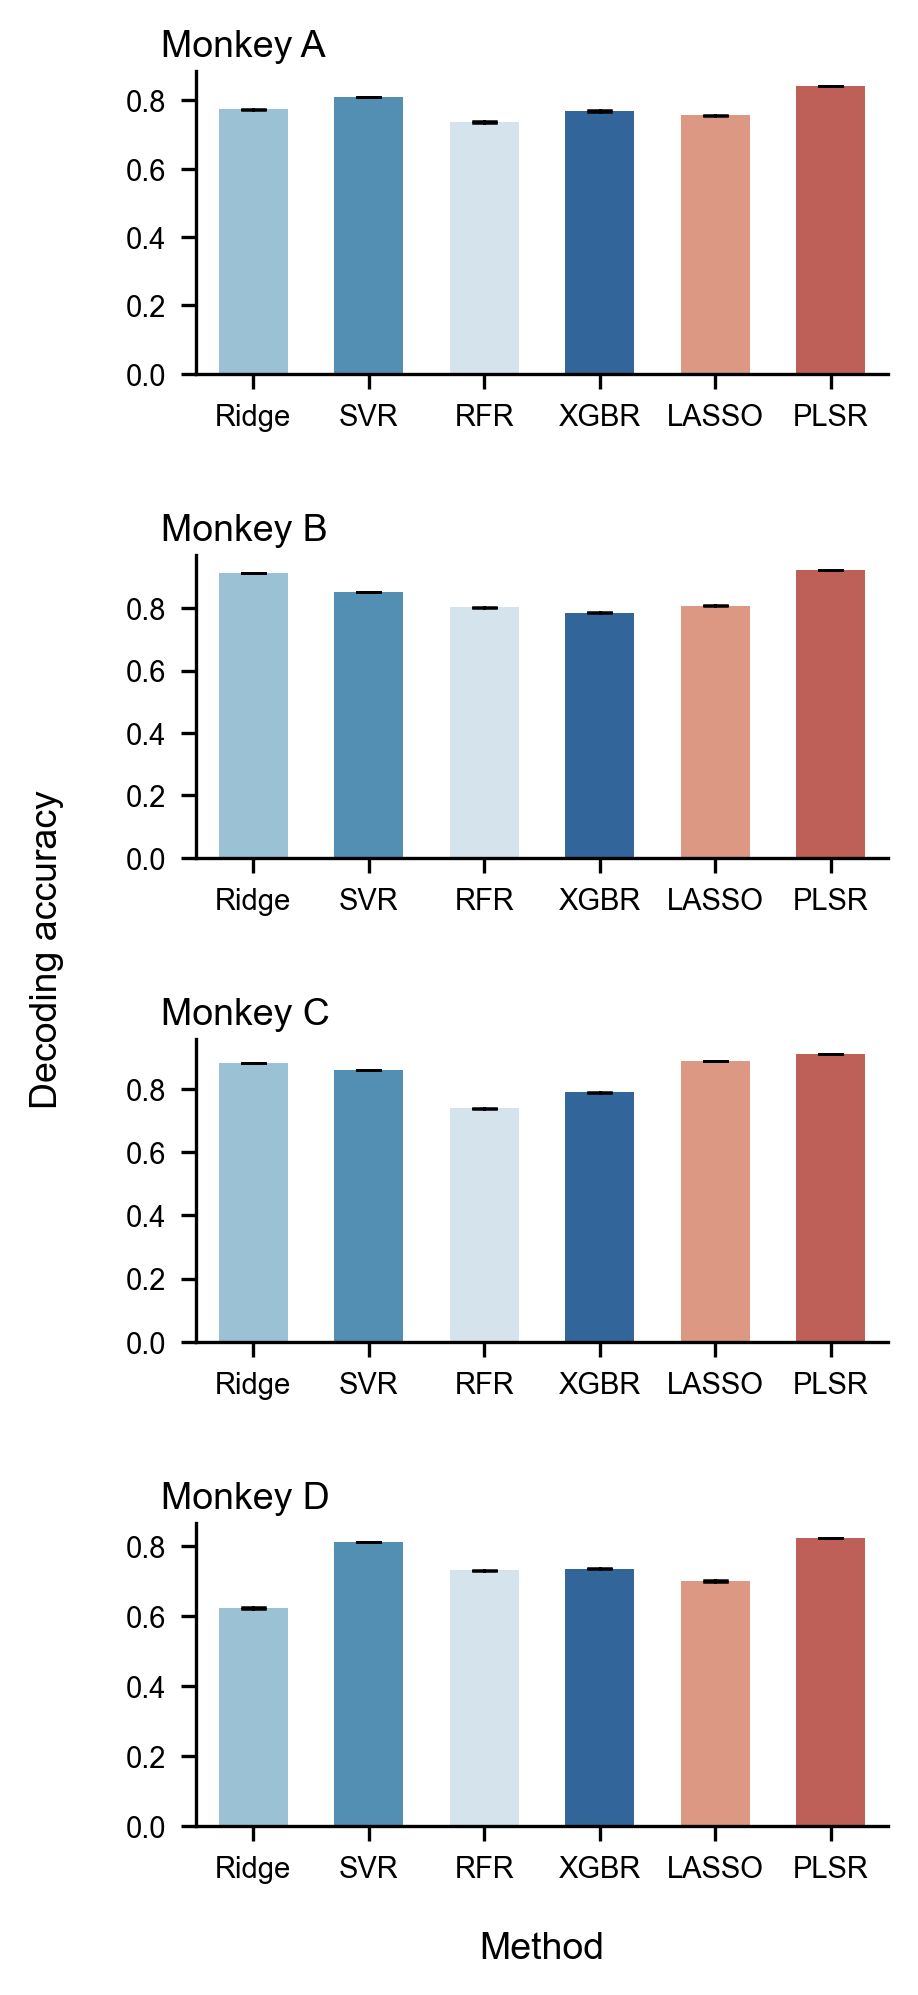

In [178]:
fig = plt.figure(figsize=(3.3,6.8),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

for monkey_id, monkey_name in enumerate(Monkey_name):
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
    monkey_results_path = os.path.join(results_dir, Monkey_results_name[monkey_id])
    data_matrix_PLSR = loadmat_data(data_path).T
    data_PLSR_the_specific_group = data_matrix_PLSR[the_specific_group, :]
    data_all_methods = data_PLSR_the_specific_group
    print(np.mean(data_PLSR_the_specific_group))
    methods_name = ['PLSR'] * len(data_PLSR_the_specific_group)
    x_label_name = ['PLSR']
    
    data_df = pd.DataFrame(columns=['methods', 'r'])   # Empty DataFrame
    pattern = r'r_matrix_(\w+)\.npy'
    data_filelist = natsorted(glob.glob(monkey_results_path+ 'r*.npy'))
    for i,filepath in enumerate(data_filelist):
        data_matrix = np.load(filepath)
        data_the_specific_group = np.squeeze(data_matrix[the_specific_group, :])
        data_all_methods = np.hstack([data_all_methods, data_the_specific_group])
        filename = os.path.basename(filepath)
        
        match = re.search(pattern, filename)
        extracted_string = match.group(1)
        methods_string = [extracted_string] * len(data_the_specific_group)
        methods_name.extend(methods_string)
        x_label_name.extend([extracted_string])
        print(f'method={[extracted_string]}, r={np.mean(data_the_specific_group)}')
    
    data_df['methods'] = methods_name
    data_df['r'] = data_all_methods
    
    ax=fig.add_subplot(4, 1, monkey_id+1)
    custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
    sns.barplot(x='methods', y='r', data=data_df, order=custom_order, hue='methods', width=0.6,
                    estimator=np.mean, palette=custom_palette,
                    errorbar=('ci', 95), capsize=.2, err_kws={'linewidth': 0.6, 'color': 'black'},ax=ax)
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    
    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    
    x_label = [i for i in range(0, methods_num, 1)]
    ax.set_xticks(x_label) 
    ax.set_xticklabels(custom_order, rotation=0) 

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.05, 1.05, monkey_name, transform=ax.transAxes, fontsize=label_size)

ax.text(0.55, 0.02, f'Method', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.05, 0.51, f'Decoding accuracy', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=0.2, bottom=.08, right=0.9, top=0.94, wspace=0.9, hspace=0.6) 
save_path = os.path.join(supple_dir, 'other_decoding_methods_r.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

## MAE

21.975028037043995
method=['LASSO'], r=27.835008636373388
method=['LR'], r=54.745094107304496
method=['RFR'], r=28.623275000000003
method=['Ridge'], r=29.940377617443467
method=['SVR'], r=30.257144099615896
method=['XGBR'], r=26.098825651454927
16.318370096720137
method=['LASSO'], r=25.87562067537512
method=['LR'], r=17.342827723188194
method=['RFR'], r=30.357241249999998
method=['Ridge'], r=17.289168638554784
method=['SVR'], r=30.2694069840531
method=['XGBR'], r=27.118003263854977
16.948493078661837
method=['LASSO'], r=18.538615351154395
method=['LR'], r=19.941013041602677
method=['RFR'], r=28.45748699621225
method=['Ridge'], r=19.635725762690328
method=['SVR'], r=28.466575976244663
method=['XGBR'], r=25.176043097782134
23.632126455186768
method=['LASSO'], r=30.52403512615581
method=['LR'], r=161.6928409527263
method=['RFR'], r=31.747891337707244
method=['Ridge'], r=42.29648653722606
method=['SVR'], r=31.4199499156163
method=['XGBR'], r=29.24462439889908


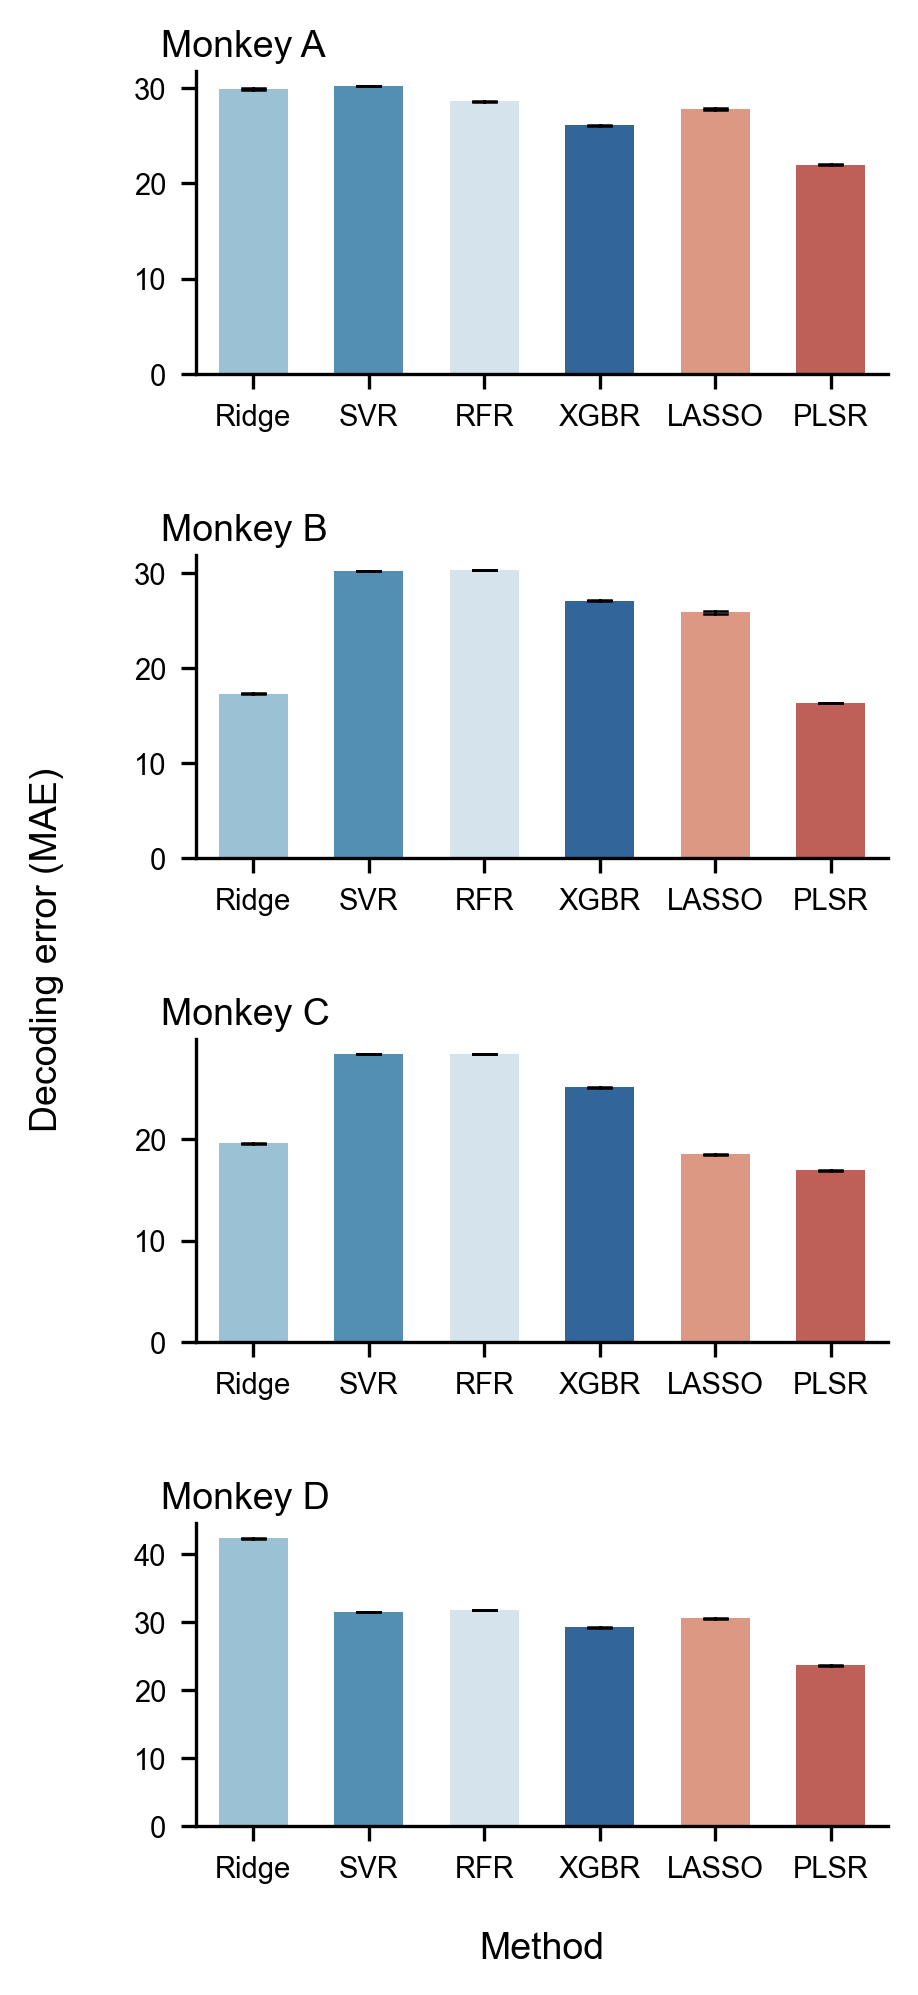

In [179]:
fig = plt.figure(figsize=(3.3,6.8),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

for monkey_id, monkey_name in enumerate(Monkey_name):
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/MAE_mean_rounds_all_groups_non_ori.mat')
    monkey_results_path = os.path.join(results_dir, Monkey_results_name[monkey_id])
    data_matrix_PLSR = loadmat_data(data_path).T
    data_PLSR_the_specific_group = data_matrix_PLSR[the_specific_group, :]
    data_all_methods = data_PLSR_the_specific_group
    print(np.mean(data_PLSR_the_specific_group))
    methods_name = ['PLSR'] * len(data_PLSR_the_specific_group)
    x_label_name = ['PLSR']
    
    data_df = pd.DataFrame(columns=['methods', 'MAE'])   # Empty DataFrame
    pattern = r'MAE_matrix_(\w+)\.npy'
    data_filelist = natsorted(glob.glob(monkey_results_path+ 'MAE*.npy'))
    for i,filepath in enumerate(data_filelist):
        data_matrix = np.load(filepath)
        data_the_specific_group = np.squeeze(data_matrix[the_specific_group, :])
        data_all_methods = np.hstack([data_all_methods, data_the_specific_group])
        filename = os.path.basename(filepath)
        
        match = re.search(pattern, filename)
        extracted_string = match.group(1)
        methods_string = [extracted_string] * len(data_the_specific_group)
        methods_name.extend(methods_string)
        x_label_name.extend([extracted_string])
        print(f'method={[extracted_string]}, r={np.mean(data_the_specific_group)}')
    
    data_df['methods'] = methods_name
    data_df['MAE'] = data_all_methods
    
    ax=fig.add_subplot(4, 1, monkey_id+1)
    custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
    sns.barplot(x='methods', y='MAE', data=data_df, order=custom_order, hue='methods', width=0.6,
                    estimator=np.mean, palette=custom_palette,
                    errorbar=('ci', 95), capsize=.2, err_kws={'linewidth': 0.6, 'color': 'black'},ax=ax)
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    
    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    
    x_label = [i for i in range(0, methods_num, 1)]
    ax.set_xticks(x_label) 
    ax.set_xticklabels(custom_order, rotation=0) 

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.05, 1.05, monkey_name, transform=ax.transAxes, fontsize=label_size)

ax.text(0.55, 0.02, f'Method', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.05, 0.51, f'Decoding error (MAE)', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=0.2, bottom=.08, right=0.9, top=0.94, wspace=0.9, hspace=0.6) 
save_path = os.path.join(supple_dir, 'other_decoding_methods_mae.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

# ICC

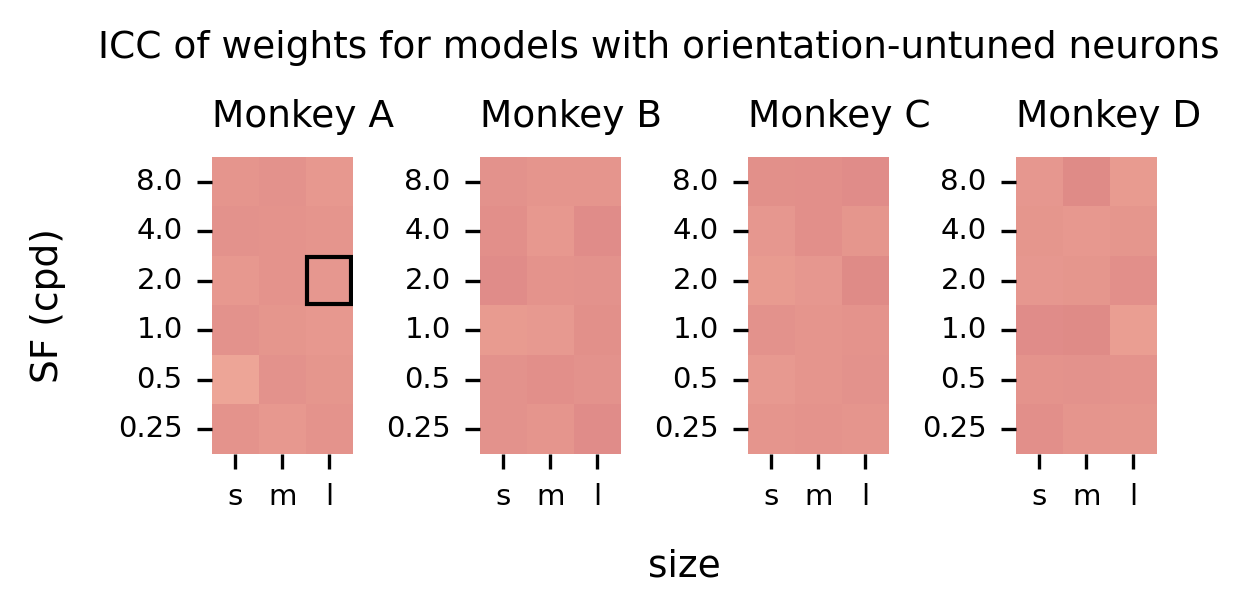

In [211]:
fig = plt.figure(figsize=(4.2,2.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
plt.style.use('default')
for monkey_id, monkey_name in enumerate(Monkey_name):
    data_path = os.path.join(Monkey_old_path_list[monkey_id], 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/ICC_r_p_non_ori.mat')
    ICC_r_all_cell = np.squeeze(loadmat_data(data_path))[0]
    ICC_r_all_cell = ICC_r_all_cell.reshape((-1,3), order='C')
    threshold = 0
    ICC_r_all_cell_thre = np.where(ICC_r_all_cell > threshold, ICC_r_all_cell, np.nan)
    ICC_r_all_cell_thre_flip = np.flip(ICC_r_all_cell_thre, axis=0)
    
    ax=fig.add_subplot(1, 4, monkey_id+1)
    h=sns.heatmap(ICC_r_all_cell_thre_flip, cmap='coolwarm',vmin=0.6, vmax=1, alpha=0.6, ax=ax, cbar=False)
    ax.set_xlabel('',fontsize=label_size)
    ax.set_ylabel('',fontsize=label_size)

    x_label = np.arange(0.5,2.6,1)
    ax.set_xticks(x_label)
    x_label_name = spatial_size
    ax.set_xticklabels(x_label_name, rotation=0)

    y_label_name = np.flip(np.array([0.25, 0.5, 1, 2, 4, 8]))
    y_label = np.arange(0.5,len(y_label_name),1)
    ax.set_yticks(y_label)
    ax.set_yticklabels(y_label_name, rotation =0)
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add rectangle
    if monkey_id == 0:
        rectangle = Rectangle((2.018, 2.018), 0.95, 0.95, alpha=1, facecolor="none", edgecolor="black", linewidth=1)
        ax.add_patch(rectangle)
        ax.text(0.06, 0.85, 'ICC of weights for models with orientation-untuned neurons', transform= fig.transFigure, size=label_size)
    ax.text(0, 1.1, monkey_name, transform=ax.transAxes, size=label_size)
    
    # break
left = 0.15
right = 0.9
bottom = 0.25
top = 0.7


ax.text((left+right)/2, 0.08, f'size', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.02, (bottom+top)/2, f'SF (cpd)', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.9, hspace=0.6) 
save_path = os.path.join(supple_dir, 'weights_stability_icc.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

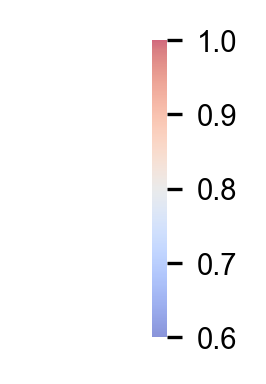

In [212]:
fig= plt.figure(figsize=(0.4, 2.2),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax_cb = plt.gca()
ax_cb.axis('off')
ax_cb.tick_params(axis='both', which='both', length=0)
ax_cb.set_xticklabels('')
ax_cb.set_yticklabels('')

cb = h.figure.colorbar(h.collections[0], ax=ax_cb,shrink=1, pad=0.5, location='right')
cb.ax.yaxis.set_tick_params(labelsize=tick_size)
cb.outline.set_visible(False) 



left = -0.9
right = 0.3
bottom = 0.25
top = 0.7
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.9, hspace=0.6) 
save_path = os.path.join(supple_dir, 'weights_stability_icc_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


# Weight stability (pairwise correlation coefficient)

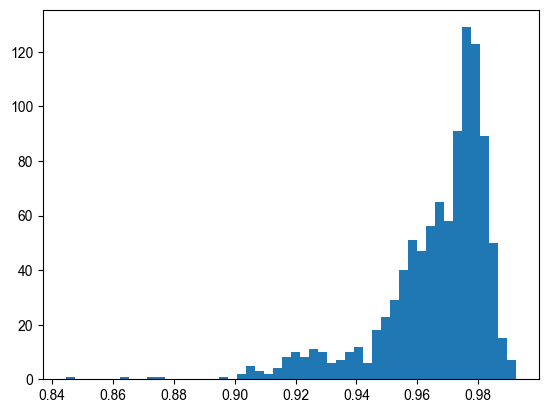

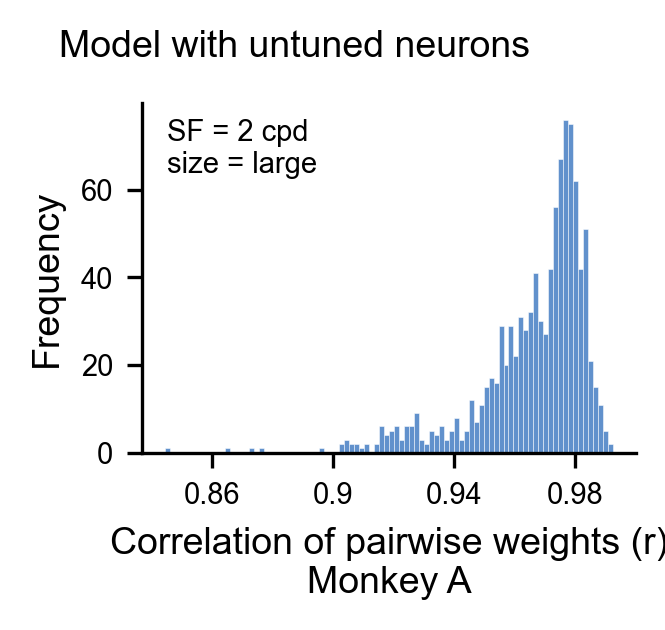

In [222]:
data_path = os.path.join(MonkeyA_old_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_non_ori_within_group_12.mat')
r_non_ori_within_group = np.squeeze(loadmat_data(data_path))

counts, bins, _ = plt.hist(r_non_ori_within_group,bins=50)
max_freq_index = np.argmax(counts)
mode_value = (bins[max_freq_index] + bins[max_freq_index + 1]) / 2


fig = plt.figure(figsize=(2.135,2.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
sns.histplot(data = r_non_ori_within_group, kde=False,bins=90, color='#2C6DBC', edgecolor='white')
ax = plt.gca()

ax.text(0.05, 0.85, 'Model with untuned neurons', transform= fig.transFigure, size=label_size)
ax.text(0.05, 0.8, 'SF = 2 cpd\nsize = large', transform=ax.transAxes, fontsize=legend_size) 

ax.set_xlabel('Correlation of pairwise weights (r)\nMonkey A', fontsize=label_size)
ax.set_ylabel('Frequency', fontsize=label_size)


ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = np.arange(0.86,1.01, 0.04)
ax.set_xticks(x_label)
x_label_name = np.round(x_label, 2)
ax.set_xticklabels(x_label_name, rotation=0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(left=.18, bottom=.25, right=0.95, top=0.78, wspace=0.6, hspace=0.8) 
save_path = os.path.join(supple_dir, 'weights_stability_pair_r.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# chi-sq and weights (for all groups)

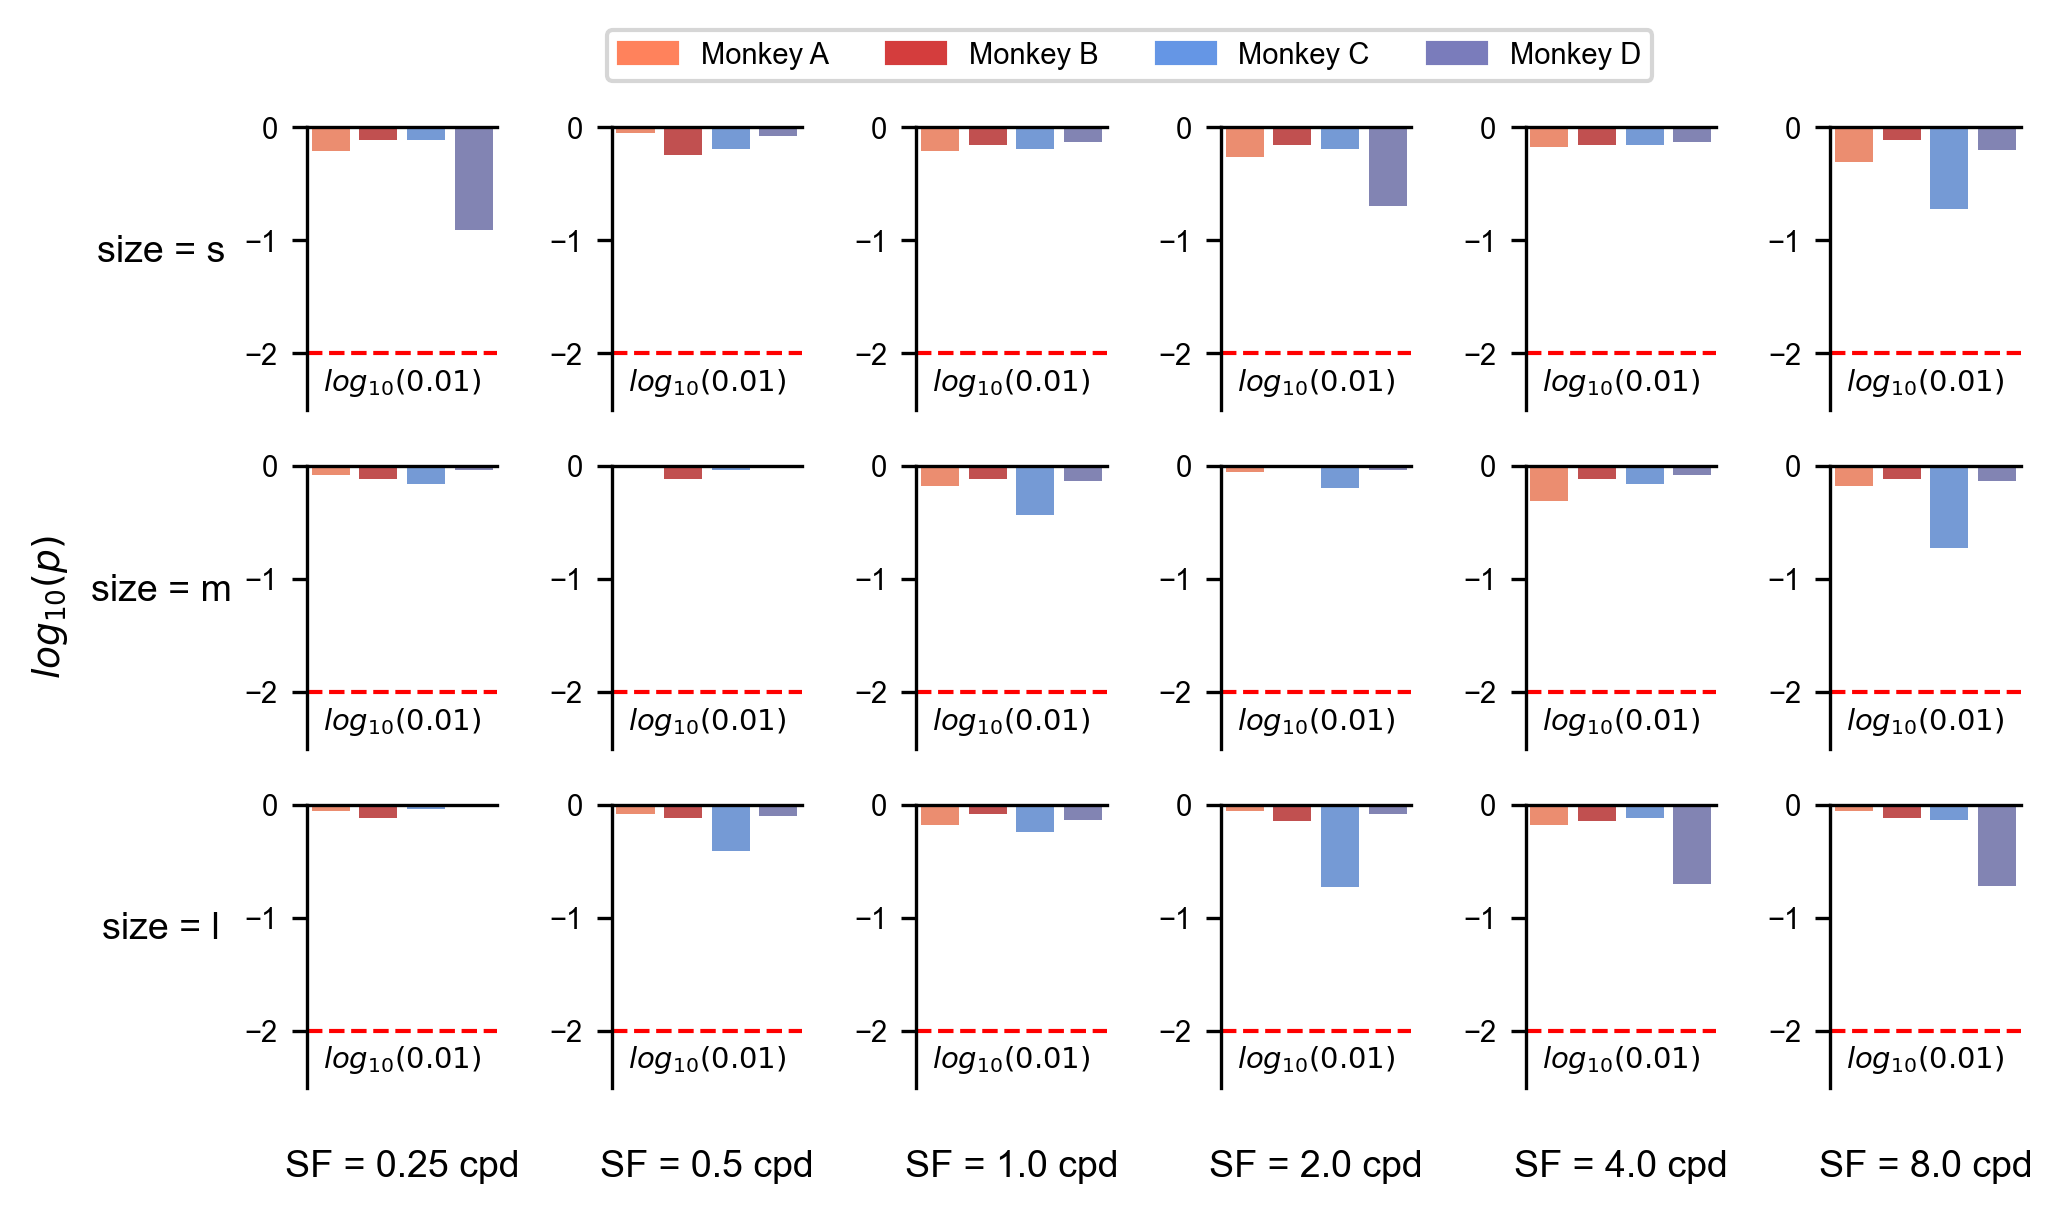

In [217]:
data_path = os.path.join(MonkeyA_old_path, 'results4_explain/ChiSq_weights_relationship/p_weights_chisq_non_ori_fdr.mat')
p_weights_chisq_non_ori_fdr_MonkeyA = np.squeeze(loadmat_data(data_path))
log_p_weights_chisq_non_ori_fdr_MonkeyA = np.log10(p_weights_chisq_non_ori_fdr_MonkeyA)


data_path = os.path.join(MonkeyB_old_path, 'results4_explain/ChiSq_weights_relationship/p_weights_chisq_non_ori_fdr.mat')
p_weights_chisq_non_ori_fdr_MonkeyB = np.squeeze(loadmat_data(data_path))
log_p_weights_chisq_non_ori_fdr_MonkeyB = np.log10(p_weights_chisq_non_ori_fdr_MonkeyB)


data_path = os.path.join(MonkeyC_old_path, 'results4_explain/ChiSq_weights_relationship/p_weights_chisq_non_ori_fdr.mat')
p_weights_chisq_non_ori_fdr_MonkeyC = np.squeeze(loadmat_data(data_path))
log_p_weights_chisq_non_ori_fdr_MonkeyC = np.log10(p_weights_chisq_non_ori_fdr_MonkeyC)

data_path = os.path.join(MonkeyD_old_path, 'results4_explain/ChiSq_weights_relationship/p_weights_chisq_non_ori_fdr.mat')
p_weights_chisq_non_ori_fdr_MonkeyD = np.squeeze(loadmat_data(data_path))
log_p_weights_chisq_non_ori_fdr_MonkeyD = np.log10(p_weights_chisq_non_ori_fdr_MonkeyD)

x_monkey = np.array(['Monkey A', 'Monkey B', 'Monkey C', 'Monkey D'])
fig = plt.figure(figsize=(6.8,4),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
axs = fig.subplots(len(spatial_size),len(spatial_frequency))
for the_group in range(len(spatial_size)*len(spatial_frequency)):
    log_p_weights_chisq_non_ori_fdr_MonkeyA_specific_group = log_p_weights_chisq_non_ori_fdr_MonkeyA[the_group]
    log_p_weights_chisq_non_ori_fdr_MonkeyB_specific_group = log_p_weights_chisq_non_ori_fdr_MonkeyB[the_group]
    log_p_weights_chisq_non_ori_fdr_MonkeyC_specific_group = log_p_weights_chisq_non_ori_fdr_MonkeyC[the_group]
    log_p_weights_chisq_non_ori_fdr_MonkeyD_specific_group = log_p_weights_chisq_non_ori_fdr_MonkeyD[the_group]

    y_r = np.array([log_p_weights_chisq_non_ori_fdr_MonkeyA_specific_group, 
                    log_p_weights_chisq_non_ori_fdr_MonkeyB_specific_group,
                    log_p_weights_chisq_non_ori_fdr_MonkeyC_specific_group,
                    log_p_weights_chisq_non_ori_fdr_MonkeyD_specific_group])

    col, row = divmod(the_group, len(spatial_size))
    ax=axs[row,col]
    plot = sns.barplot(x=x_monkey, y=y_r, palette=monkey_palette, hue=Monkey_name,ax=ax)
    ax.set_ylim(-2.5,0)
    
    
    if 0 <= the_group <= 2:
        ax.set_ylabel(f'size = {spatial_size[row]}', fontsize=label_size, rotation=0, labelpad=20)
    else:
        ax.set_ylabel('')
    
    if (the_group+1) % len(spatial_size) == 0:
        ax.set_xlabel(f'SF = {spatial_frequency[col]} cpd', fontsize=label_size, rotation=0, labelpad=15)
    else:
        ax.set_xlabel('')

    if the_group == 1:
        patches = [matplotlib.patches.Patch(color=monkey_palette[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
        labels = 'Monkey A', 'Monkey B', 'Monkey C', 'Monkey D'
        ax.legend(handles=patches, labels=labels,
            loc="center left",
            ncol=4,
            bbox_to_anchor=(0.28, 0.96),
            bbox_transform=fig.transFigure,
            fontsize=legend_size
        )
        ax.text(-1.35, 0.5, r'$log_{10}(p)$', transform=ax.transAxes, fontsize=label_size, va='center', ha='center', rotation=90)

    
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', labelsize=tick_size)

    ax.axhline(np.log10(0.01), color='red', linestyle='dashed', linewidth=1)
    ax.text(1.5, np.log10(0.01)-0.4, r'$log_{10}(0.01)$', fontsize=legend_size, ha='center', va='bottom') 

    
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

# plt.subplots_adjust(left=.14, bottom=0.1, right=0.98, top=0.9, wspace=0.5, hspace=0.2) 

plt.subplots_adjust(left=.14, bottom=0.1, right=0.98, top=0.9, wspace=0.6, hspace=0.2) 
save_path = os.path.join(supple_dir, 'correlation_chisq_weigths_all_groups.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


# the decoding result with alpha=0.05

In [189]:

df = 11
a_1 = 0.01
a_2 = 0.05
X_001_right =stats.chi2.isf(a_1,df)
X_005_right =stats.chi2.isf(a_2,df)

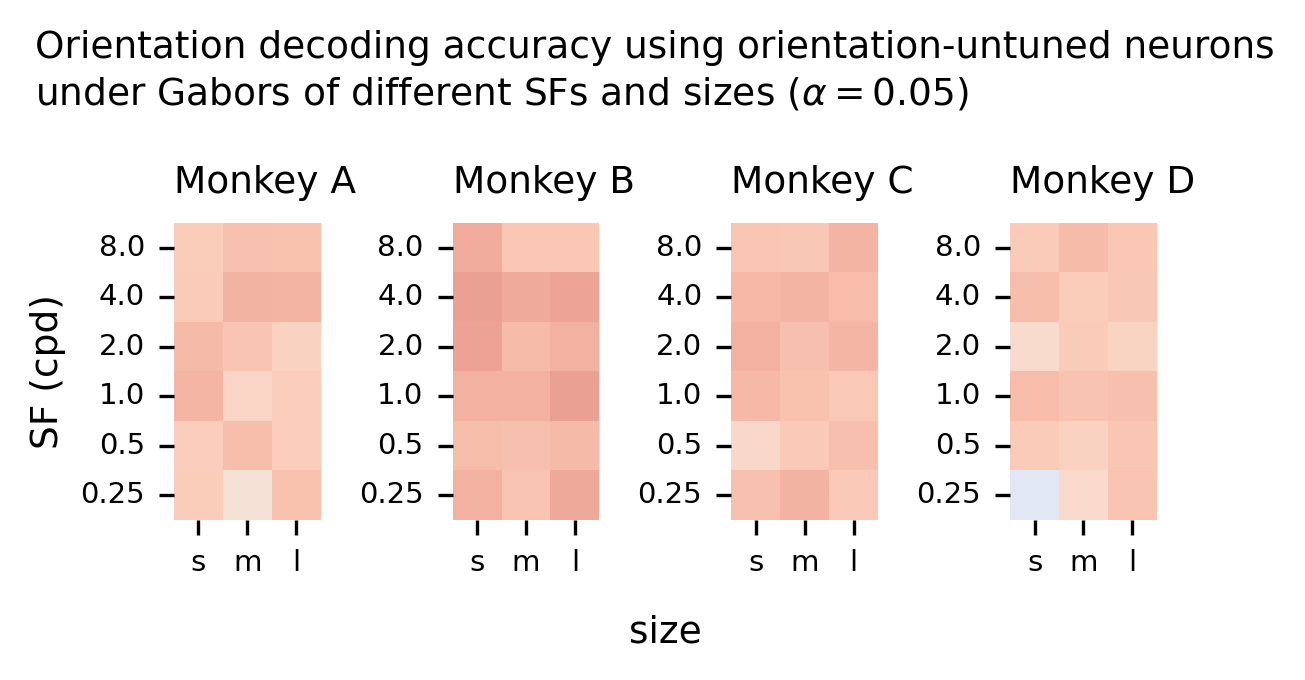

In [195]:
fig = plt.figure(figsize=(4.2,2.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
plt.style.use('default')
for monkey_id, monkey_name in enumerate(Monkey_name):
    
    monkey_path = Monkey_path_list[monkey_id]
    data_path = os.path.join(monkey_path, 'results1_pre_all_alpah/alpha_0.05/r_mean_rounds_all_groups_non_ori.mat')
    r_mean_all_group = np.mean(loadmat_data(data_path),axis=0)
    r_mean_all_group = r_mean_all_group.reshape((-1,3), order='C')
    r_mean_all_group_flip = np.flip(r_mean_all_group, axis=0)
    
    ax=fig.add_subplot(1, 4, monkey_id+1)
    h=sns.heatmap(r_mean_all_group_flip, cmap='coolwarm',vmin=0, vmax=1,alpha=0.6, ax=ax, cbar=False)
    ax.set_xlabel('',fontsize=label_size)
    ax.set_ylabel('',fontsize=label_size)

    x_label = np.arange(0.5,2.6,1)
    ax.set_xticks(x_label)
    x_label_name = spatial_size
    ax.set_xticklabels(x_label_name, rotation=0)

    y_label_name = np.flip(np.array([0.25, 0.5, 1, 2, 4, 8]))
    y_label = np.arange(0.5,len(y_label_name),1)
    ax.set_yticks(y_label)
    ax.set_yticklabels(y_label_name, rotation =0)
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Orientation decoding accuracy using orientation-untuned neurons\nunder Gabors of different SFs and sizes
    # Add rectangle
    if monkey_id == 0:
        # rectangle = Rectangle((2.018, 2.018), 0.95, 0.95, alpha=1, facecolor="none", edgecolor="black", linewidth=1)
        # ax.add_patch(rectangle)
        ax.text(0.01, 0.95, r'Orientation decoding accuracy using orientation-untuned neurons', transform= fig.transFigure, size=label_size)
        ax.text(0.01, 0.88, r'under Gabors of different SFs and sizes ($\alpha = 0.05$)', transform= fig.transFigure, size=label_size)
    ax.text(0, 1.1, monkey_name, transform=ax.transAxes, size=label_size)
    
    # break
left = 0.12
right = 0.9
bottom = 0.25
top = 0.7


ax.text((left+right)/2, 0.08, f'size', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.02, (bottom+top)/2, f'SF (cpd)', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.9, hspace=0.6) 
save_path = os.path.join(supple_dir, 'alpha_005_decoding_accuracy_all_groups_heatmap.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
    

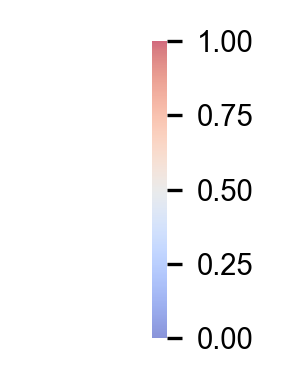

In [193]:
fig= plt.figure(figsize=(0.4, 2.2),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax_cb = plt.gca()
ax_cb.axis('off')
ax_cb.tick_params(axis='both', which='both', length=0)
ax_cb.set_xticklabels('')
ax_cb.set_yticklabels('')

cb = h.figure.colorbar(h.collections[0], ax=ax_cb,shrink=1, pad=0.5, location='right')

y_ticks = np.arange(0, 1.01, 0.25)  
cb.ax.yaxis.set_ticks(y_ticks)  
cb.ax.yaxis.set_ticklabels([f'{tick:.2f}' for tick in y_ticks])  
cb.ax.yaxis.set_tick_params(labelsize=tick_size)
cb.outline.set_visible(False) 


left = -0.9
right = 0.3
bottom = 0.25
top = 0.7
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.9, hspace=0.6) 
save_path = os.path.join(supple_dir, 'alpha_005_decoding_accuracy_all_groups_heatmap_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)


# The proportion of neurons with alpha=0.05

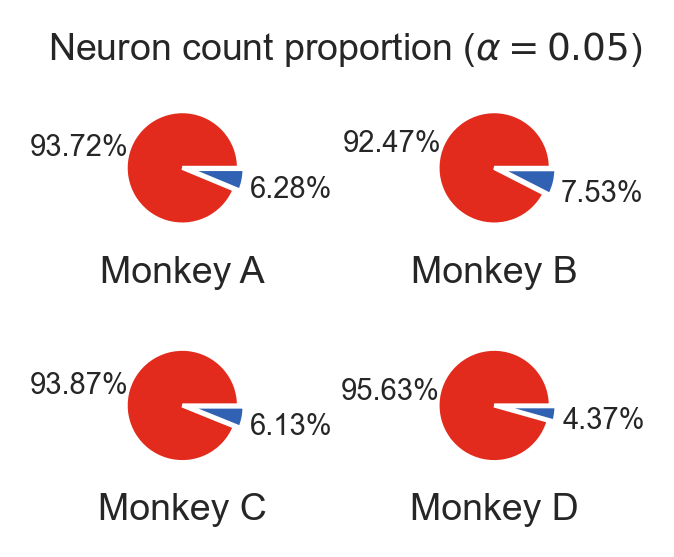

In [188]:
fig = plt.figure(figsize=(2.1,2.2),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

pie_width = 0.18
x_interval = 0.22
y_interval = 0.25
text_x = 0
radius=1
pie_linewidth=1
start_x = 0.35
x_label_2 = -1

for monkey_id in range(len(Monkey_name)):
    data_path = os.path.join(Monkey_path_list[monkey_id], 'results1_pre_all_alpah/alpha_0.05')
    proportion_ori_cell = np.squeeze(loadmat_data(os.path.join(data_path, 'proportion_ori_cell.mat')))
    ax=fig.add_subplot(2, 2, monkey_id+1)
    # ax.text(text_x, 0.5, f'{Monkey_name[monkey_id]}',transform=ax.transAxes, fontsize=label_size, color='#000000', ha='center')
    ax.pie(x=[proportion_ori_cell, 1 - proportion_ori_cell],
            # labels=['Ori Num','Non-ori Num'],
            colors=[ori_color, non_ori_color],
            autopct='%.2f%%',
            pctdistance=1.85,
            explode=(0, 0.1),
            radius=radius,
     
            wedgeprops={'edgecolor':'w',
                    #     'linestyle':'-',
                        'alpha':1,
                        #matplotlib.patches.Wedge
                        'linewidth':pie_linewidth,                                      
                    },
            textprops={'fontsize': legend_size}
        )
    ax.set_xlabel(Monkey_name[monkey_id],  fontsize=label_size)
    
    
ax.text(0.05, 0.95, r'Neuron count proportion ($\alpha = 0.05$)', transform=fig.transFigure, fontsize=label_size, ha='left', va='center') 
plt.subplots_adjust(left=.15, bottom=.26, right=0.87, top=0.92, wspace=1.2, hspace=0.2) 
save_path = os.path.join(supple_dir, 'alpha_005_neuron_number_per.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# cvPCA_ Feature Spectrum (paper)

In [113]:
def cvPCA(X):
    ''' X is 2 x stimuli x neurons '''
    pca = PCA(n_components=min(1024, X.shape[1])).fit(X[0].T)
    u = pca.components_.T
    sv = pca.singular_values_
    
    xproj = X[0].T @ (u / sv)
    cproj0 = X[0] @ xproj
    cproj1 = X[1] @ xproj
    ss = abs((cproj0 * cproj1).sum(axis=0))
    scaler_eig = MinMaxScaler()
    ss = scaler_eig.fit_transform(ss.reshape(-1,1)).flatten()
    return ss

def cvPCA_iter(data_re, n_iter=10):
    trail_num = data_re.shape[0]
    n_iter=10
    ss_all = []
    for i in range(n_iter):
        select_idx = random.sample(range(trail_num), 2)
        X = data_re[select_idx,:,:]
        ss = cvPCA(X)
        ss_all.append(ss)
        
    ss_mean = np.mean(ss_all, axis=0)
    scaler_eig = MinMaxScaler()
    ss_mean = scaler_eig.fit_transform(ss_mean.reshape(-1,1)).flatten()
    return ss_mean

In [123]:
markersize = 1.3
linewidth = 0.8

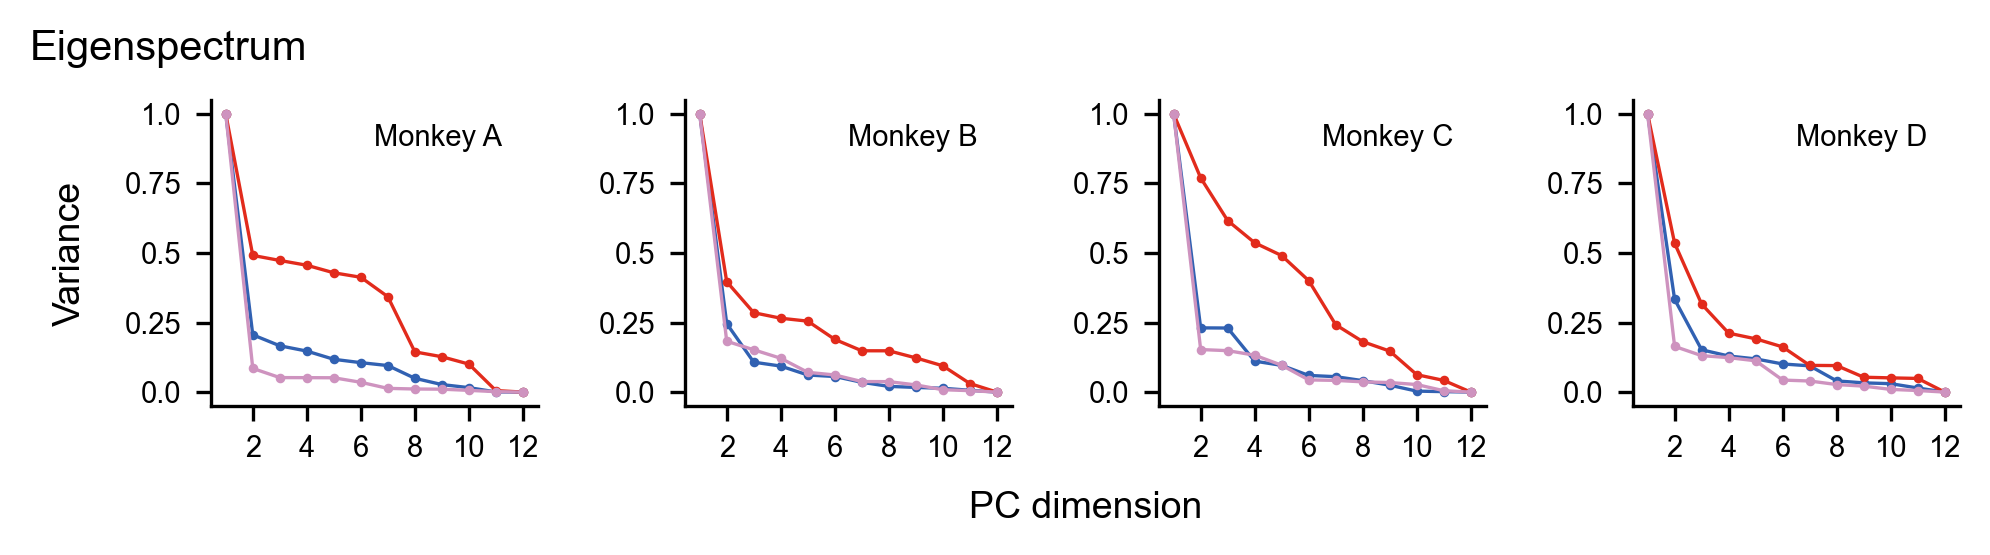

In [128]:
file_dir = 'response_data'
fig = plt.figure(figsize=(6.7, 1.7),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

for monkey_id, monkey_name in enumerate(Monkey_name):
    random.seed(42)
    data_path = os.path.join(Monkey_old_path_list[monkey_id], file_dir, 'X_response_non_ori.mat')
    X_response = loadmat_data(data_path)
    data = X_response[:,:,the_specific_group]
    neuron_num = data.shape[1]
    data_re = np.reshape(data, [-1,12,neuron_num], order='F')
    ss_non_ori = cvPCA_iter(data_re)
    ss_non_ori = np.sort(ss_non_ori)[::-1]
    

    data_path = os.path.join(Monkey_old_path_list[monkey_id], file_dir, 'X_response_ori.mat')
    X_response = loadmat_data(data_path)
    data = X_response[:,:,the_specific_group]
    neuron_num = data.shape[1]
    data_re = np.reshape(data, [-1,12,neuron_num], order='F')
    ss_ori = cvPCA_iter(data_re)
    ss_ori = np.sort(ss_ori)[::-1]
    
    data_path = os.path.join(Monkey_old_path_list[monkey_id], file_dir, 'X_response_all.mat')
    X_response = loadmat_data(data_path)
    data = X_response[:,:,the_specific_group]
    neuron_num = data.shape[1]
    data_re = np.reshape(data, [-1,12,neuron_num], order='F')
    ss_all = cvPCA_iter(data_re)
    ss_all = np.sort(ss_all)[::-1]


    ax=fig.add_subplot(1, 4, monkey_id+1)
    ax.plot(ss_non_ori,  color=non_ori_color, marker='o', markersize=markersize, linewidth=linewidth)
    ax.plot(ss_ori,  color=ori_color, marker='o', markersize=markersize, linewidth=linewidth)
    ax.plot(ss_all,  color=all_color, marker='o', markersize=markersize, linewidth=linewidth)
    
    ax.set_xlabel('',fontsize=label_size)
    ax.set_ylabel('',fontsize=label_size)
    ax.text(0.5, 0.85, monkey_name, transform=ax.transAxes, size=legend_size)

    x_label = np.arange(1,12,2)
    ax.set_xticks(x_label)
    ax.set_xticklabels(x_label+1, rotation=0)

    y_label = np.arange(0, 1.01, 0.25)
    y_label = np.round(y_label, 2) 
    ax.set_yticks(y_label) 
    ax.set_yticklabels(y_label, rotation =0)
    
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
left = 0.1
right = 0.97
bottom = 0.25
top = 0.85

ax.text(0.01, 0.95, f'Eigenspectrum', transform=fig.transFigure, fontsize=sub_title_size, ha='left', va='center')
ax.text((left+right)/2, 0.05, f'PC dimension', transform=fig.transFigure, fontsize=label_size, ha='center', va='center') 
ax.text(0.03, (bottom+top)/2, f'Variance', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0.45, hspace=1) 
save_path = os.path.join(main_dir, 'cvPCA_eigen_paper.pdf')
plt.savefig(save_path, format='pdf', dpi=300)



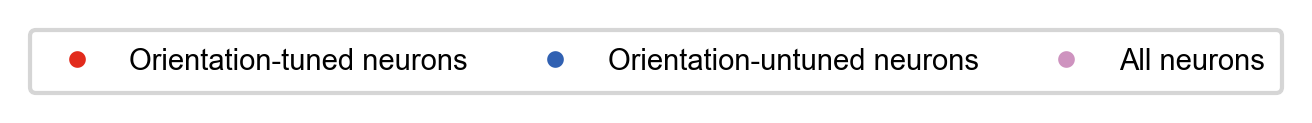

In [115]:
fig_legend = plt.figure(figsize=(5,0.25),facecolor='none', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'
ax = fig_legend.gca()
ax.axis('off')


alpha = 1
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ori_color, markersize=5, label='Orientation-tuned neurons' ,alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=non_ori_color, markersize=5, label='Orientation-untuned neurons', alpha=alpha),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=all_color, markersize=5, label='All neurons', alpha=alpha),
]



fig_legend.legend(
    handles=legend_elements, loc='center', frameon=True, fontsize=tick_size, 
    ncol=3,  
    borderpad=0.6, 

)
save_path = os.path.join(main_dir, 'cvPCA_eigen_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# The decoding result of ANN (error bar)

In [135]:
custom_palette = sns.color_palette('RdBu', n_colors=11)[1:4] + sns.color_palette('RdBu', n_colors=11)[-3:-1]

In [136]:
father_path = '../NonOriSelect/ANN_Monkey_compare/ANN_output'
Model_dir_list = ['AlexNet', 'vgg16', 'Resnet_101', 'Squeezenet', 'CORnet_s']
Model_name_list = ['AlexNet', 'VGG-16', 'ResNet-101', 'SqueezeNet', 'CORnet-S']
key_name = 'r_mean_rounds.mat'

In [137]:
mat_name = 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat'

r_mean_all = []
model_all = []
for idx, model_dir in enumerate(Model_dir_list):
    data_path = os.path.join(father_path, model_dir, key_name)
    r_mean_groups = loadmat_data(data_path)
    r_mean = np.squeeze(r_mean_groups)
    model = [Model_name_list[idx]]  * len(r_mean)
    
    r_mean_all.extend(r_mean)
    model_all.extend(model)
    # break

r_mean_df = pd.DataFrame(columns=['model', 'r'])   # Empty DataFrame
r_mean_df['model'] = model_all
r_mean_df['r'] = r_mean_all

r_mean_df.groupby('model')['r'].mean()


model
AlexNet       0.417737
CORnet-S      0.711906
ResNet-101    0.743400
SqueezeNet    0.779412
VGG-16        0.853232
Name: r, dtype: float64

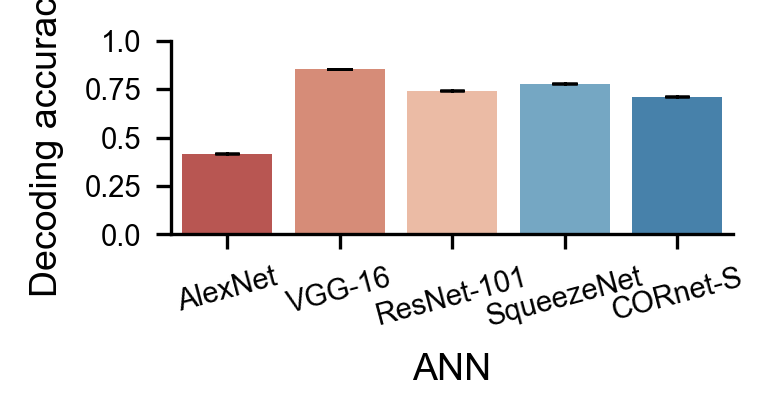

In [139]:
fig = plt.figure(figsize=(2.5,1.5),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax = sns.barplot(x='model', y='r', data=r_mean_df, hue='model',
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci', 95), capsize=.2, 
                 err_kws={'color': 'black', 'linewidth': 0.6}, linewidth=0.8)

    
ax.set_ylim(0,1)

ax.set_xlabel('ANN',fontsize=label_size, labelpad=5)
ax.set_ylabel('Decoding accuracy', fontsize=label_size, labelpad=5)




ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, 5, 1)]
x_label_name = Model_name_list
ax.set_xticks(x_label) 
ax.set_xticklabels(x_label_name, rotation=15) 

y_label = np.arange(0, 1.1, 0.25)
y_label = np.round(y_label, 2) 
ax.set_yticks(y_label) 
ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.subplots_adjust(left=.21, bottom=.4, right=0.96, top=0.83, wspace=None, hspace=None) 
save_path = os.path.join(main_dir, 'ann_decoding_acc.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# ANN Neuron Ratio

/tmp/ipykernel_2624445/4008764244.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ann_results_df = pd.concat([ann_results_df, pd.DataFrame([new_data])], ignore_index =True)
/tmp/ipykernel_2624445/4008764244.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='name', y='Non_percent', data=ann_results_df , order=custom_order,
/tmp/ipykernel_2624445/4008764244.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_name, rotation=15) # 设置x轴刻度标签并旋转刻度标签


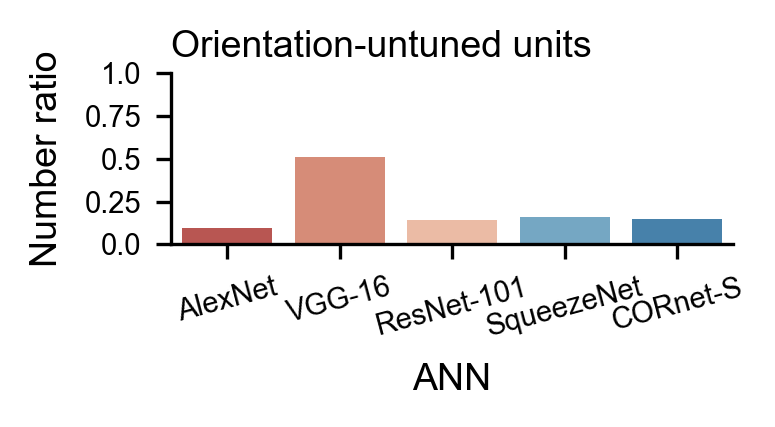

In [140]:
ann_results_df = pd.DataFrame(columns=['name','layer', 'similarity', 'accuarcy', 'Non_number', 'Non_percent'])

new_data = {'name': 'AlexNet', 'layer': 'features.5', 'similarity': 0.8374060906356074, 'accuarcy':0.421444535255432, 'Non_number':3143, 'Non_percent': 0.09689349112426035}
ann_results_df = pd.concat([ann_results_df, pd.DataFrame([new_data])], ignore_index =True)
new_data = {'name': 'VGG-16', 'layer': 'features.19', 'similarity': 0.8235308312285838, 'accuarcy':0.854412615299225, 'Non_number':206131, 'Non_percent': 0.5135199099170918}
ann_results_df = pd.concat([ann_results_df, pd.DataFrame([new_data])], ignore_index =True)
new_data = {'name': 'ResNet-101', 'layer': 'layer2', 'similarity': 0.7870047135663839, 'accuarcy':0.744718492031097, 'Non_number':56237, 'Non_percent': 0.1400993502869898}
ann_results_df = pd.concat([ann_results_df, pd.DataFrame([new_data])], ignore_index =True)
new_data = {'name': 'SqueezeNet', 'layer': 'features.6', 'similarity': 0.8220025417866508, 'accuarcy':0.780158579349518, 'Non_number':29607, 'Non_percent': 0.15864519032921812}
ann_results_df = pd.concat([ann_results_df, pd.DataFrame([new_data])], ignore_index =True)
new_data = {'name': 'CORnet-S', 'layer': 'module.V2', 'similarity': 0.6605347404321037, 'accuarcy':0.713066875934601, 'Non_number':14885, 'Non_percent': 0.14832788584183673}
ann_results_df = pd.concat([ann_results_df, pd.DataFrame([new_data])], ignore_index =True)
custom_order = ['AlexNet', 'VGG-16', 'ResNet-101', 'SqueezeNet', 'CORnet-S']
Non_percent = np.array(ann_results_df['Non_percent'])
Non_number = np.array(ann_results_df['Non_number'])
On_number = np.divide(Non_number, Non_percent)
custom_palette = sns.color_palette('RdBu', n_colors=11)[1:4] + sns.color_palette('RdBu', n_colors=11)[-3:-1]

fig = plt.figure(figsize=(2.5,1.5),facecolor='w', frameon=True, dpi=300) 
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax = sns.barplot(x='name', y='Non_percent', data=ann_results_df , order=custom_order,
                 estimator=np.mean, palette=custom_palette)
ax.set_xlabel('ANN',fontsize=label_size, labelpad=5)
ax.set_ylabel('Number ratio', fontsize=label_size, labelpad=5)
ax.set_title('Orientation-untuned units', loc='left', fontsize=label_size, y=0.95)




ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)



x_label_name = custom_order
ax.set_xticklabels(x_label_name, rotation=15) 

y_label = np.arange(0, 1.1, 0.25)
y_label = np.round(y_label, 2) 
ax.set_yticks(y_label) 
ax.set_yticklabels(y_label, rotation =0)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=.21, bottom=.45, right=0.96, top=0.83, wspace=None, hspace=None) 

save_path = os.path.join(main_dir, 'ann_units_number_ratio.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

# top1 and top5 (after ANN masked)

In [143]:

rootpath = '../NonOriSelect/ANN_Monkey_compare/ANN_output'
custom_order = ['AlexNet', 'VGG-16', 'ResNet-101', 'SqueezeNet', 'CORnet-S']
network = ['AlexNet', 'vgg16', 'Resnet_101', 'Squeezenet', 'CORnet_s',]

## top1

/tmp/ipykernel_2624445/1236280413.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ablation_results_acc_df = pd.concat([ablation_results_acc_df, pd.DataFrame([new_data])], ignore_index=True)


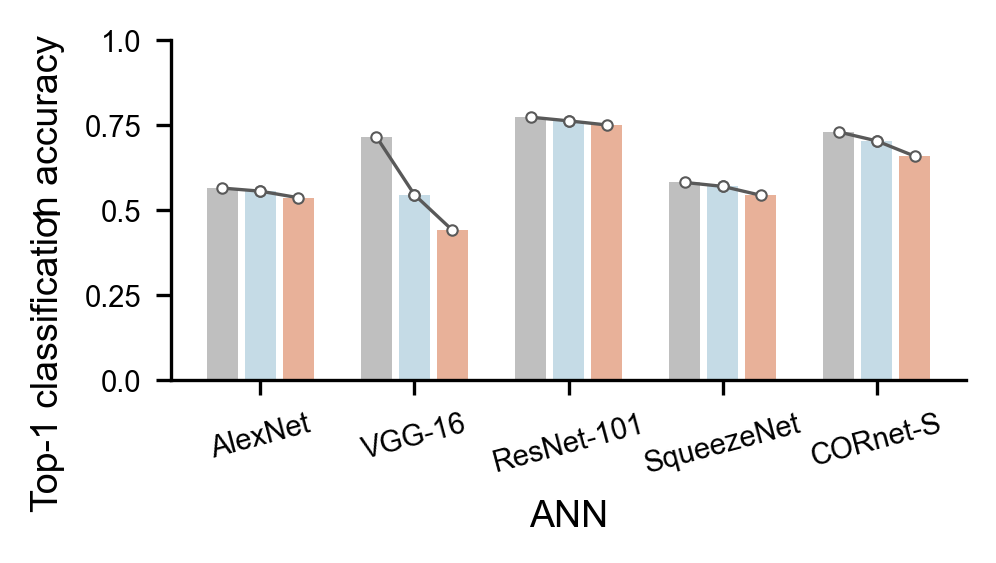

In [165]:
acc_type = 'acc1'
ablation_results_acc_df = pd.DataFrame(columns=['network name', 'origin ANN', 'ANN with orientation-tuned units masked', 'ANN with orientation-untuned units masked'])
for i, network_name in enumerate(network):
    file_path = os.path.join(rootpath, network_name, 'results_all_neurons')
    with open(os.path.join(file_path, 'acc_average.json'), 'r') as f:
        data = json.load(f)
    acc_origin = data[acc_type] / 100
    
    file_path = os.path.join(rootpath, network_name, 'results_mask_ori_neurons')
    with open(os.path.join(file_path, 'acc_average.json'), 'r') as f:
        data = json.load(f)
    acc_with_ori_mask = data[acc_type] / 100
    
    file_path = os.path.join(rootpath, network_name, 'results_mask_non_ori_neurons')
    with open(os.path.join(file_path, 'acc_average.json'), 'r') as f:
        data = json.load(f)
    acc_with_non_mask = data[acc_type] / 100
    
    new_data = {'network name': network_name, 'origin ANN': acc_origin, 'ANN with orientation-tuned units masked': acc_with_ori_mask, 'ANN with orientation-untuned units masked': acc_with_non_mask}
    ablation_results_acc_df = pd.concat([ablation_results_acc_df, pd.DataFrame([new_data])], ignore_index=True)
x = np.arange(len(ablation_results_acc_df))
fig= plt.figure(figsize=(3.4,1.8),facecolor='w', frameon=True, dpi=300) 

plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax =plt.gca()

x = np.arange(len(ablation_results_acc_df))

width = 0.2
bar_center_displacement = width/3 +0.18
rects1 = ax.bar(x-bar_center_displacement, ablation_results_acc_df['origin ANN'], width, label='Original ANN', color='#BFBFBF', alpha=1)
rects2 = ax.bar(x, ablation_results_acc_df['ANN with orientation-tuned units masked'], width, label='ANN with orientation-tuned units masked', color='#C5DBE6', alpha=1)
rects3 = ax.bar(x+bar_center_displacement, ablation_results_acc_df['ANN with orientation-untuned units masked'], width, label='ANN with orientation-untuned units masked', color='#E8B199', alpha=1)

for i in range(len(ablation_results_acc_df)):
    ax.plot([i- bar_center_displacement, i], 
            [ablation_results_acc_df['origin ANN'][i], ablation_results_acc_df['ANN with orientation-tuned units masked'][i]],
            color='#595959', marker='o', markersize=2.5,markerfacecolor='white', markeredgewidth=0.5, linewidth=0.8)
    
for i in range(len(ablation_results_acc_df)):
    ax.plot([i, i + bar_center_displacement], 
            [ablation_results_acc_df['ANN with orientation-tuned units masked'][i], ablation_results_acc_df['ANN with orientation-untuned units masked'][i]],
            color='#595959', marker='o', markersize=2.5,markerfacecolor='white', markeredgewidth=0.5, linewidth=0.8)

ax.set_xlabel('ANN',fontsize=label_size, labelpad=5)
ax.set_ylabel('', fontsize=label_size, labelpad=5)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label_name = custom_order
ax.set_xticks(x)
ax.set_xticklabels(x_label_name, rotation=15) 

y_label = np.arange(0, 1.1, 0.25)
y_label = np.round(y_label, 2) 
ax.set_yticks(y_label) 
ax.set_yticklabels(y_label, rotation =0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

left = .18
right = 0.96
bottom = .3
top = 0.93

ax.text(0.06, 0.5, 'Top-1 classification accuracy', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=None, hspace=None) 

save_path = os.path.join(main_dir, 'ann_mask_top1.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
        

## top5

/tmp/ipykernel_2624445/2584447480.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ablation_results_acc_df = pd.concat([ablation_results_acc_df, pd.DataFrame([new_data])], ignore_index=True)


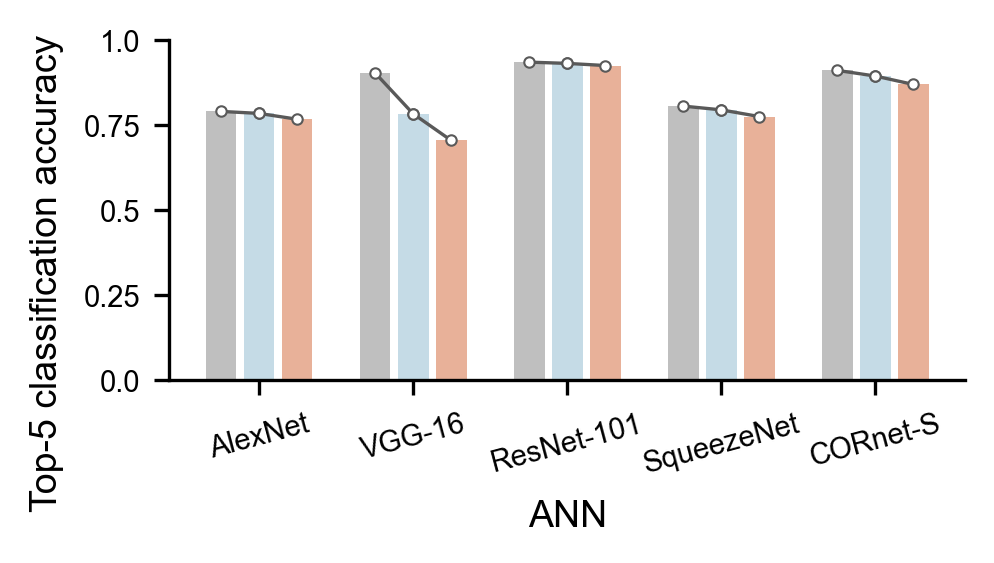

In [167]:
acc_type = 'acc5'
ablation_results_acc_df = pd.DataFrame(columns=['network name', 'origin ANN', 'ANN with orientation-tuned units masked', 'ANN with orientation-untuned units masked'])
for i, network_name in enumerate(network):
    file_path = os.path.join(rootpath, network_name, 'results_all_neurons')
    with open(os.path.join(file_path, 'acc_average.json'), 'r') as f:
        data = json.load(f)
    acc_origin = data[acc_type] / 100
    
    file_path = os.path.join(rootpath, network_name, 'results_mask_ori_neurons')
    with open(os.path.join(file_path, 'acc_average.json'), 'r') as f:
        data = json.load(f)
    acc_with_ori_mask = data[acc_type] / 100
    
    file_path = os.path.join(rootpath, network_name, 'results_mask_non_ori_neurons')
    with open(os.path.join(file_path, 'acc_average.json'), 'r') as f:
        data = json.load(f)
    acc_with_non_mask = data[acc_type] / 100
    
    new_data = {'network name': network_name, 'origin ANN': acc_origin, 'ANN with orientation-tuned units masked': acc_with_ori_mask, 'ANN with orientation-untuned units masked': acc_with_non_mask}
    ablation_results_acc_df = pd.concat([ablation_results_acc_df, pd.DataFrame([new_data])], ignore_index=True)
x = np.arange(len(ablation_results_acc_df))
fig= plt.figure(figsize=(3.4,1.8),facecolor='w', frameon=True, dpi=300) 

plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

ax =plt.gca()

x = np.arange(len(ablation_results_acc_df))

width = 0.2
bar_center_displacement = width/3 +0.18
rects1 = ax.bar(x-bar_center_displacement, ablation_results_acc_df['origin ANN'], width, label='Original ANN', color='#BFBFBF', alpha=1)
rects2 = ax.bar(x, ablation_results_acc_df['ANN with orientation-tuned units masked'], width, label='ANN with orientation-tuned units masked', color='#C5DBE6', alpha=1)
rects3 = ax.bar(x+bar_center_displacement, ablation_results_acc_df['ANN with orientation-untuned units masked'], width, label='ANN with orientation-untuned units masked', color='#E8B199', alpha=1)

for i in range(len(ablation_results_acc_df)):
    ax.plot([i- bar_center_displacement, i], 
            [ablation_results_acc_df['origin ANN'][i], ablation_results_acc_df['ANN with orientation-tuned units masked'][i]],
            color='#595959', marker='o', markersize=2.5,markerfacecolor='white', markeredgewidth=0.5, linewidth=0.8)
    
for i in range(len(ablation_results_acc_df)):
    ax.plot([i, i + bar_center_displacement], 
            [ablation_results_acc_df['ANN with orientation-tuned units masked'][i], ablation_results_acc_df['ANN with orientation-untuned units masked'][i]],
            color='#595959', marker='o', markersize=2.5,markerfacecolor='white', markeredgewidth=0.5, linewidth=0.8)

ax.set_xlabel('ANN',fontsize=label_size, labelpad=5)
ax.set_ylabel('', fontsize=label_size, labelpad=5)

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label_name = custom_order
ax.set_xticks(x)
ax.set_xticklabels(x_label_name, rotation=15) 

y_label = np.arange(0, 1.1, 0.25)
y_label = np.round(y_label, 2) 
ax.set_yticks(y_label) 
ax.set_yticklabels(y_label, rotation =0)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

left = .18
right = 0.96
bottom = .3
top = 0.93

ax.text(0.06, 0.5, 'Top-5 classification accuracy', transform=fig.transFigure, fontsize=label_size, rotation=90, ha='center', va='center') 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=None, hspace=None) 

save_path = os.path.join(main_dir, 'ann_mask_top5.pdf')
plt.savefig(save_path, format='pdf', dpi=300)

## colorbar

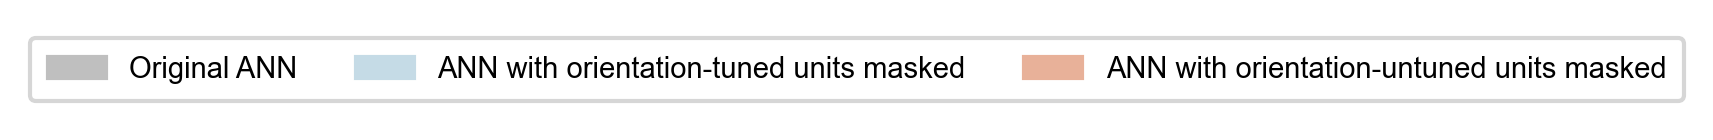

In [151]:

import matplotlib.patches as mpatches


fig_legend = plt.figure(figsize=(6, 0.35), facecolor='w', frameon=True, dpi=300)
plt.rcParams["font.family"] = "Arial"
ax = fig_legend.gca()
ax.axis('off')

alpha = 1
legend_elements = [
    mpatches.Patch(color='#BFBFBF', label='Original ANN', alpha=alpha),
    mpatches.Patch(color='#C5DBE6', label='ANN with orientation-tuned units masked', alpha=alpha),
    mpatches.Patch(color='#E8B199', label='ANN with orientation-untuned units masked', alpha=alpha),
]

fig_legend.legend(
    handles=legend_elements,
    loc='center',
    frameon=True,
    fontsize=tick_size,
    ncol=3,
    borderpad=0.6,
)

save_path = os.path.join(main_dir, 'ann_mask_colorbar.pdf')
plt.savefig(save_path, format='pdf', dpi=300)
